# Data Exploratory Analysis + Data Quality
## Machine: Convenyor Belt
###  >> using statistics, visualizations and clustering methods <<
by Tobia Ippolito

<br>

**Table of Contents:**
- [Helper Functions](#Helper-Functions)
- [Load Data](#Load-Data)
- [Amount](#Amount)
- [Time Coverage](#Time-Coverage)
- [Coverage / Null Check](#Coverage-/-Null-Check)
- [Duplicates](#Duplicates)
- [Reports](#Reports)
- [Statistics about the data](#Statistics-about-the-data)
- [Correlation](#Correlation)
- [Outliers and Anomalies](#Outliers-and-Anomalies)
- [Stationarity](#Stationarity)
- [Visualize Data](#Visualize-Data)
- [Feature Selection](#Feature-Selection)
- [Dimension Reduction](#Dimension-Reduction)
- [Clustering](#Clustering)
- [Frequency Analysis](#Frequency-Analysis)
- [Weather Analysis](#Weather-Analysis)

<br><br>


To Do:
- Write results of visualizations
- Write reults of Feature selection
- Write reults of dimension reduction
- Write reults of clustering
- Write Frequency analysis -> how to interepret?
- Look for more things to do
- Transfer to Mirror

### Imports

In [42]:
# Imports

# basic data
import numpy as np
import pandas as pd

# helper functions
import IPython
import holidays
from datetime import datetime
import random

# vizulations
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# auto report
# import dtale
# import sweetviz as sv
# from ydata_profiling import ProfileReport
# from autoviz import AutoViz_Class

# stationarity
from statsmodels.tsa.stattools import adfuller

# Anomaly/Outlier detection
from scipy.stats import median_abs_deviation
from sklearn.neighbors import LocalOutlierFactor

# Unsupervised
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN, OPTICS

# Feature Selection
#from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression

# dimensionaly reducion
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

# clustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans

# weather
from meteostat import Stations, Monthly, Point, Daily

# other
from copy import copy, deepcopy


---
### Helper Functions

In [43]:
def display(df:pd.DataFrame, use_html=True, amount=5, columns=None, reset_index=True, should_return=False):
    """
    A function to displays a DataFrame.  
    """
    if amount != None and amount != -1 and amount != "all":
        df = df.sample(min(amount, len(df.index)))

    if reset_index:
        df = df.reset_index(drop=True, inplace=False)

    if columns != None:
        if type(columns) == list or type(columns) == tuple:
            df = df.loc[:, columns]
        else:
            df = df.loc[:, [columns]]

    if use_html:
        if type(df) == pd.Series:
            df = df.to_frame()
        target = IPython.display.HTML(df.to_html())
    else:
        target = df

    IPython.display.display(target)

    if should_return:
        return df

In [44]:
def handle_nulls(data:pd.DataFrame, cols:list, cols_to_skip=["Zeitstempel"], print_result=False, display_result=False):
    """
    This methods handles null values.

    Procedure:
    1. Interpolate missing values
    2. Take the value after the value for the rest of missing values
    Now all missing values should be removed

    Avalailable methods:
    drop                => df = df.dropna(subset=[TARGET])                   
    take previous value => df[TARGET] = df[TARGET].fillna(method='ffill')
    take next value     => df[TARGET] = df[TARGET].fillna(method='bfill')    
    take mean value     => df[TARGET] = df[TARGET].fillna(df[TARGET].mean()) 
    interpolate         => df[TARGET] = df[TARGET].interpolate()
    """
    new_df = data.copy()
    null_counts = new_df.isnull().sum().values
    processed_cols = list()
    for cur_col in cols:
        if cur_col not in cols_to_skip:
            new_df[cur_col] = new_df[cur_col].interpolate()
            new_df[cur_col] = new_df[cur_col].fillna(method='bfill')
            processed_cols += [cur_col] 

    new_null_counts = new_df.isnull().sum().values

    # check null values
    if print_result:
        print(f"Super your data has now {sum(new_null_counts)} missing values 🥳")
        for old_nulls, new_nulls, cur_col in zip(null_counts, new_null_counts, processed_cols):
            print(f"    -> Removed {old_nulls-new_nulls}/{old_nulls} nulls from '{cur_col}'")

    if display_result:
        null_counts = new_df.isnull().sum()
        null_counts_percentage = null_counts.apply(lambda x:round((x/len(new_df.index))*100, 2))
        null_df = pd.concat([null_counts.rename("Nulls"), null_counts_percentage.rename("Nulls in Percentage")], axis=1).sort_values(by="Nulls", ascending=False)
        display(null_df, amount=-1, reset_index=False)

    return new_df

In [45]:
HOLIDAYS_DE = holidays.DE()

def check_day_type(date_str, format='%d.%m.%Y'):
    """
    A function to get if a date is a working day.
    """
    date_obj = datetime.strptime(date_str, format)
    
    # weekend?
    if date_obj.weekday() >= 5:
        return 'weekend'
    # holiday?
    elif date_obj in HOLIDAYS_DE:
        return 'holiday'
    else:
        return 'workday'

In [46]:
def get_random_week(data:pd.DataFrame):
    """
    A function to extract one random week.
    """
    mondays = data[data.index.dayofweek == 0].index
    random_monday = np.random.choice(mondays)
    end_date = random_monday + pd.DateOffset(days=6)
    return data.loc[random_monday:end_date]

In [47]:
def normalize(data, skip_columns=["Zeitstempel"]):
    """
    A Function to normalize data.
    """
    scaler = StandardScaler()
    normalised_df = data.copy()
    for cur_col in normalised_df.columns::
        if cur_col not in skip_columns:
            normalised_df[cur_col] = scaler.fit_transform(normalised_df[cur_col].to_numpy().reshape(-1, 1))
    return normalised_df

In [48]:
def get_frequency(data:pd.DataFrame, column="Zeitstempel"):
    """
    Return the frequency of a time column.
    """
    if column == None:
        time_delta = data.index.diff().median()
    else:
        time_delta = data[column].diff().median()

    seconds = time_delta.total_seconds()

    hours, rest = divmod(seconds, 3600)
    minutes, _ = divmod(rest, 60)

    if hours > 0:
        result = f"{int(hours)}h"
    elif minutes > 0:
        result = f"{int(minutes)}min"
    else:
        result = f"{int(seconds)}sec"

    return result

In [49]:
def set_frequency(data:pd.DataFrame, freq=None, column="Zeitstempel"):
    """
    Sets the frequency of a time column.
    """
    new_data = data.copy()

    null_counts = new_data.isnull().sum().values

    if freq == None:
        freq = get_frequency(new_data)
        print(f"Found Frequency {freq}")
    
    if column == None:
        new_data.index = new_data.index.asfreq(freq)
    else:
        new_data[column] = new_data[column].asfreq(freq)

    new_null_counts = new_data.isnull().sum().values
    # check null values
    for old_nulls, new_nulls, cur_col in zip(null_counts, new_null_counts, new_data.columns):
        if old_nulls != new_nulls:
            print(f"Change in missing values from {cur_col}\n    -> Old: {old_nulls}\n    -> New: {new_nulls}")

    if column == None:
        new_freq = new_data.index.freq
    else:
        new_freq = new_data[column].dt.freq

    print(f"New Frequency is: {new_freq}")

    return new_data

---
### Load Data

Load the data and making some preprocessing steps.

[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

In [50]:
#df = pd.read_csv("../../../data/hacker-export-28-10-2010---28-10-2023.csv", sep=";")
df = pd.read_csv("../../../data/Langholzhacker-export-12-04-2023---06-11-2023.csv", sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109639 entries, 0 to 1109638
Data columns (total 13 columns):
 #   Column                                                                                           Non-Null Count    Dtype  
---  ------                                                                                           --------------    -----  
 0   Zeitstempel                                                                                      1109639 non-null  object 
 1   Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Blindarbeit (Abgabe) [varh]  55538 non-null    float64
 2   Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Blindarbeit (Bezug) [varh]   55538 non-null    float64
 3   Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Ges. Blindleistung [var]     1109344 non-null  float64
 4   Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Ges. Scheinleistung [VA]     1109345 non-null 

In [51]:
df.columns

Index(['Zeitstempel',
       'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Blindarbeit (Abgabe) [varh]',
       'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Blindarbeit (Bezug) [varh]',
       'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Ges. Blindleistung [var]',
       'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Ges. Scheinleistung [VA]',
       'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Ges. Wirkleistung [W]',
       'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Leistungsfaktor []',
       'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Netzfrequenz [Hz]',
       'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Strom L1 [A]',
       'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Strom L2 [A]',
       'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Strom L3 [

In [52]:
df = df.rename(columns={
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Blindarbeit (Abgabe) [varh]':'Blindarbeit_Abgabe',
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Blindarbeit (Bezug) [varh]':'Blindarbeit_Bezug',
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Ges. Blindleistung [var]':'Ges. Blindleistung',
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Ges. Scheinleistung [VA]':'Ges. Scheinleistung',
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Ges. Wirkleistung [W]':'Ges. Wirkleistung',
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Strom L1 [A]':'Strom L1', 
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Strom L2 [A]':'Strom L2',
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Strom L3 [A]':'Strom L3',
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Wirkarbeit (Bezug) [Wh]':'Wirkarbeit_Bezug',
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Wirkarbeit (Abgabe) [Wh]':'Wirkarbeit_Abgabe',
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Leistungsfaktor []':'Leistungsfaktor',
            'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Netzfrequenz [Hz]':'Netzfrequenz'
            }
        )

df.columns

Index(['Zeitstempel', 'Blindarbeit_Abgabe', 'Blindarbeit_Bezug',
       'Ges. Blindleistung', 'Ges. Scheinleistung', 'Ges. Wirkleistung',
       'Leistungsfaktor', 'Netzfrequenz', 'Strom L1', 'Strom L2', 'Strom L3',
       'Wirkarbeit_Abgabe', 'Wirkarbeit_Bezug'],
      dtype='object')

In [53]:
# change datetime
df['Zeitstempel'] = pd.to_datetime(df['Zeitstempel'], format='%d.%m.%Y %H:%M:%S') #, format='%d.%b.%Y %H:%M:%S'
df.dtypes

Zeitstempel            datetime64[ns]
Blindarbeit_Abgabe            float64
Blindarbeit_Bezug             float64
Ges. Blindleistung            float64
Ges. Scheinleistung           float64
Ges. Wirkleistung             float64
Leistungsfaktor               float64
Netzfrequenz                  float64
Strom L1                      float64
Strom L2                      float64
Strom L3                      float64
Wirkarbeit_Abgabe             float64
Wirkarbeit_Bezug              float64
dtype: object

In [54]:
for cur_col in df.columns.to_list():
    if cur_col != "Zeitstempel":
        df[cur_col] = df[cur_col].apply(lambda x:str(x).replace(",", ".")).astype("float")
df.dtypes

Zeitstempel            datetime64[ns]
Blindarbeit_Abgabe            float64
Blindarbeit_Bezug             float64
Ges. Blindleistung            float64
Ges. Scheinleistung           float64
Ges. Wirkleistung             float64
Leistungsfaktor               float64
Netzfrequenz                  float64
Strom L1                      float64
Strom L2                      float64
Strom L3                      float64
Wirkarbeit_Abgabe             float64
Wirkarbeit_Bezug              float64
dtype: object

In [55]:
# sort data
df.sort_values(by="Zeitstempel", inplace=True)

In [56]:
df.sample(5)

Zeitstempel  Blindarbeit_Abgabe  Blindarbeit_Bezug  \
725868 2023-08-31 20:15:00          2474888.09          3182075.4   
840073 2023-09-20 18:07:00                 NaN                NaN   
954571 2023-10-10 16:36:45                 NaN                NaN   
723234 2023-08-31 09:16:30                 NaN                NaN   
336900 2023-06-10 00:16:30                 NaN                NaN   

        Ges. Blindleistung  Ges. Scheinleistung  Ges. Wirkleistung  \
725868              128.56               567.82             454.37   
840073             2172.97            139881.95           92793.05   
954571             5757.55             67667.96           44766.80   
723234            -1078.39              1820.46            1135.79   
336900              121.82               548.28             440.01   

        Leistungsfaktor  Netzfrequenz  Strom L1  Strom L2  Strom L3  \
725868             0.80           NaN      1.23      1.22      0.00   
840073             0.66         50.02    203.22    202.29    202.92   
954571              NaN           NaN     99.37     97.81     97.65   
723234              NaN           NaN      3.92      3.90      0.00   
336900              NaN           NaN      1.19      1.19      0.00   

        Wirkarbeit_Abgabe  Wirkarbeit_Bezug  
725868              16.71       40638571.98  
840073                NaN               NaN  
954571                NaN               NaN  
723234                NaN               NaN  
336900                NaN               NaN

In [57]:
# save original data with new names
origin_df = df.copy()

Data downsampling to every 15 minutes? -> 96 data points a day?<br>
seems like we have more 

In [58]:
# in minutes
get_frequency(df)

'15sec'

=> 0.25 Minute difference

In [59]:
# downsampling

DOWNSAMPLING = True

if DOWNSAMPLING:
    # null value handling
    df = handle_nulls(df, cols=df.columns, print_result=True)
    print()

    null_counts = df.isnull().sum().values

    # sum_df = df.resample('15min', on="Zeitstempel").sum()  #origin="start_day"
    # sum_df["Zeitstempel"] = sum_df.index

    resampled_df = df.resample('15min', on="Zeitstempel").mean()
    resampled_df["Zeitstempel"] = resampled_df.index
    resampled_df = resampled_df.reset_index(drop=True, inplace=False)

    df = resampled_df
    new_null_counts = df.isnull().sum().values

    # check null values
    for old_nulls, new_nulls, cur_col in zip(null_counts, new_null_counts, df.columns):
        if old_nulls < new_nulls:
            print(f"Notice the missing values after resampling from the column '{cur_col}'\n    -> Old Nulls = {old_nulls}\n    -> New Nulls = {new_nulls}\n")

    display(resampled_df, amount=5)

Super your data has now 0 missing values 🥳
    -> Removed 0/0 nulls from 'Blindarbeit_Abgabe'
    -> Removed 1054101/1054101 nulls from 'Blindarbeit_Bezug'
    -> Removed 1054101/1054101 nulls from 'Ges. Blindleistung'
    -> Removed 295/295 nulls from 'Ges. Scheinleistung'
    -> Removed 294/294 nulls from 'Ges. Wirkleistung'
    -> Removed 295/295 nulls from 'Leistungsfaktor'
    -> Removed 832048/832048 nulls from 'Netzfrequenz'
    -> Removed 1021819/1021819 nulls from 'Strom L1'
    -> Removed 295/295 nulls from 'Strom L2'
    -> Removed 292/292 nulls from 'Strom L3'
    -> Removed 291/291 nulls from 'Wirkarbeit_Abgabe'
    -> Removed 1054100/1054100 nulls from 'Wirkarbeit_Bezug'

Notice the missing values after resampling from the column 'Blindarbeit_Abgabe'
    -> Old Nulls = 0
    -> New Nulls = 1462

Notice the missing values after resampling from the column 'Blindarbeit_Bezug'
    -> Old Nulls = 0
    -> New Nulls = 1462

Notice the missing values after resampling from the co

Even if your original dataframe df had no missing values, the resampling process can still create missing values in the resampled_df. This happens when there are time intervals in the resampled index that do not have corresponding data points in the original dataframe.

For example, let’s say your original dataframe has data for every minute from 10:00 to 10:10. If you resample this data to a 15-minute interval, you will end up with two time bins: one from 10:00 to 10:14 and another from 10:15 to 10:29. The first bin will have data, but the second bin will not because your original data only goes up to 10:10. Therefore, the mean of the second bin will be NaN, creating a missing value in the resampled dataframe.

This is a common occurrence when downsampling data, and it’s important to decide how you want to handle these missing values.

=> Propably cause from August where are many missing values (about 01.08.2023-15.08.2023)

In [60]:
get_frequency(df)

'15min'

In [61]:
# sort data
df.sort_values(by="Zeitstempel", inplace=True)
df.index = df['Zeitstempel']

In [62]:
# set static variables
TARGET = "Ges. Wirkleistung"
MACHINE_NAME = "Conveyor_Belt"
FREQUENCY = get_frequency(df)
print(f"Frequency: {FREQUENCY}")

PLOT_TRANSPARENT = True

ORIGIN_ROWS = len(origin_df.index)
print(f"Originl Rows: {ORIGIN_ROWS}")

ROWS = len(df.index)
print(f"Rows: {ROWS}")

COLUMNS = df.columns.to_list()
print(f"Columns:\n{COLUMNS}");

Frequency: 15min
Originl Rows: 1109639
Rows: 19991
Columns:
['Blindarbeit_Abgabe', 'Blindarbeit_Bezug', 'Ges. Blindleistung', 'Ges. Scheinleistung', 'Ges. Wirkleistung', 'Leistungsfaktor', 'Netzfrequenz', 'Strom L1', 'Strom L2', 'Strom L3', 'Wirkarbeit_Abgabe', 'Wirkarbeit_Bezug', 'Zeitstempel']


Results:<br>
Data had to change dtype of the time-column and also of the float columns. The float crsting had to noticed the , as seperator.<br>
The frequency/samplerate also had to change to 15 minutes.<br>
There were nulls to handle.<br>
Else is the read in successfull. 

---
### Amount


[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

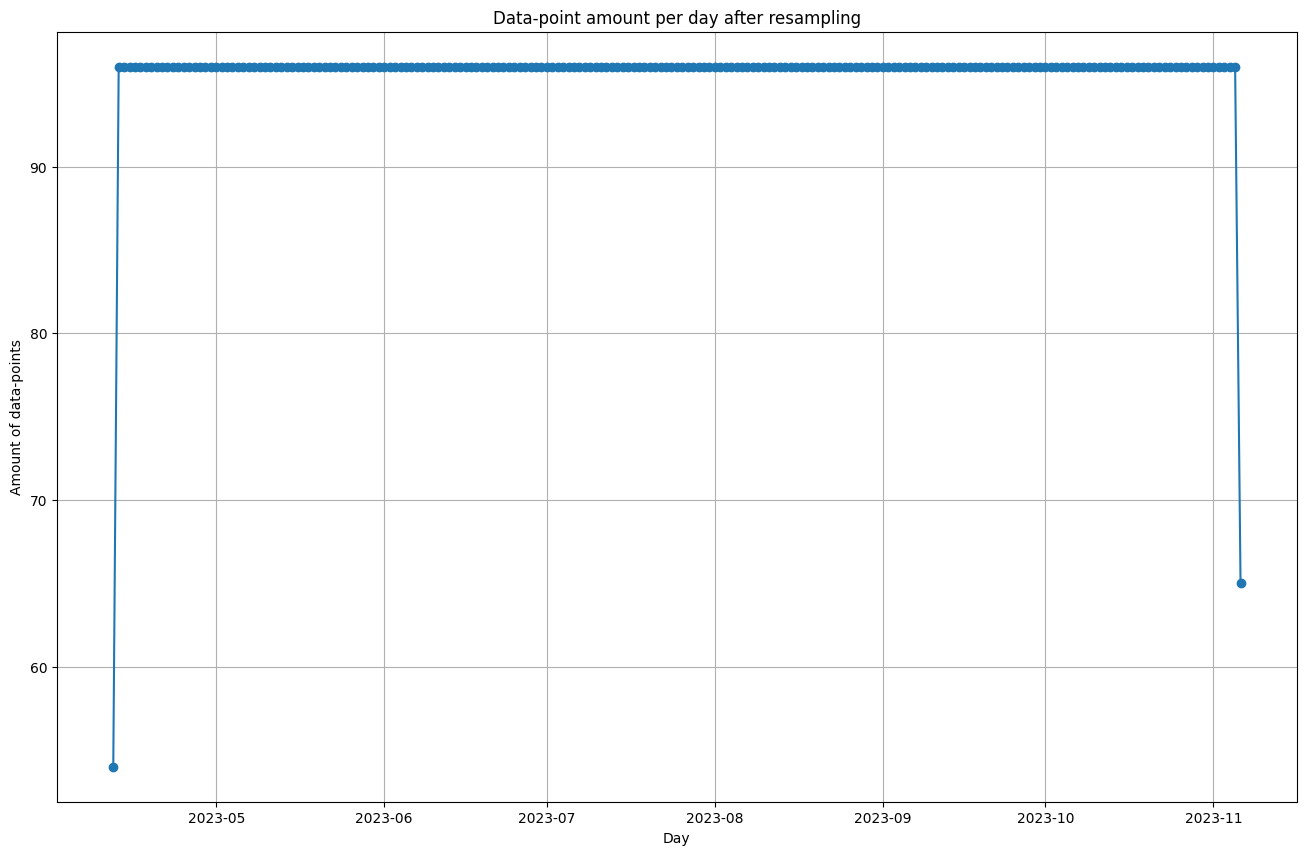

In [63]:
%matplotlib inline

date_counts = df['Zeitstempel'].dt.date.value_counts()
date_counts = date_counts.sort_index()

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[16, 10])
#ax.bar(height=date_counts, x=date_counts.index)
ax.set_title("Data-point amount per day after resampling")
ax.set_xlabel("Day")
ax.set_ylabel("Amount of data-points")
ax.plot(date_counts.index, date_counts, 'o-')
ax.grid()
# set x-ticks and x-tick labels
# n = len(date_counts.index)
# ticks = n // 10  # This will give the number of ticks
# ax.set_xticks(np.arange(n)[::ticks]) 
# ax.set_xticklabels(date_counts[::ticks], rotation=45);

plt.savefig(f'./results/self/{MACHINE_NAME} Data-point amount per day after resampling.png', transparent=PLOT_TRANSPARENT)

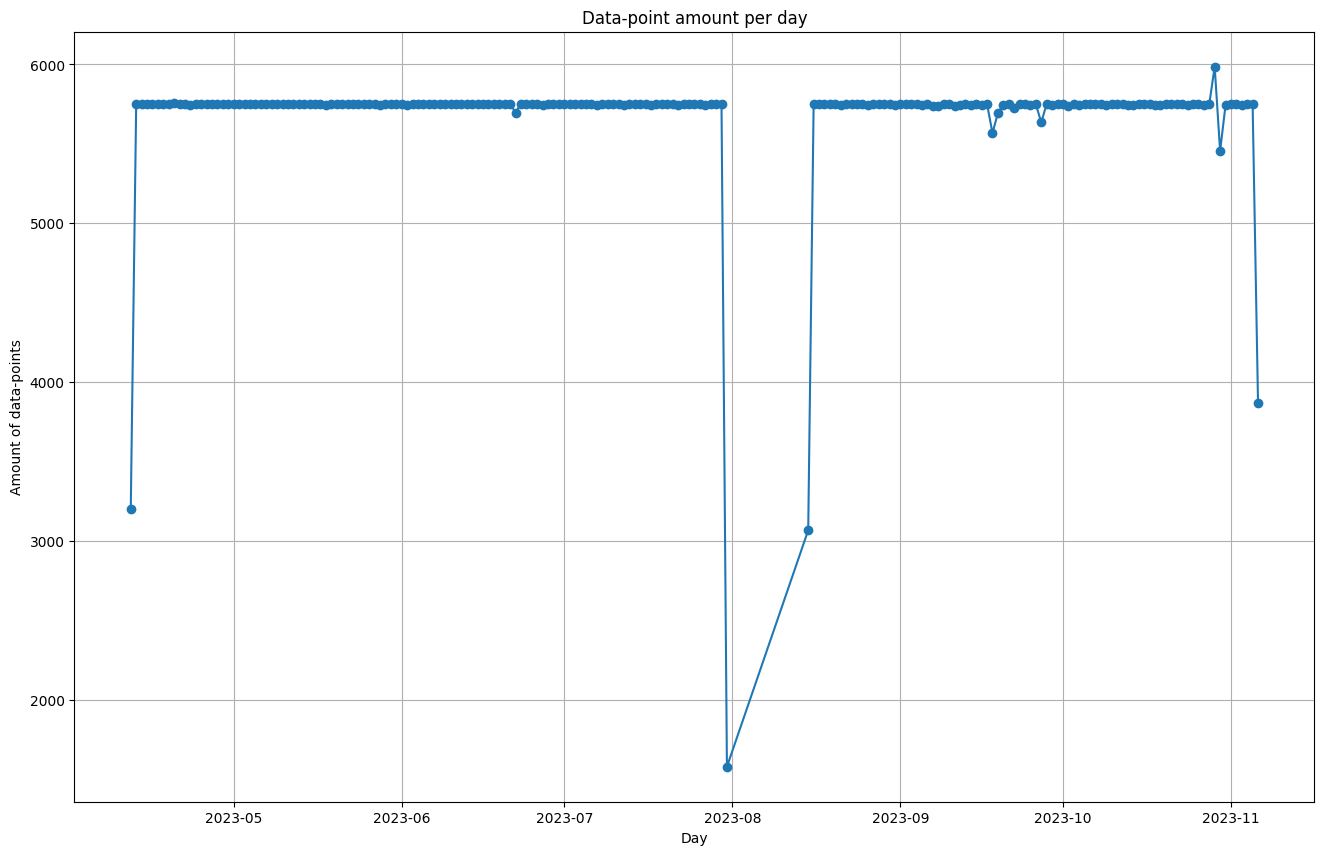

In [64]:
date_counts = origin_df['Zeitstempel'].dt.date.value_counts()
date_counts = date_counts.sort_index()

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[16, 10])
ax.set_title("Data-point amount per day")
ax.set_xlabel("Day")
ax.set_ylabel("Amount of data-points")
ax.plot(date_counts.index, date_counts, 'o-')
ax.grid()

plt.savefig(f'./results/self/{MACHINE_NAME} Data-point amount per day.png', transparent=PLOT_TRANSPARENT)

In [65]:
[print(i) for i in df["Zeitstempel"].unique()];

2023-04-12 10:30:00
2023-04-12 10:45:00
2023-04-12 11:00:00
2023-04-12 11:15:00
2023-04-12 11:30:00
2023-04-12 11:45:00
2023-04-12 12:00:00
2023-04-12 12:15:00
2023-04-12 12:30:00
2023-04-12 12:45:00
2023-04-12 13:00:00
2023-04-12 13:15:00
2023-04-12 13:30:00
2023-04-12 13:45:00
2023-04-12 14:00:00
2023-04-12 14:15:00
2023-04-12 14:30:00
2023-04-12 14:45:00
2023-04-12 15:00:00
2023-04-12 15:15:00
2023-04-12 15:30:00
2023-04-12 15:45:00
2023-04-12 16:00:00
2023-04-12 16:15:00
2023-04-12 16:30:00
2023-04-12 16:45:00
2023-04-12 17:00:00
2023-04-12 17:15:00
2023-04-12 17:30:00
2023-04-12 17:45:00
2023-04-12 18:00:00
2023-04-12 18:15:00
2023-04-12 18:30:00
2023-04-12 18:45:00
2023-04-12 19:00:00
2023-04-12 19:15:00
2023-04-12 19:30:00
2023-04-12 19:45:00
2023-04-12 20:00:00
2023-04-12 20:15:00
2023-04-12 20:30:00
2023-04-12 20:45:00
2023-04-12 21:00:00
2023-04-12 21:15:00
2023-04-12 21:30:00
2023-04-12 21:45:00
2023-04-12 22:00:00
2023-04-12 22:15:00
2023-04-12 22:30:00
2023-04-12 22:45:00


In [66]:
df["Zeitstempel"].dt.strftime("%d.%m.%Y").unique()

array(['12.04.2023', '13.04.2023', '14.04.2023', '15.04.2023',
       '16.04.2023', '17.04.2023', '18.04.2023', '19.04.2023',
       '20.04.2023', '21.04.2023', '22.04.2023', '23.04.2023',
       '24.04.2023', '25.04.2023', '26.04.2023', '27.04.2023',
       '28.04.2023', '29.04.2023', '30.04.2023', '01.05.2023',
       '02.05.2023', '03.05.2023', '04.05.2023', '05.05.2023',
       '06.05.2023', '07.05.2023', '08.05.2023', '09.05.2023',
       '10.05.2023', '11.05.2023', '12.05.2023', '13.05.2023',
       '14.05.2023', '15.05.2023', '16.05.2023', '17.05.2023',
       '18.05.2023', '19.05.2023', '20.05.2023', '21.05.2023',
       '22.05.2023', '23.05.2023', '24.05.2023', '25.05.2023',
       '26.05.2023', '27.05.2023', '28.05.2023', '29.05.2023',
       '30.05.2023', '31.05.2023', '01.06.2023', '02.06.2023',
       '03.06.2023', '04.06.2023', '05.06.2023', '06.06.2023',
       '07.06.2023', '08.06.2023', '09.06.2023', '10.06.2023',
       '11.06.2023', '12.06.2023', '13.06.2023', '14.06

Results:<br>
There are a few days with fewer values, should be fine with null replacement. The august is suspicious. There have to be an brek of measurement.

Of course there are not so many values on the start and the end of the measurement. 

The resampled data with the handled missing values seems very good.

---
### Time Coverage

Gaps

[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

In [67]:

# Create a new DateTimeIndex with the full range of dates
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=get_frequency(df))
full_range_df = pd.DataFrame(full_range, index=full_range)

# Find the difference between the full range and the actual DataFrame index
missing_dates = full_range.difference(df.index)
missing_dates_df = pd.DataFrame(missing_dates, index=missing_dates)

missing_dates_df

Empty DataFrame
Columns: [0]
Index: []

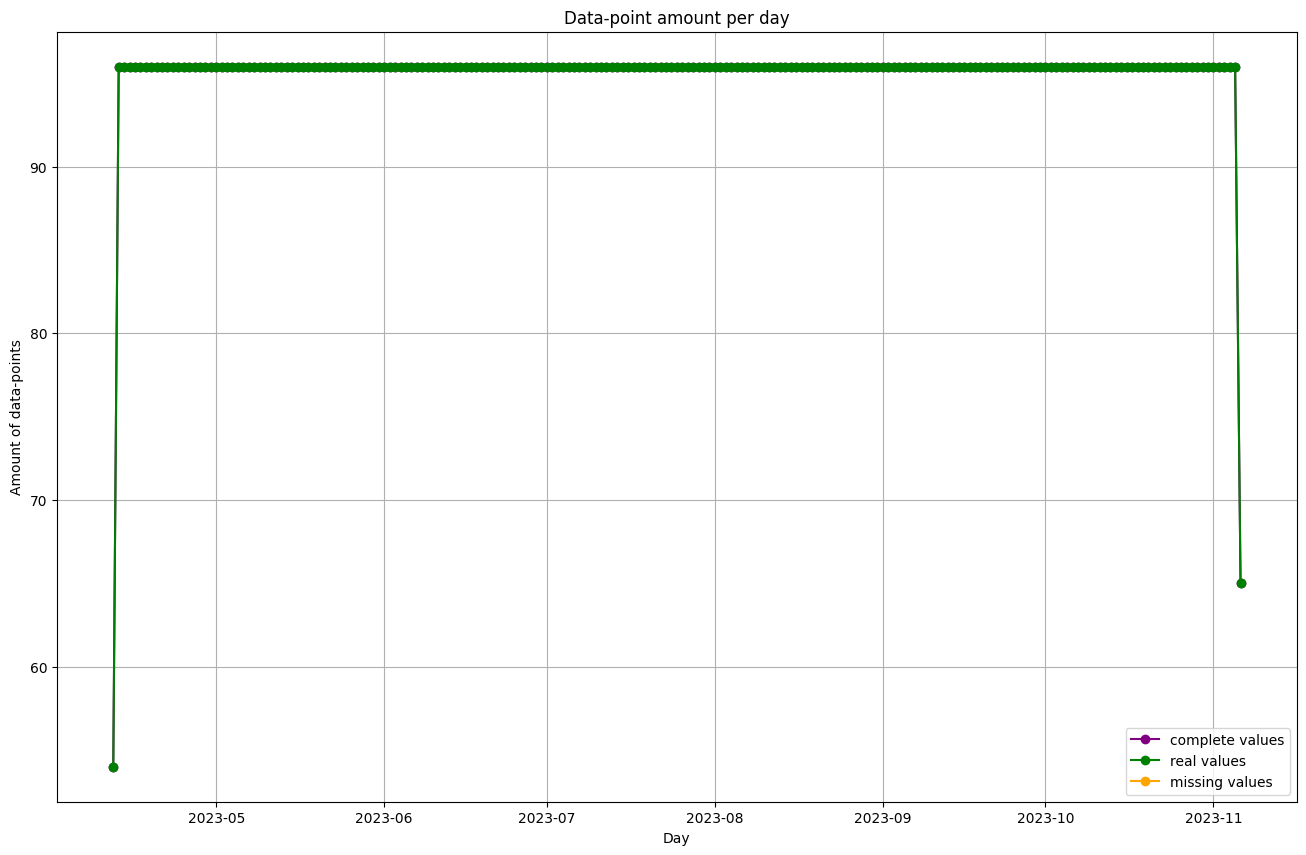

In [68]:
date_counts_full = full_range_df[0].dt.date.value_counts()
date_counts_full = date_counts_full.sort_index()
date_counts_missing = missing_dates_df[0].dt.date.value_counts()
date_counts_missing = date_counts_missing.sort_index()
date_counts = df["Zeitstempel"].dt.date.value_counts()
date_counts = date_counts.sort_index()

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[16, 10])
ax.set_title("Data-point amount per day")
ax.set_xlabel("Day")
ax.set_ylabel("Amount of data-points")
ax.plot(date_counts_full.index, date_counts_full, 'o-', label="complete values", c="purple")
ax.plot(date_counts.index, date_counts, 'o-', label="real values", c="green")
ax.plot(date_counts_missing.index, date_counts_missing, 'o-', label="missing values", c="orange")
ax.grid()
ax.legend()

plt.savefig(f'./results/self/{MACHINE_NAME} Timeseries Coverage.png', transparent=PLOT_TRANSPARENT)

Results:<br>
No missing values (because of the resample and null handling). 

---
### Coverage / Null Check

- Are there suspicous Null values?
- How many Null Values?


[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

In [69]:
null_counts = df.isnull().sum()
null_counts_percentage = null_counts.apply(lambda x:round((x/ROWS)*100, 2))
null_df = pd.concat([null_counts.rename("Nulls"), null_counts_percentage.rename("Nulls in Percentage")], axis=1).sort_values(by="Nulls", ascending=False)
display(null_df, amount=-1, reset_index=False)

In [70]:
null_counts = origin_df.isnull().sum()
null_counts_percentage = null_counts.apply(lambda x:round((x/ORIGIN_ROWS)*100, 2))
null_df = pd.concat([null_counts.rename("Nulls"), null_counts_percentage.rename("Nulls in Percentage")], axis=1).sort_values(by="Nulls", ascending=False)
display(null_df, amount=-1, reset_index=False)

Solving Nulls in Target

In [71]:
df[TARGET].fillna(df[TARGET].mean())

Zeitstempel
2023-04-12 10:30:00      135.448261
2023-04-12 10:45:00      139.064500
2023-04-12 11:00:00      146.639500
2023-04-12 11:15:00      152.389333
2023-04-12 11:30:00    66261.830167
                           ...     
2023-11-06 15:00:00    69686.873958
2023-11-06 15:15:00    17953.921000
2023-11-06 15:30:00    10442.022167
2023-11-06 15:45:00    35571.059833
2023-11-06 16:00:00    87244.877660
Name: Ges. Wirkleistung, Length: 19991, dtype: float64

In [72]:
# Mean? Sliding Mean? Last Value? Remove?
#if DOWNSAMPLING == False:
df = handle_nulls(df, cols=COLUMNS, display_result=True)

Drop not useful columns

In [73]:
df = df.drop(columns=["Blindarbeit_Abgabe", "Blindarbeit_Bezug", "Wirkarbeit_Bezug", "Wirkarbeit_Abgabe", "Netzfrequenz", "Leistungsfaktor"])    # axis 1
COLUMNS = df.columns

Result:<br>
The columns Blindarbeit_Abgabe, Blindarbeit_Bezug, Wirkarbeit_Bezug, Wirkarbeit_Abgabe, Netzfrequenz and Leistungsfaktor have a massive amount of missing values and should be droped.

The rest of the columns have only a few null values. The downsampling process created also new missing values. That should be reasoned of the missing values from 31.07.2023 06:36:30 to 15.08.2023 11:13:15. 

---
### Duplicates


[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

In [74]:
duplicats_ = df.duplicated(keep=False)
duplicats = df[duplicats_]
sum_duplicates = sum(duplicats_)
sum_duplicates_percentage = round((sum_duplicates/ROWS)*100, 2)

duplicats_without_none_ = df.dropna(how="all").duplicated(keep=False)
duplicats_without_none = df.dropna(how="all")[duplicats_without_none_]
sum_duplicates_without_none = sum(duplicats_without_none_)
sum_duplicates_percentage_without_none = round((sum_duplicates_without_none/ROWS)*100, 2)

print(f"Duplicate rows: {sum_duplicates_percentage}% ({sum_duplicates:n} rows)")
print(f"Duplicate rows without none-rows: {sum_duplicates_percentage_without_none}% ({sum_duplicates_without_none:n} rows)")

Duplicate rows: 0.0% (0 rows)
Duplicate rows without none-rows: 0.0% (0 rows)


In [75]:
duplicats_ = origin_df.duplicated(keep=False)
duplicats = origin_df[duplicats_]
sum_duplicates = sum(duplicats_)
sum_duplicates_percentage = round((sum_duplicates/ORIGIN_ROWS)*100, 2)

duplicats_without_none_ = origin_df.dropna(how="all").duplicated(keep=False)
duplicats_without_none = origin_df.dropna(how="all")[duplicats_without_none_]
sum_duplicates_without_none = sum(duplicats_without_none_)
sum_duplicates_percentage_without_none = round((sum_duplicates_without_none/ORIGIN_ROWS)*100, 2)

print(f"Duplicate rows: {sum_duplicates_percentage}% ({sum_duplicates:n} rows)")
print(f"Duplicate rows without none-rows: {sum_duplicates_percentage_without_none}% ({sum_duplicates_without_none:n} rows)")

Duplicate rows: 0.0% (0 rows)
Duplicate rows without none-rows: 0.0% (0 rows)


Results:<br>
No duplicate values, very good.

---
### Reports

-> Auto generated<br>
-> [res](https://medium.com/@ThomTechSavvy/data-analysis-with-a-single-line-of-code-using-advanced-python-libraries-automate-your-eda-and-e1e3fb2ed110)


[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

In [76]:
# !pip install dtale
# !pip install sweetviz
# !pip install ydata-profiling
# !pip install autoviz

In [77]:
#dtale.show(df).open_browser()

In [78]:
# sv.analyze(df , target_feat=TARGET).show_html('./results/analysis_with_sweetviz.html', scale=0.92)

In [79]:
#ProfileReport(df,  minimal=True, title="DATA ANALYSIS REPORT").to_file(output_file='./results/analysis_with_profile_report.html')

In [80]:
# AutoViz_Class().AutoViz("", dfte=df, header=0, verbose=1, lowess=False,
#       chart_format="html", max_rows_analyzed=10000, max_cols_analyzed=10,
#       save_plot_dir="./results")

Results:<br>
...

---
### Statistics about the data

- Row/data point amount
- Timespace
- Mean/Median/...
- ...


[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

In [81]:
df.describe()

Ges. Blindleistung  Ges. Scheinleistung  Ges. Wirkleistung  \
count        19991.000000         19991.000000       19991.000000   
mean           235.082329         22042.101753       14230.253445   
min         -19391.892000           529.885167          90.015333   
25%          -1068.191333           692.924277         458.566500   
50%           -120.696167          1785.297500         995.099620   
75%            138.034396         16317.146500       10562.523917   
max          18990.842667        168830.245000      105354.480167   
std           2853.266884         40339.730545       26397.617947   

           Strom L1      Strom L2      Strom L3                    Zeitstempel  
count  19991.000000  19991.000000  19991.000000                          19991  
mean      32.459406     32.005328     30.944651  2023-07-25 13:14:59.999999744  
min        1.047833      0.576333      0.000000            2023-04-12 10:30:00  
25%        1.264000      1.230000      0.000000            2023-06-03 11:52:30  
50%        3.879245      3.544667      1.112833            2023-07-25 13:15:00  
75%       24.118500     23.471167     22.532833            2023-09-15 14:37:30  
max      241.069667    238.049667    244.842667            2023-11-06 16:00:00  
std       58.156393     57.996478     58.585471                            NaN

In [82]:
origin_df.describe()

Zeitstempel  Blindarbeit_Abgabe  Blindarbeit_Bezug  \
count                        1109639        5.553800e+04       5.553800e+04   
mean   2023-07-24 11:20:35.868895488        2.185839e+06       2.700501e+06   
min              2023-04-12 10:39:15        9.052314e+04       1.155600e+05   
25%       2023-05-30 16:04:07.500000        1.295620e+06       1.412161e+06   
50%              2023-07-17 21:46:15        2.002078e+06       2.613971e+06   
75%       2023-09-19 09:08:22.500000        3.027216e+06       3.765700e+06   
max              2023-11-06 16:11:30        4.633799e+06       5.964114e+06   
std                              NaN        1.258675e+06       1.526086e+06   

       Ges. Blindleistung  Ges. Scheinleistung  Ges. Wirkleistung  \
count        1.109344e+06         1.109345e+06       1.109344e+06   
mean         2.848668e+02         2.368341e+04       1.528788e+04   
min         -4.135846e+04         4.259800e+02       3.514000e+01   
25%         -1.088020e+03         5.883200e+02       4.527500e+02   
50%          1.215300e+02         1.830610e+03       1.120510e+03   
75%          1.394800e+02         1.652788e+04       1.078058e+04   
max          2.874206e+04         3.097731e+05       1.904848e+05   
std          4.135285e+03         4.418625e+04       2.880447e+04   

       Leistungsfaktor  Netzfrequenz      Strom L1      Strom L2  \
count    277591.000000  87820.000000  1.109344e+06  1.109347e+06   
mean          0.599267     50.005082  3.481955e+01  3.433060e+01   
min           0.120000     49.880000  9.100000e-01  4.500000e-01   
25%           0.450000     49.990000  1.240000e+00  1.210000e+00   
50%           0.650000     50.010000  3.940000e+00  3.880000e+00   
75%           0.800000     50.020000  2.441000e+01  2.404000e+01   
max           0.820000     50.120000  4.485800e+02  4.434800e+02   
std           0.194664      0.022588  6.374622e+01  6.357963e+01   

           Strom L3  Wirkarbeit_Abgabe  Wirkarbeit_Bezug  
count  1.109348e+06       55539.000000      5.553800e+04  
mean   3.336636e+01          16.704309      3.385759e+07  
min    0.000000e+00          16.700000      1.124268e+06  
25%    0.000000e+00          16.700000      1.960157e+07  
50%    1.140000e+00          16.700000      3.292628e+07  
75%    2.274000e+01          16.710000      4.669927e+07  
max    4.405500e+02          16.710000      7.199468e+07  
std    6.414056e+01           0.004952      1.836412e+07

In [83]:
np.arange(-50000, 200000, 10000)

array([-50000, -40000, -30000, -20000, -10000,      0,  10000,  20000,
        30000,  40000,  50000,  60000,  70000,  80000,  90000, 100000,
       110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000,
       190000])

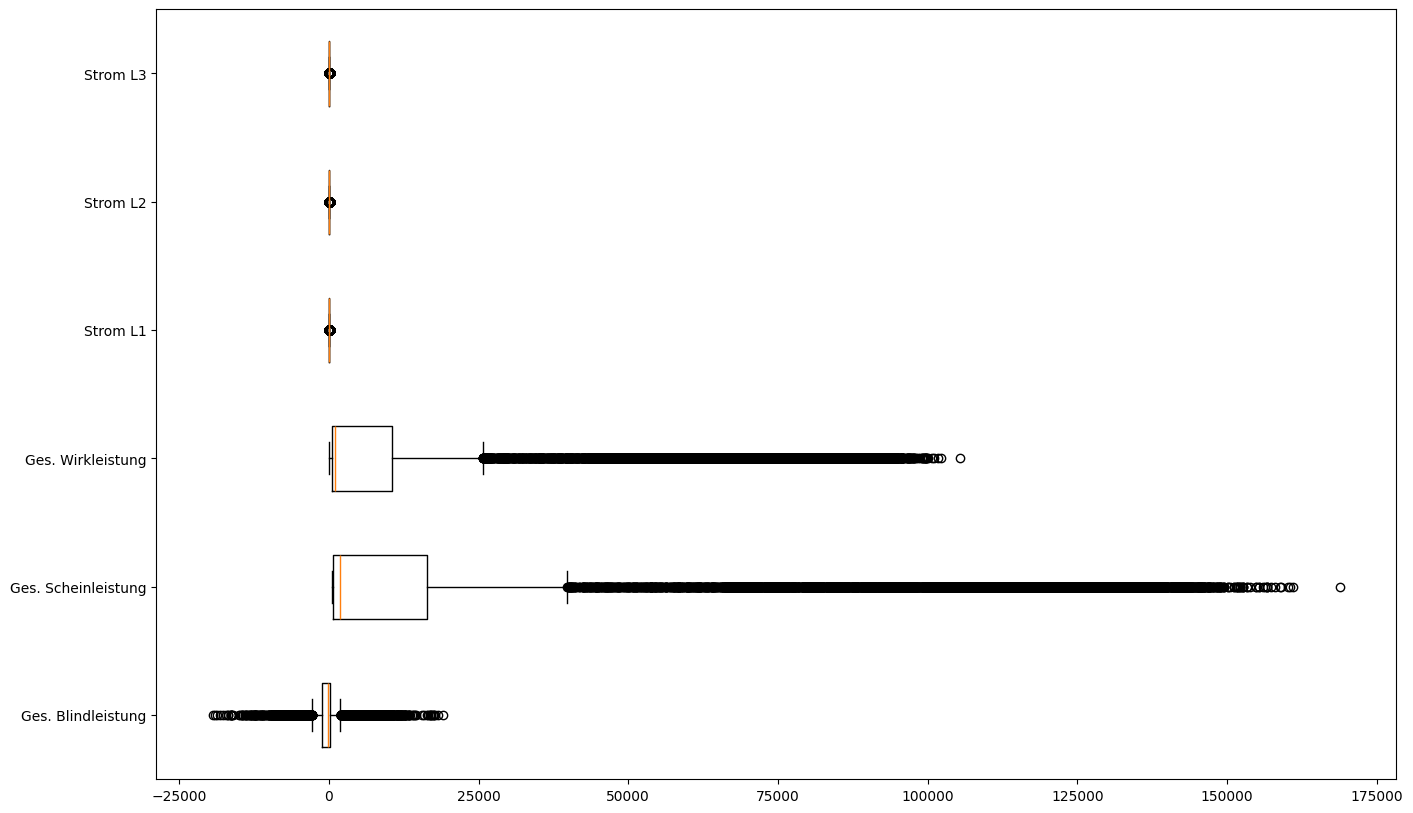

In [84]:
data_list = list()
column_name_list = list()
for cur_col in COLUMNS:
    if cur_col != "Zeitstempel":
        data_list += [df[cur_col]]   # .fillna(df[cur_col].mean())
        column_name_list += [cur_col]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.boxplot(data_list, vert=False)
ax.set_yticks(np.arange(1, len(column_name_list)+1), labels=column_name_list)
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.show()

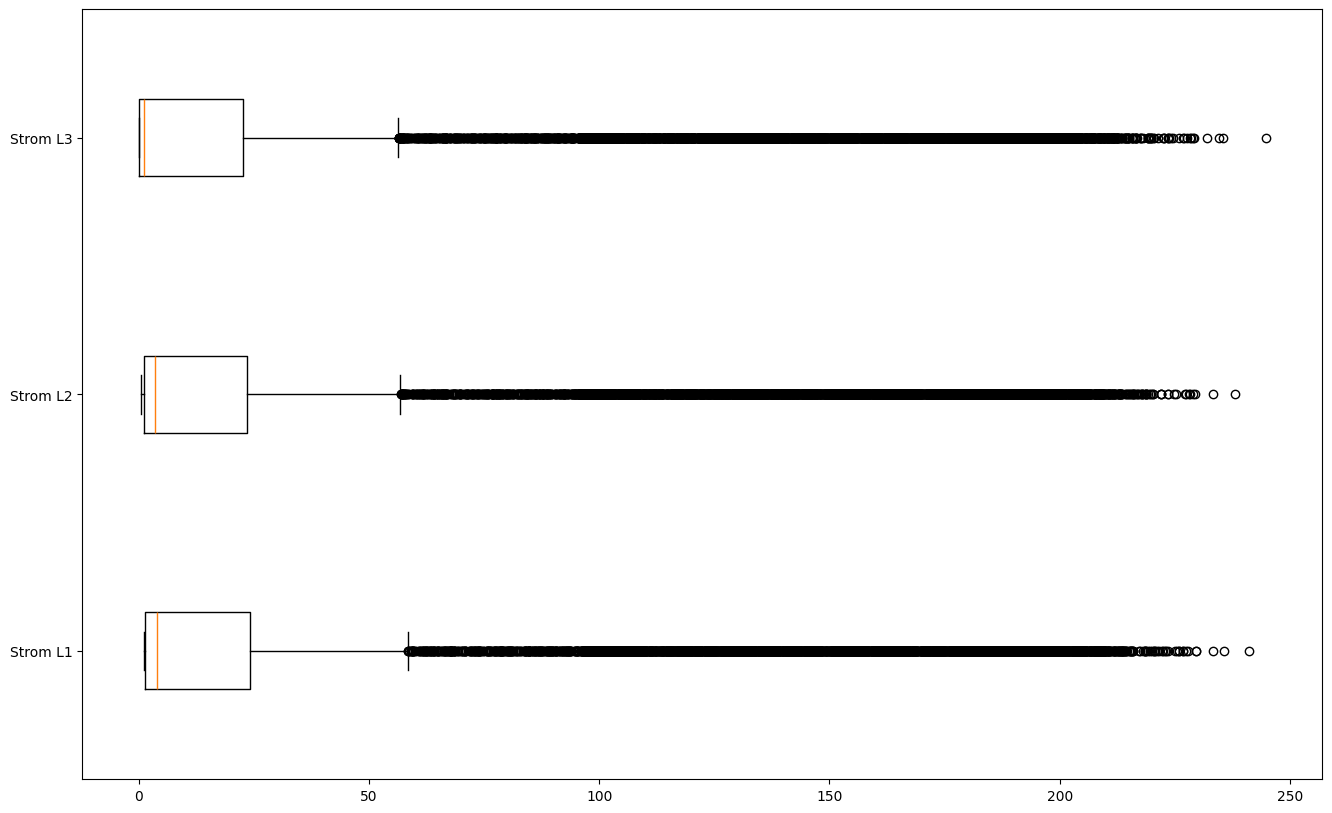

In [85]:
data_list = list()
column_name_list = list()
for cur_col in COLUMNS:
    if cur_col not in ["Wirkarbeit", "Blindarbeit", "Zeitstempel", "Ges. Wirkleistung", "Ges. Scheinleistung", "Ges. Blindleistung"]:
        data_list += [df[cur_col]]  # .fillna(df[cur_col].mean())
        column_name_list += [cur_col]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.boxplot(data_list, vert=False, showfliers=True)
ax.set_yticks(np.arange(1, len(column_name_list)+1), labels=column_name_list)
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.show()

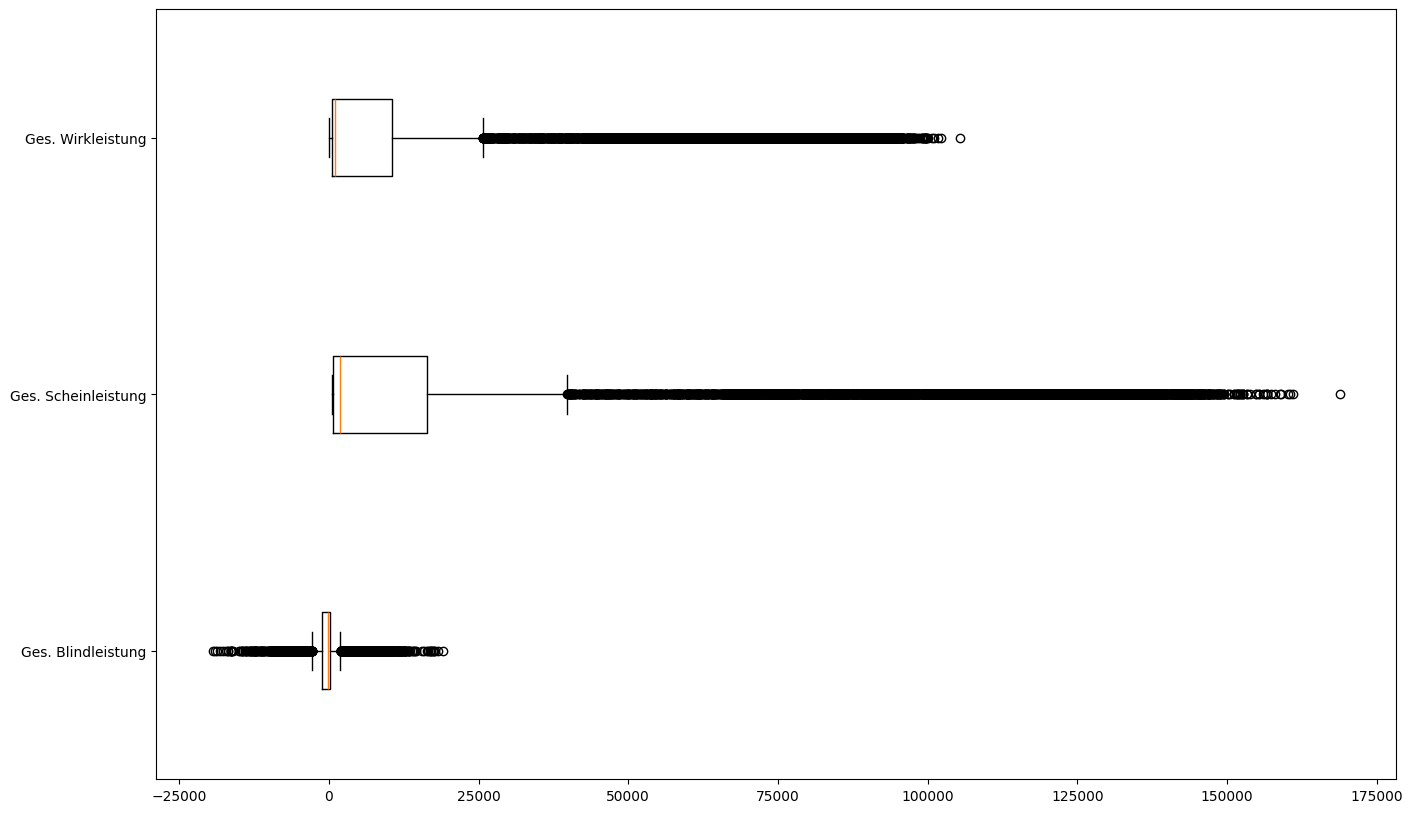

In [86]:
data_list = list()
column_name_list = list()
for cur_col in COLUMNS:
    if cur_col in ["Ges. Wirkleistung", "Ges. Scheinleistung", "Ges. Blindleistung"]:
        data_list += [df[cur_col]]   # .fillna(df[cur_col].mean())
        column_name_list += [cur_col]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.boxplot(data_list, vert=False, showfliers=True)
ax.set_yticks(np.arange(1, len(column_name_list)+1), labels=column_name_list)
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.show()

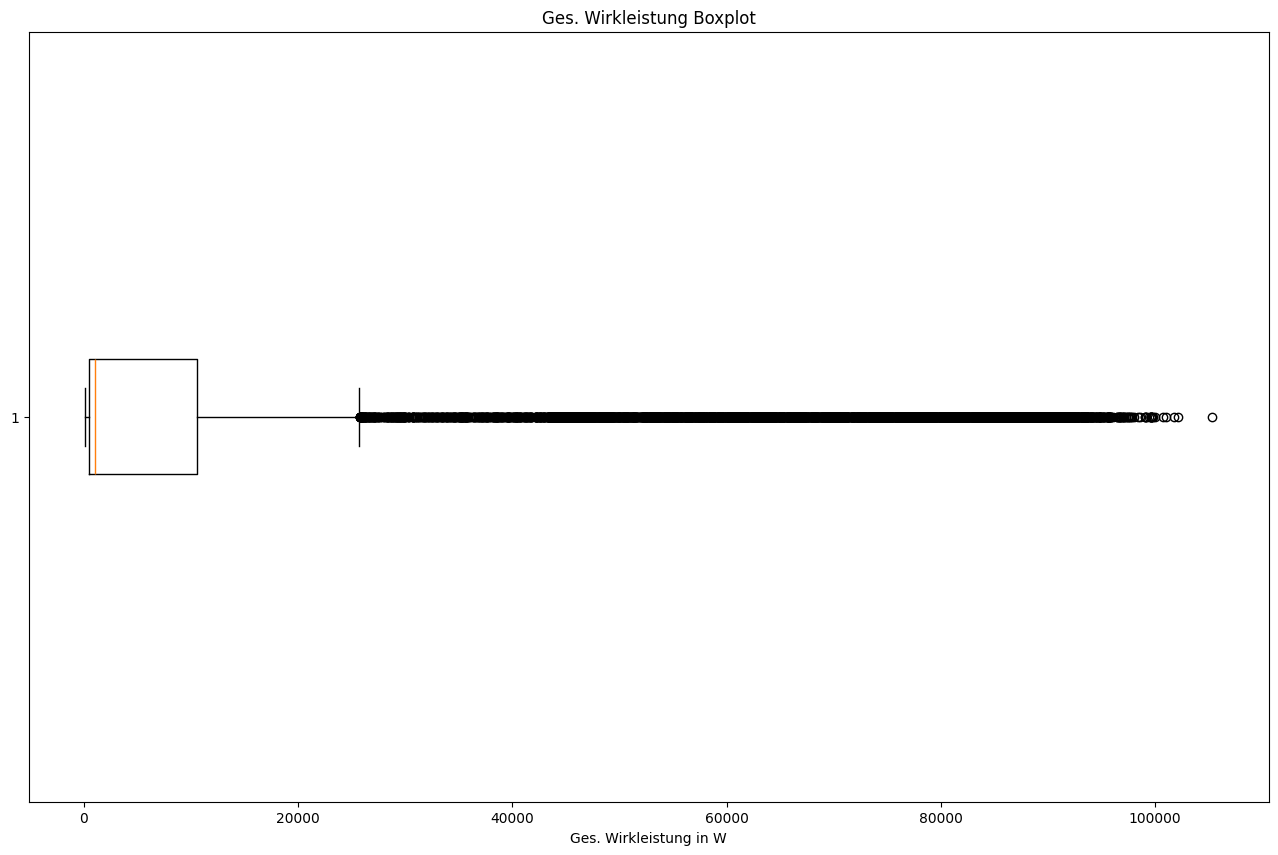

<Figure size 640x480 with 0 Axes>

In [87]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.boxplot(df[TARGET], vert=False, showfliers=True)
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
ax.set_title(f"{TARGET} Boxplot")
ax.set_xlabel(f"{TARGET} in W")

plt.show()
plt.savefig(f'./results/self/{MACHINE_NAME} {TARGET} Boxplot.png', transparent=PLOT_TRANSPARENT)

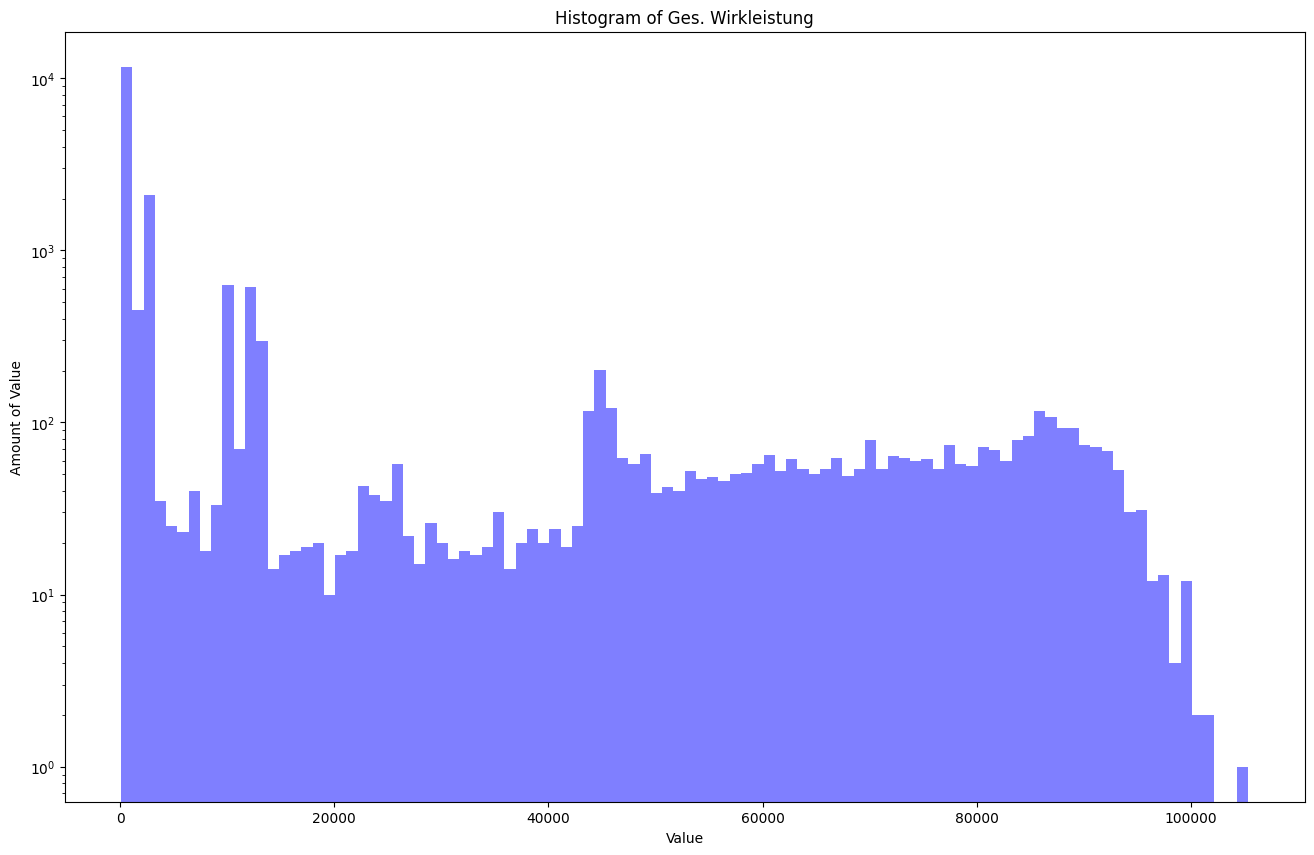

In [88]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.hist(df[TARGET], 100, facecolor='blue', alpha=0.5)
ax.set_xlabel("Value")
ax.set_ylabel("Amount of Value")
ax.set_title(f"Histogram of {TARGET}")
ax.set_yscale("log")
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

Results:<br>

The Ges. Wirkleistung has most likely values between 0-25.000 Watt and the Strom-features seem to have a similiar value range but much lower -> propably cause through the mesurement unit Ampere. But all 4 features have many outliers with much higher values.

---
### Correlation


[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

<Axes: >

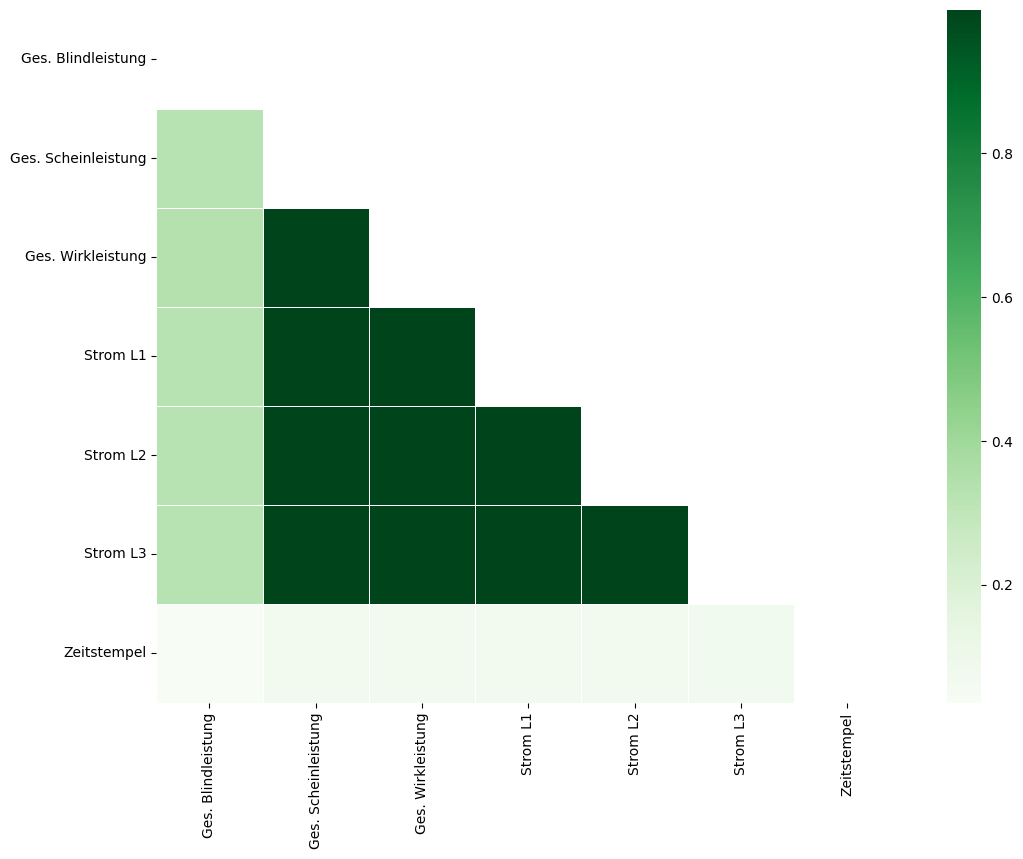

In [89]:
plt.figure(figsize = (12,9))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, linewidths=0.5, cmap="Greens", annot=False, mask=mask)

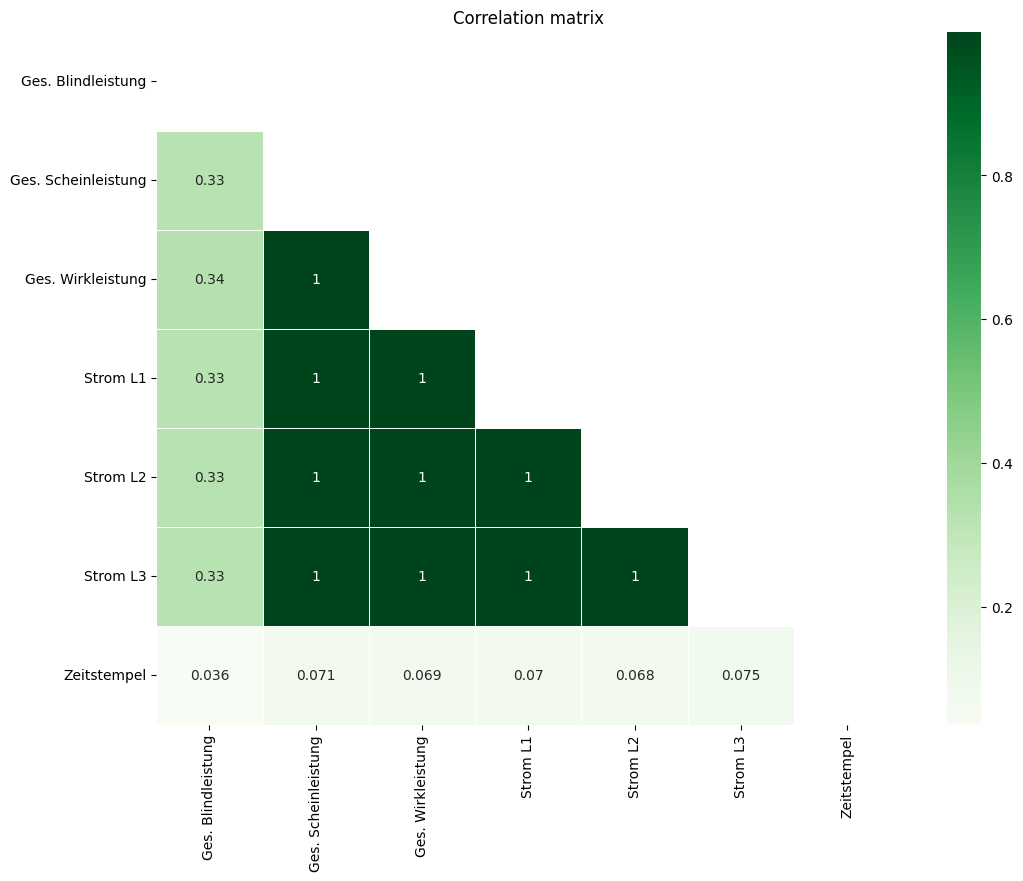

In [90]:
plt.figure(figsize = (12,9))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, linewidths=0.5, cmap="Greens", annot=True, mask=mask)
plt.title("Correlation matrix")
plt.savefig('./results/self/{MACHINE_NAME} correlation matrix.png', transparent=PLOT_TRANSPARENT)

Results:<br>
Massive Correlation from "Ges. Wirkleistung" with Strom L3, Strom L2, Strom L1 and Ges. Scheinleistung.<br>
They are to 100% correlated! In our case they should be related to each other. These can propably help predicting the right future values of the timeseries of "Ges. Wirkleistung". But maybe they don't offer new informations.

"Ges. Blindleistung" hs a very very low correlation to all other features. Maybe it can provide useful additional information.

---
### Outliers and Anomalies

-> Am Samstag gearbeitet?

-> Ressource: https://towardsdatascience.com/practical-guide-for-anomaly-detection-in-time-series-with-python-d4847d6c099f


[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

Taking values on the border of the distribution

In [91]:
mad = median_abs_deviation(df[TARGET])
median = np.median(df[TARGET])

def compute_robust_z_score(x):
    return 0.6745*(x-median) / mad

df['z-score'] = df[TARGET].apply(compute_robust_z_score)

df['outlier'] = 0

df.loc[df['z-score'] >= 3.5, 'outlier'] = 1 # Right-end tail
df.loc[df['z-score'] <=-3.5, 'outlier'] = -1 # Left-hand tail

outlier_amount = df.loc[df['outlier'] != 0, 'outlier'].count()
big_outliers_amount = df.loc[df['outlier'] > 0, 'outlier'].count()
small_outliers_amount = df.loc[df['outlier'] < 0, 'outlier'].count()

print(f"{outlier_amount} Outliers/Anomaly values => {round((outlier_amount/ROWS)*100, 2)}%")
print(f"    -> {big_outliers_amount} bigger Outliers/Anomaly values => {round((big_outliers_amount/ROWS)*100, 2)}%")
print(f"    -> {small_outliers_amount} smaller Outliers/Anomaly values => {round((small_outliers_amount/ROWS)*100, 2)}%")

outliers = df[df["outlier"] != 0]

del df['outlier']
del df['z-score']

5758 Outliers/Anomaly values => 28.8%
    -> 5758 bigger Outliers/Anomaly values => 28.8%
    -> 0 smaller Outliers/Anomaly values => 0.0%


In [92]:
display(outliers, amount=10, columns=[TARGET])

Other methods would be the LOF (Local Outlier Factor), the isolation forrest or even cluster methods like DBSCAN.<br>
Also Boxplots show Outliers

Results:<br>
The data includes many outliers. Which also can be seen in the boxplots ([click here to visit these](#Statistics-about-the-data))

---
### Stationarity

Stationary data have
- constant variance over time
- constant mean over time

<br><br>
Why is it important?<br>
It is important to know how "complex" the data is for the choice of the right method.

<br><br>
3 ways:
- Look at the visualized time-series
- Show Histogramm -> Guassian Distribution => Stationary
- Use Augmented Dickey-Fuller Test

<br><br>
Ressources:
- https://statologie.de/dickey-fuller-test-python/
- https://machinelearningmastery.com/time-series-data-stationary-python/


[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

**1. Visual**

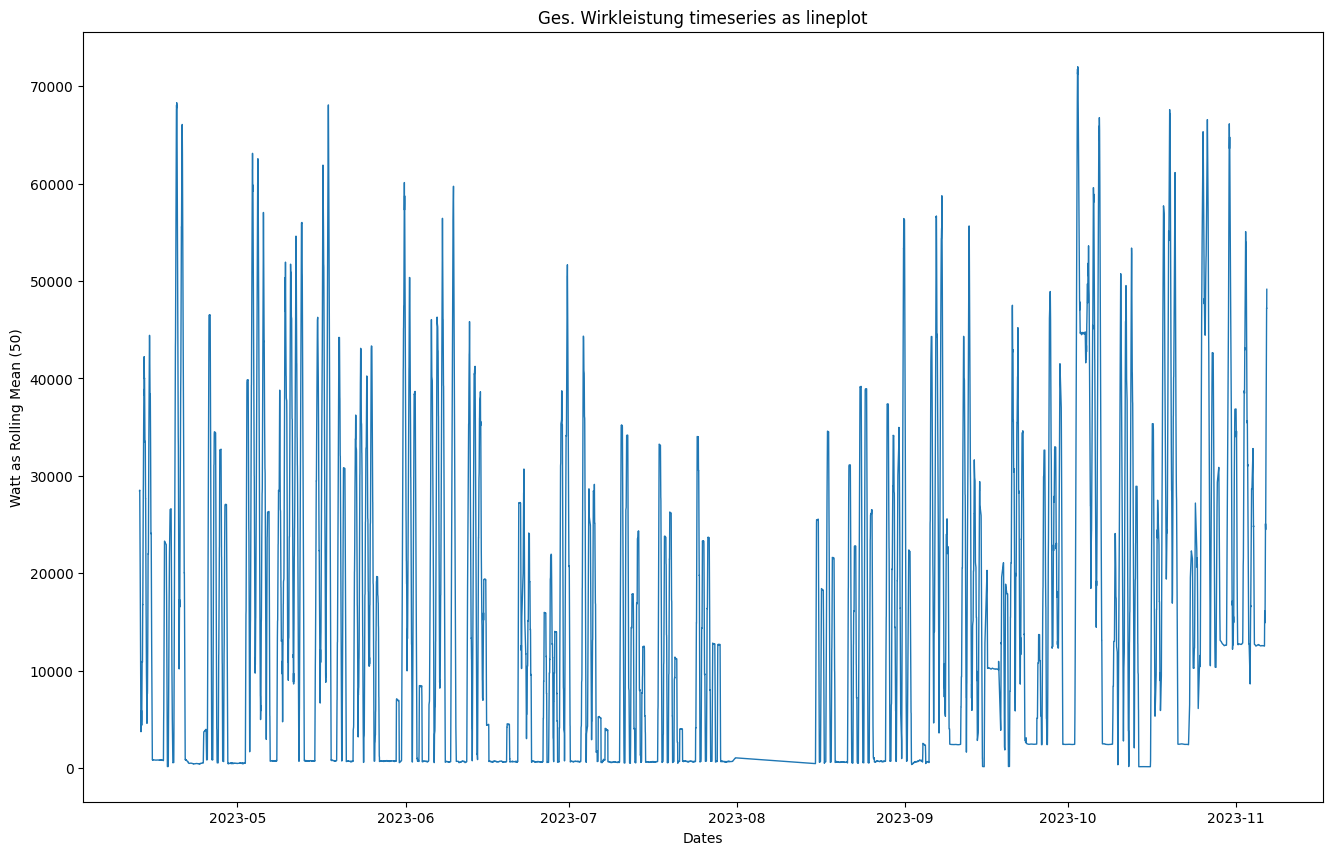

In [93]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.plot(df[TARGET].rolling(50).mean(), linewidth=1)
ax.set_title(f"{TARGET} timeseries as lineplot")
ax.set_ylabel(f"Watt as Rolling Mean (50)")
ax.set_xlabel(f"Dates")

plt.savefig(f'./results/self/{MACHINE_NAME} {TARGET} timeseries as lineplot.png', transparent=PLOT_TRANSPARENT)

=> Looks like non stationary data. The mean keeps not equal and the variance is also changing (depending on the window size). The newest data seems to change a little bit, so we should keep an eye on new data, propably there is a change in winter.

**2. Statistic Properties on sliding-window**

Without august because of the missing values

In [94]:
window_size = 1000

# remove the august
df_without_august = df.loc[df["Zeitstempel"].dt.month != 8, :]

# split
chunks = np.array_split(df_without_august[TARGET], indices_or_sections=ROWS//window_size)

print(f"{'Chunk':6} | {'Mean':9} | Varince")
for i, chunk in enumerate(chunks):
    print(f"{i+1:7}| {round(np.mean(chunk),2):9} | {round(np.var(chunk), 2)}")

Chunk  | Mean      | Varince
      1|  18201.32 | 893345917.26
      2|   8451.36 | 544488291.44
      3|  20894.94 | 1041057810.95
      4|  21950.76 | 1091078915.61
      5|  12493.57 | 661280034.78
      6|  16122.33 | 855098917.83
      7|  14581.86 | 722687624.55
      8|   5321.99 | 289294511.5
      9|  13225.69 | 681538108.13
     10|   8706.23 | 509752495.03
     11|   5956.12 | 351826153.42
     12|   7647.66 | 427762775.78
     13|  13941.82 | 729427508.76
     14|  15786.08 | 651733698.77
     15|   16267.9 | 656167293.73
     16|  25364.25 | 813791381.7
     17|  18410.56 | 843826569.99
     18|  25297.26 | 826693444.46
     19|  23753.56 | 565041207.82


=> looks like non stationar. The mean and the variance is changing. 

**3. Histogram**

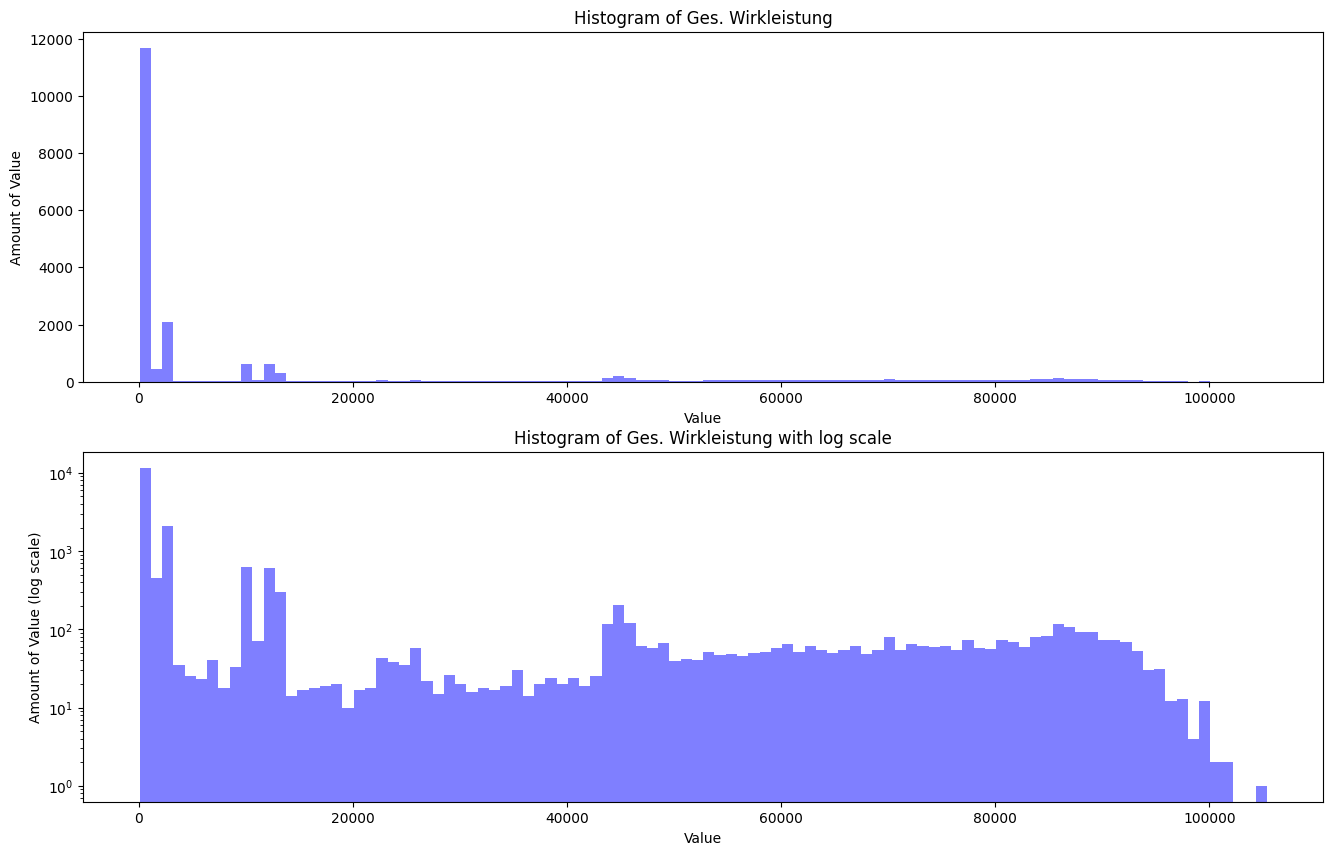

In [95]:
# df[TARGET].hist(bins=100)

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 10))

ax[0].hist(df[TARGET], 100, facecolor='blue', alpha=0.5)
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Amount of Value")
ax[0].set_title(f"Histogram of {TARGET}")
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax[0].xaxis.set_major_formatter(formatter)

ax[1].hist(df[TARGET], 100, facecolor='blue', alpha=0.5)
ax[1].set_xlabel("Value")
ax[1].set_ylabel("Amount of Value (log scale)")
ax[1].set_title(f"Histogram of {TARGET} with log scale")
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax[1].xaxis.set_major_formatter(formatter)
ax[1].set_yscale("log")

plt.savefig(f'./results/self/{MACHINE_NAME} Histogram of {TARGET}.png', transparent=PLOT_TRANSPARENT)

=> Not sure...Looks like the series is not stationary but it is not clear.

**4. Augmented Dickey-Fuller Test** 

Explained: Try to reject the H0 -> H0 = the data is non-stationary. Smaller ADF value mean propably a stationary series.
If p is smaller than 0,05 then the H0 is to be rejected and the timeseries is stationary.

In [96]:
result = adfuller(df[TARGET])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -21.042601
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The ADF-Test says surely a stationary time-series.

The AFD value is smaller than the critical values and the p-value is smaller than 5%.

Results:<br>
3 tests (lineplot, statistic property and histogram) shows that the timeseries is non stationary! <br>
The ADF-Test on the other side says that it is stationary.<br>
=> The timeseries is non stationary.

Notice that the newest data shows a new pattern. Keep an eye on the newest data, maybe the statistical properties of the timeseries changes in winter (over longer time).

---
### Visualize Data

Deactivate scientific notation in matplotlib:
```Python
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
```

Ressource: 
- Visual Analytics Vorlesung
- https://towardsdatascience.com/3-ways-to-visualize-time-series-you-may-not-know-c8572952ea9c

[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

**Ges. Wirkleistung**

classic

Text(0.5, 0, 'Date')

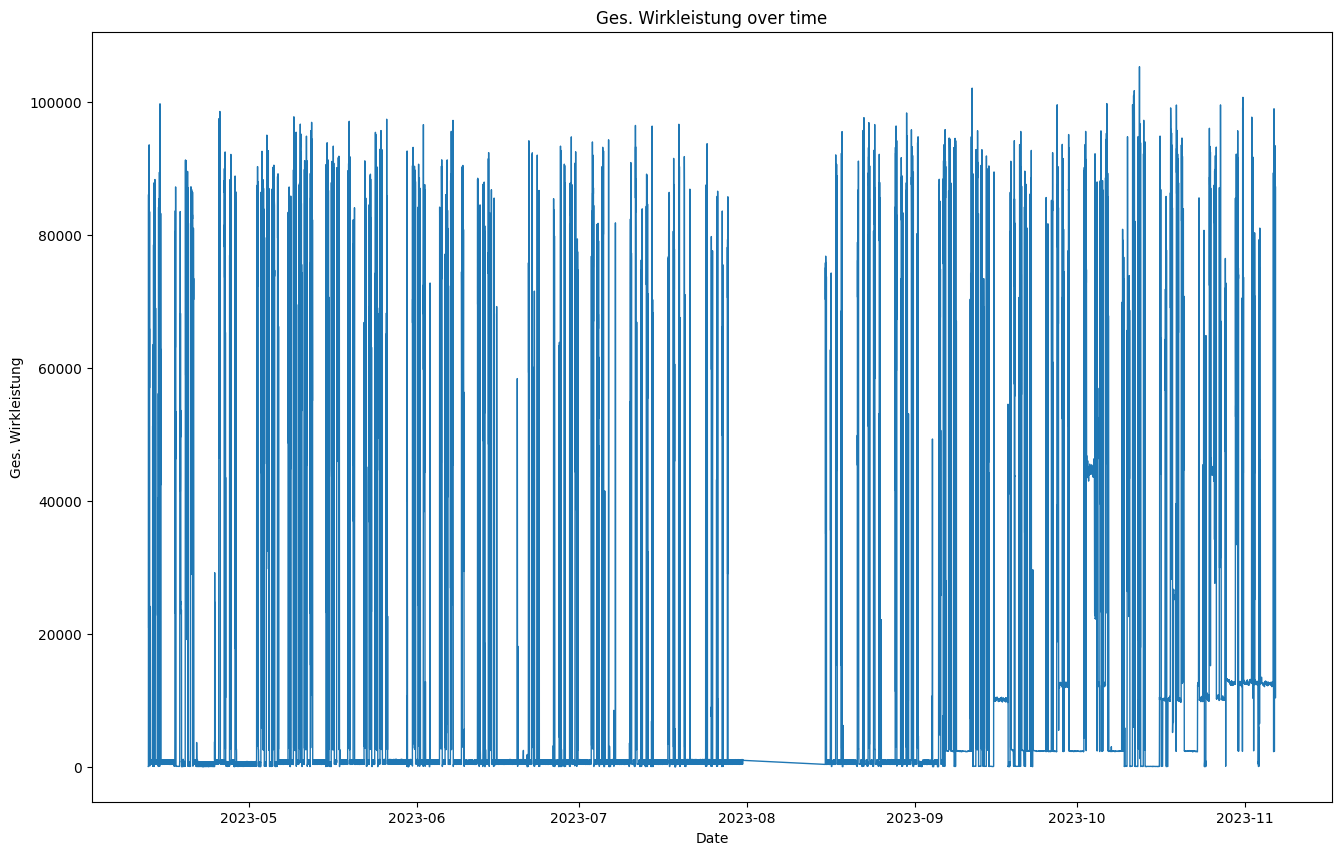

In [97]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.plot(df[TARGET], linewidth=1)
ax.set_title(f"{TARGET} over time")
ax.set_ylabel(f"{TARGET}")
ax.set_xlabel(f"Date")

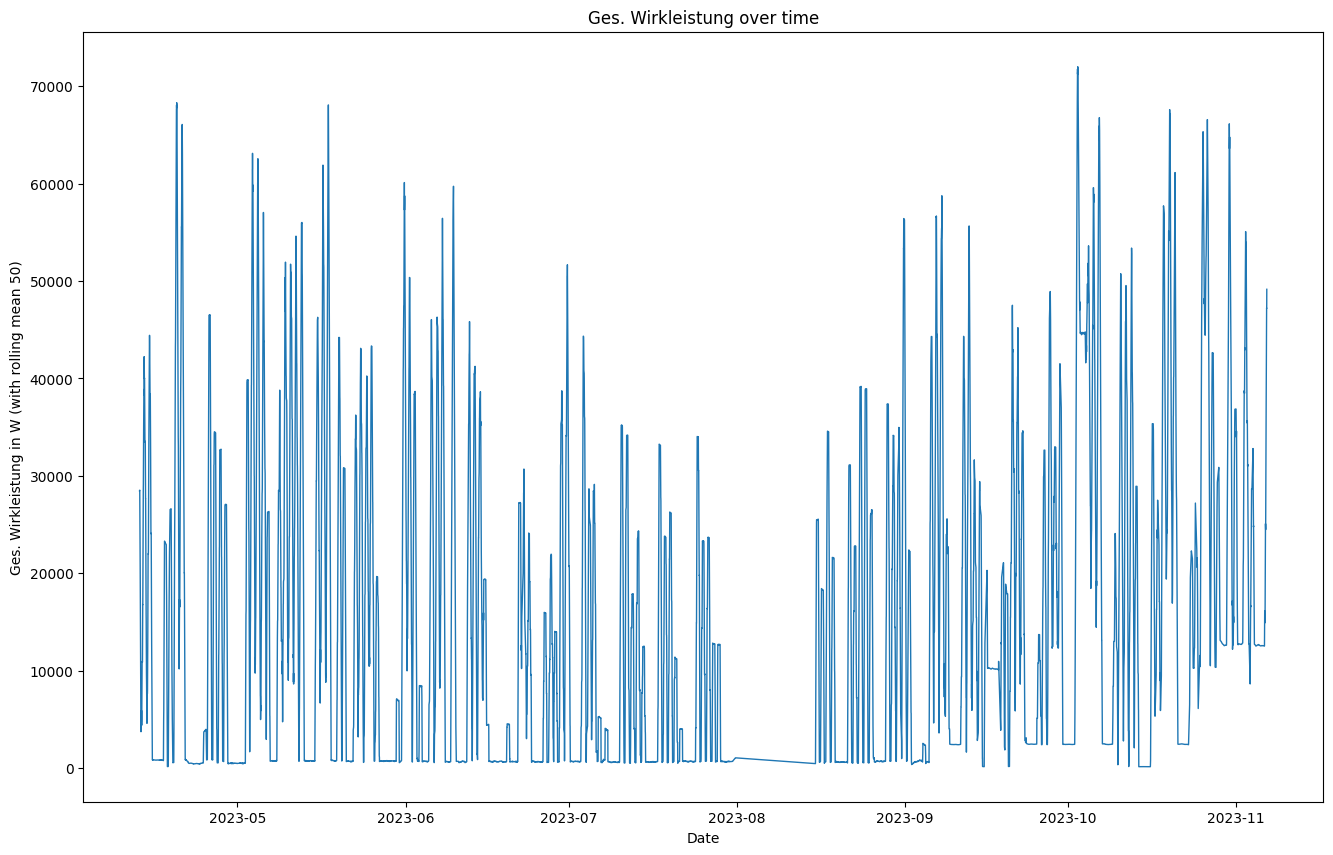

In [98]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.plot(df[TARGET].rolling(50).mean(), linewidth=1)
ax.set_title(f"{TARGET} over time")
ax.set_ylabel(f"{TARGET} in W (with rolling mean 50)")
ax.set_xlabel(f"Date")

plt.savefig(f'./results/self/{MACHINE_NAME} {TARGET} over time (lineplot).png', transparent=PLOT_TRANSPARENT)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


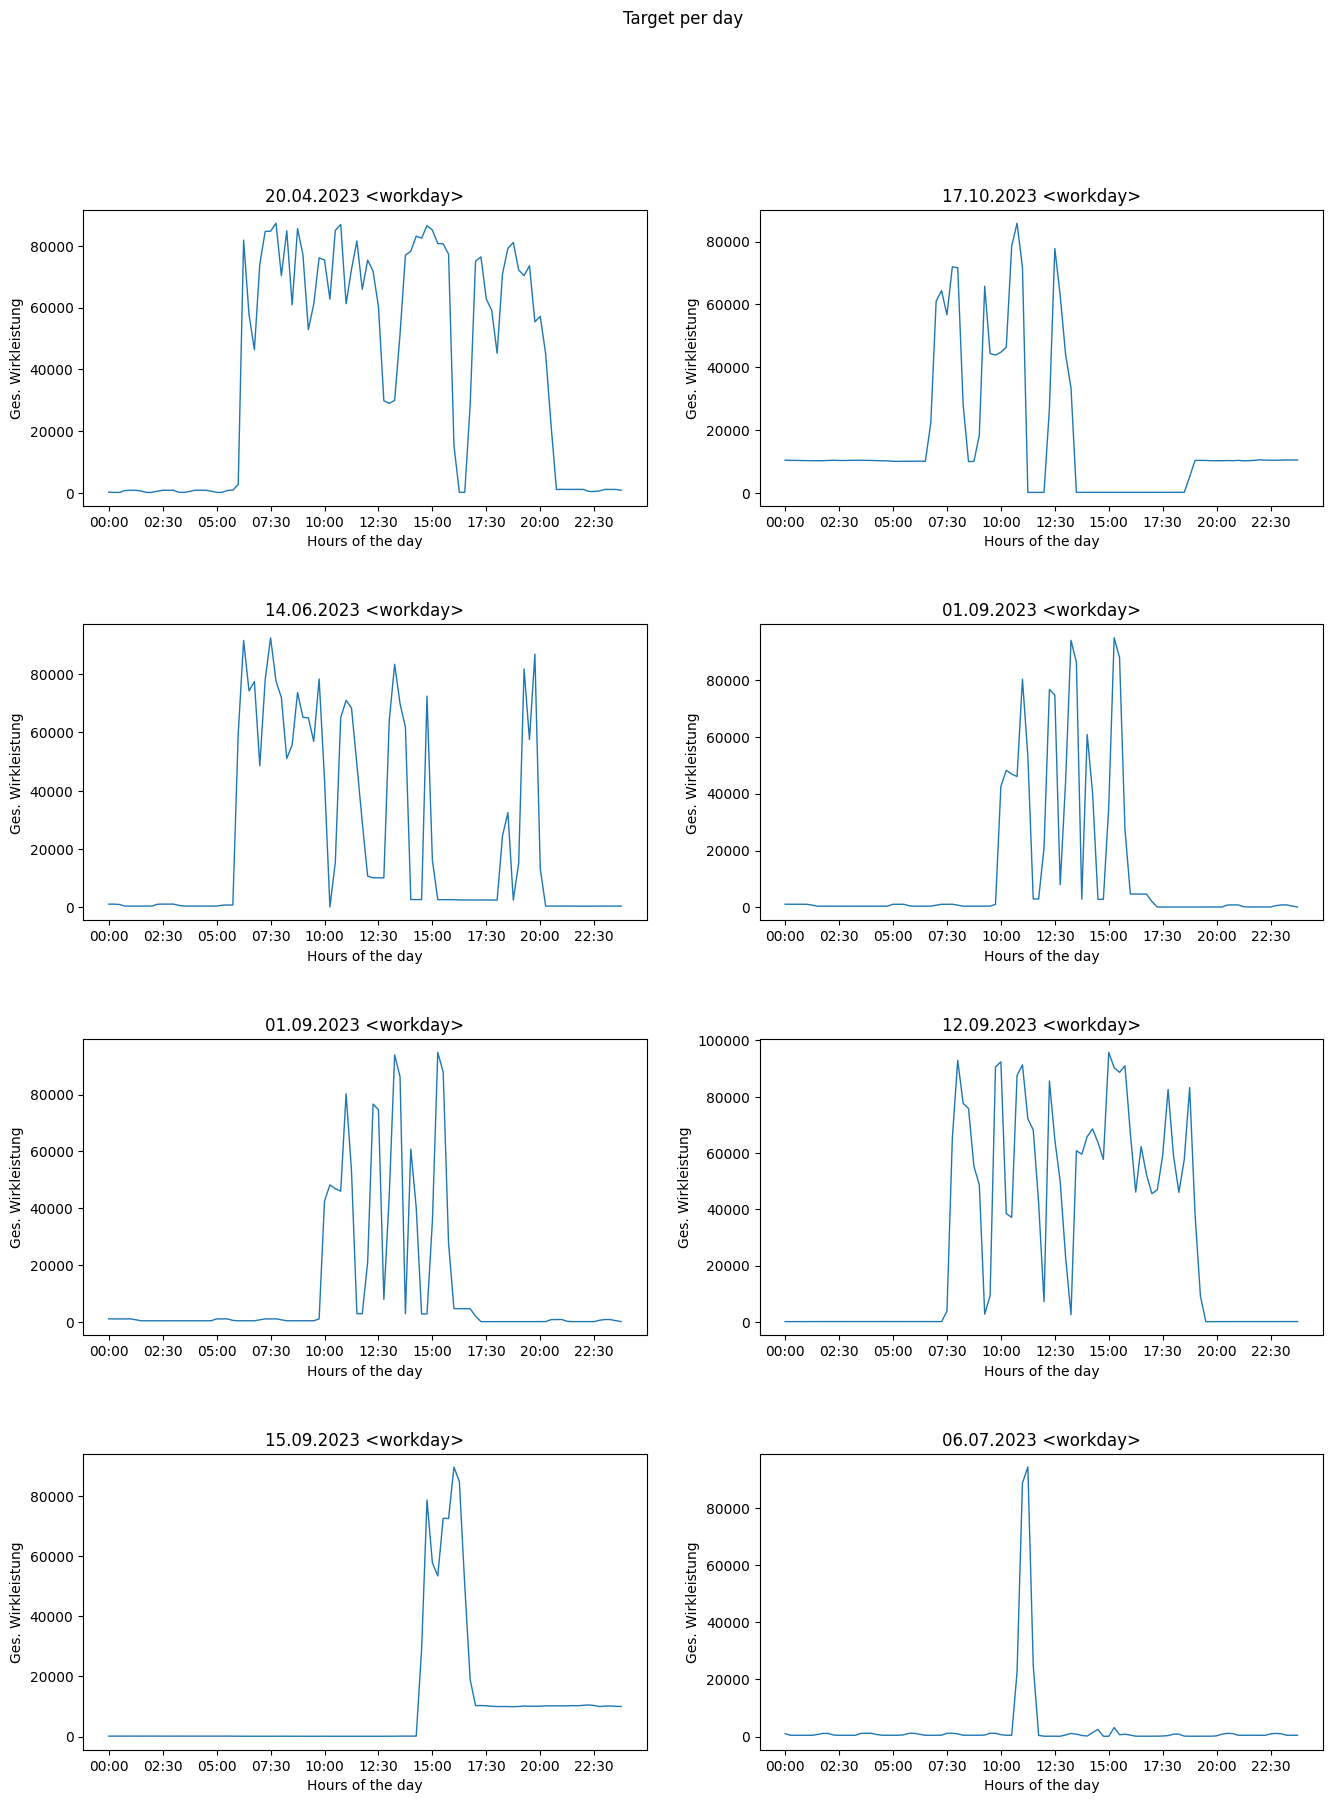

In [99]:
df_without_august = df.loc[df["Zeitstempel"].dt.month != 8, :]
df_without_august["date_str"] = df_without_august["Zeitstempel"].dt.strftime('%d.%m.%Y')
cur_date = np.random.choice(df_without_august["date_str"].unique(), 8)

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(16, 20), gridspec_kw={'hspace': 0.4})
fig.suptitle("Target per day")
for idx, cur_date_ in enumerate(cur_date):
    col = (idx+1)%2
    row = (idx-1)//2

    cache_df = df_without_august.loc[df_without_august["date_str"] == cur_date_, [TARGET, "date_str"]]
    cache_df.index = cache_df.index.strftime('%H:%M')
    ax[row, col].plot(cache_df[TARGET], linewidth=1)
    formatter = ticker.ScalarFormatter()
    formatter.set_scientific(False)
    ax[row, col].yaxis.set_major_formatter(formatter)
    ax[row, col].xaxis.set_major_formatter(formatter)
    ax[row, col].set_xticks(ax[row, col].get_xticks()[::10])
    ax[row, col].set_xticklabels(cache_df.index[::10])
    ax[row, col].set_ylabel(f"{TARGET}")
    ax[row, col].set_title(f"{cur_date_} <{check_day_type(cur_date_)}>")
    ax[row, col].set_xlabel(f"Hours of the day")

plt.savefig(f'./results/self/{MACHINE_NAME} Target per day.png', transparent=PLOT_TRANSPARENT)

del cache_df

For one week

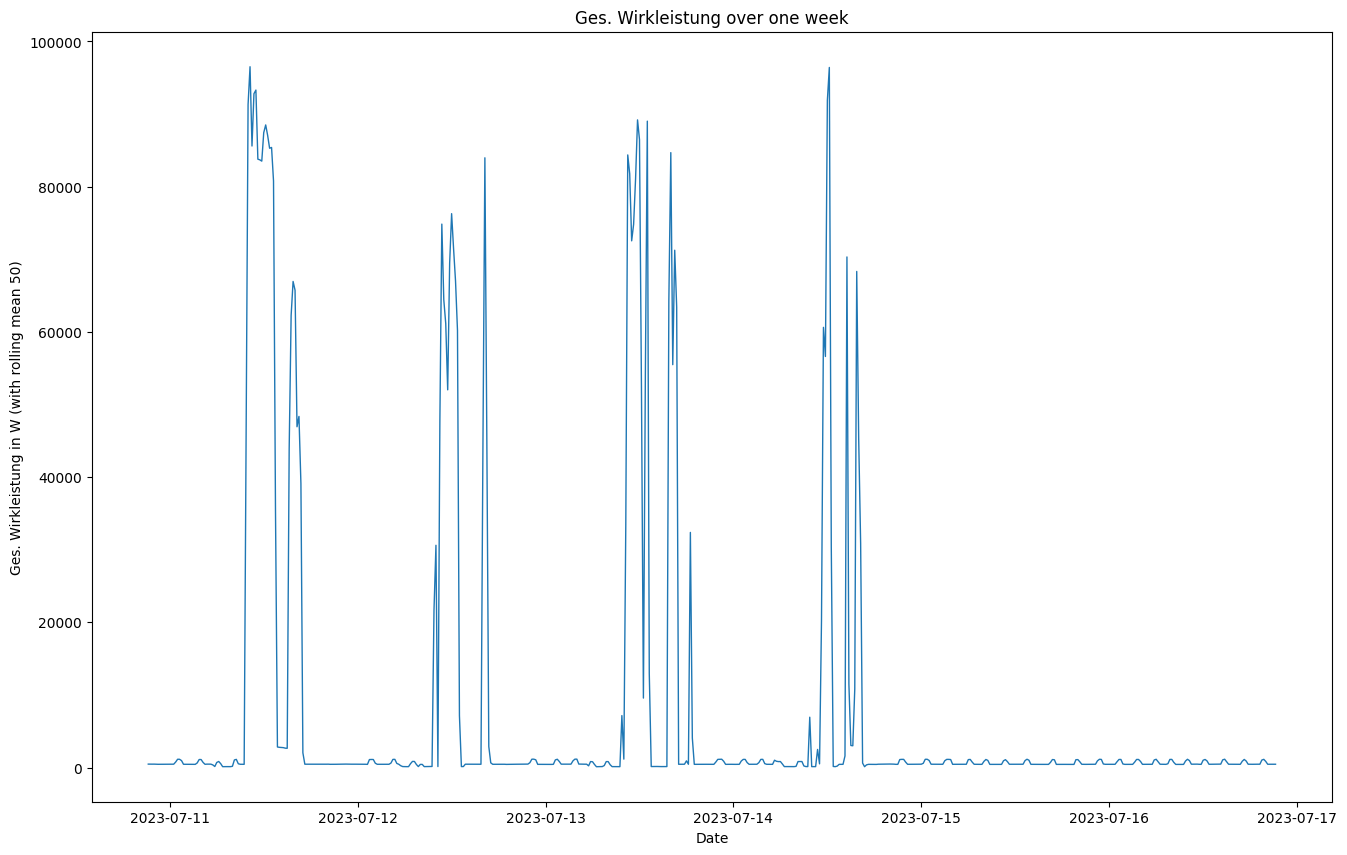

In [100]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.plot(get_random_week(df)[TARGET], linewidth=1)
ax.set_title(f"{TARGET} over one week")
ax.set_ylabel(f"{TARGET} in W (with rolling mean 50)")
ax.set_xlabel(f"Date")

plt.savefig(f'./results/self/{MACHINE_NAME} {TARGET} over one week.png', transparent=PLOT_TRANSPARENT)

Boxplots

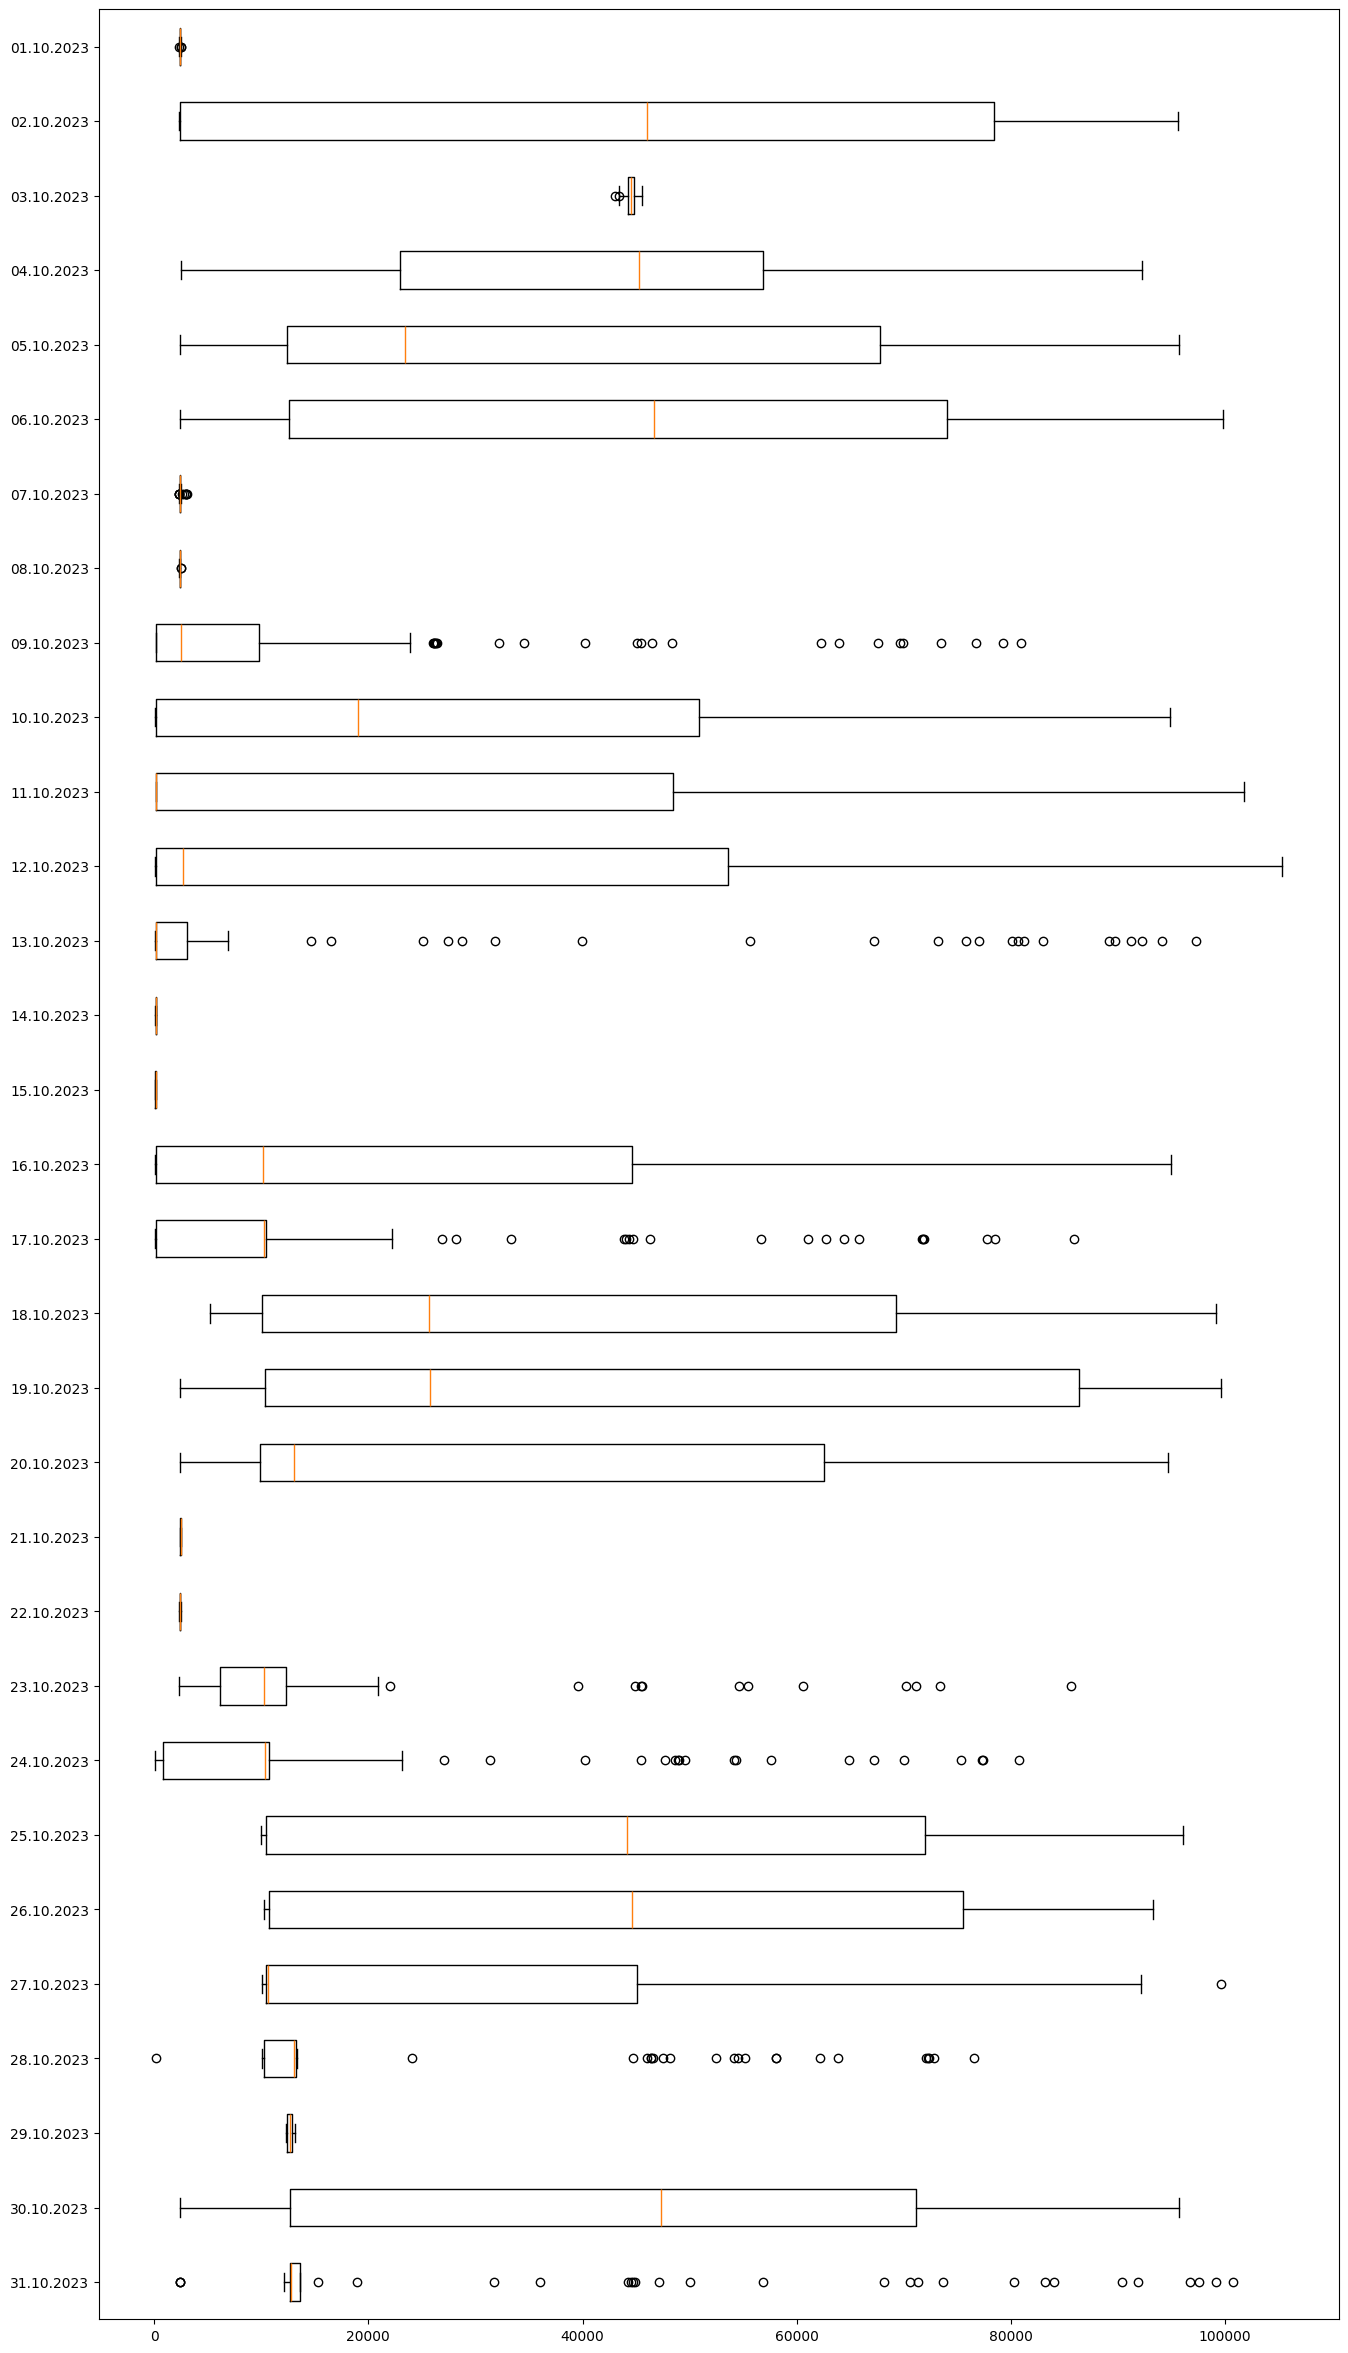

In [101]:
month = 10
df["date_str"] = df["Zeitstempel"].dt.strftime('%d.%m.%Y')

data_list = list()
column_name_list = list()
for cur_date in df["date_str"].unique():
    if month == int(cur_date.split(".")[1]):
        data_list += [df.loc[df["date_str"] == cur_date, TARGET]]
        column_name_list += [cur_date]
data_list = data_list[::-1]
column_name_list = column_name_list[::-1]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 30))

ax.boxplot(data_list, vert=False, showfliers=True)
ax.set_yticks(np.arange(1, len(column_name_list)+1), labels=column_name_list)
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

del df["date_str"]

Heatmaps

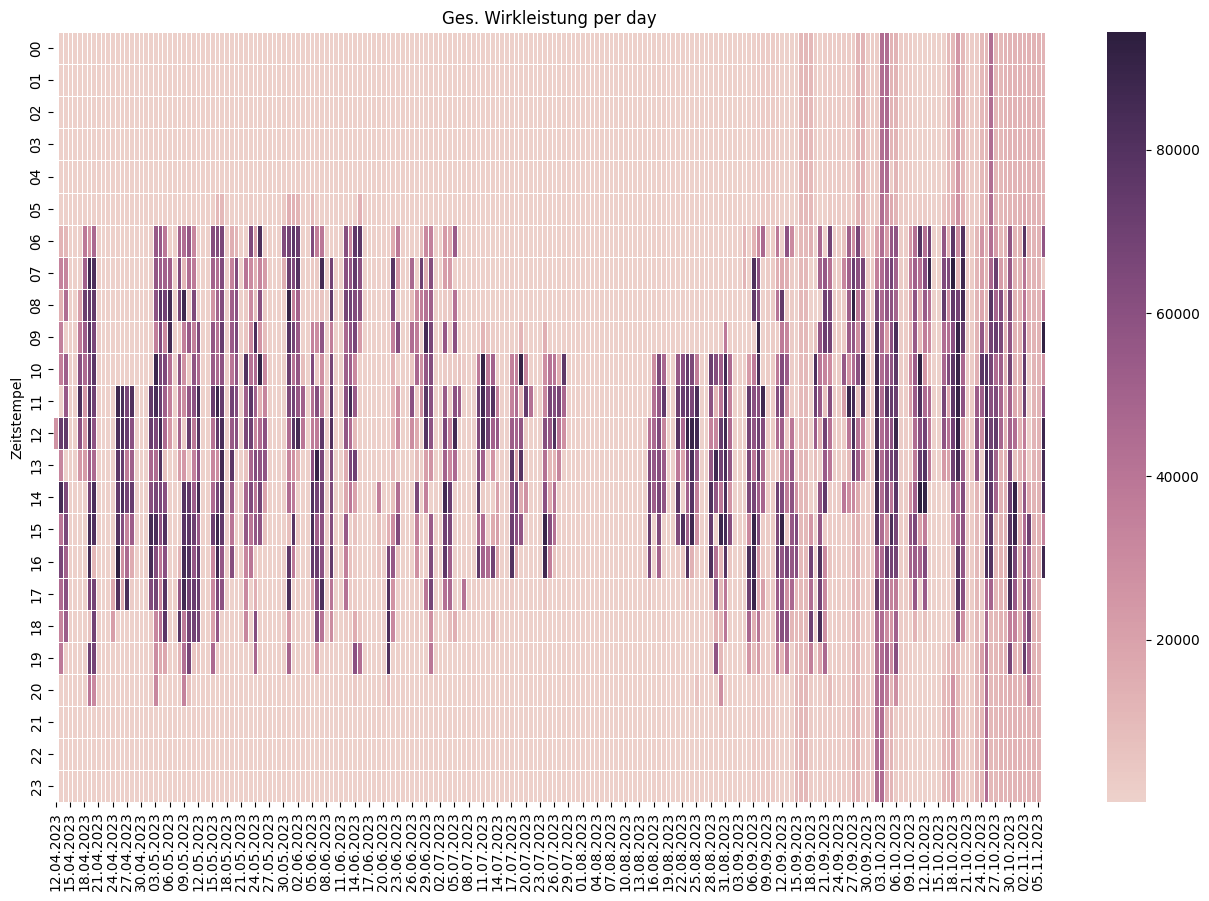

In [102]:
df["date_str"] = df["Zeitstempel"].dt.strftime('%d.%m.%Y')

day_df = pd.DataFrame()
for idx, cur_date in enumerate(df["date_str"].unique()):
    cache_df = pd.DataFrame()
    cache_df[cur_date] = df.loc[df["date_str"] == cur_date, TARGET]
    cache_df["Zeitstempel"] = df.loc[df["date_str"] == cur_date, "Zeitstempel"]
    cache_df = cache_df.resample('60min', on="Zeitstempel").mean()[cur_date]
    cache_df.index = cache_df.index.strftime('%H')
    if idx != 0:
        day_df[cur_date] = cache_df

# add first date
cur_date = df["date_str"].unique()[0]
cache_df = pd.DataFrame()
cache_df[cur_date] = df.loc[df["date_str"] == cur_date, TARGET]
cache_df["Zeitstempel"] = df.loc[df["date_str"] == cur_date, "Zeitstempel"]
cache_df = cache_df.resample('24h', on="Zeitstempel").mean()[cur_date]
cache_df.index = cache_df.index.strftime('%d')
day_df.insert(0, f'{cur_date}', cache_df)

display(day_df, reset_index=False, amount=5)

plt.figure(figsize = (16, 10))
plt.title(f"{TARGET} per day")
plt.ylabel("Hour")
plt.xlabel("Day")
sns.heatmap(day_df, linewidths=0.5, cmap=sns.cubehelix_palette(as_cmap=True), annot=False)

plt.savefig(f'./results/self/{MACHINE_NAME} {TARGET} per day heatmap complete.png', transparent=PLOT_TRANSPARENT)

del df["date_str"]
del day_df

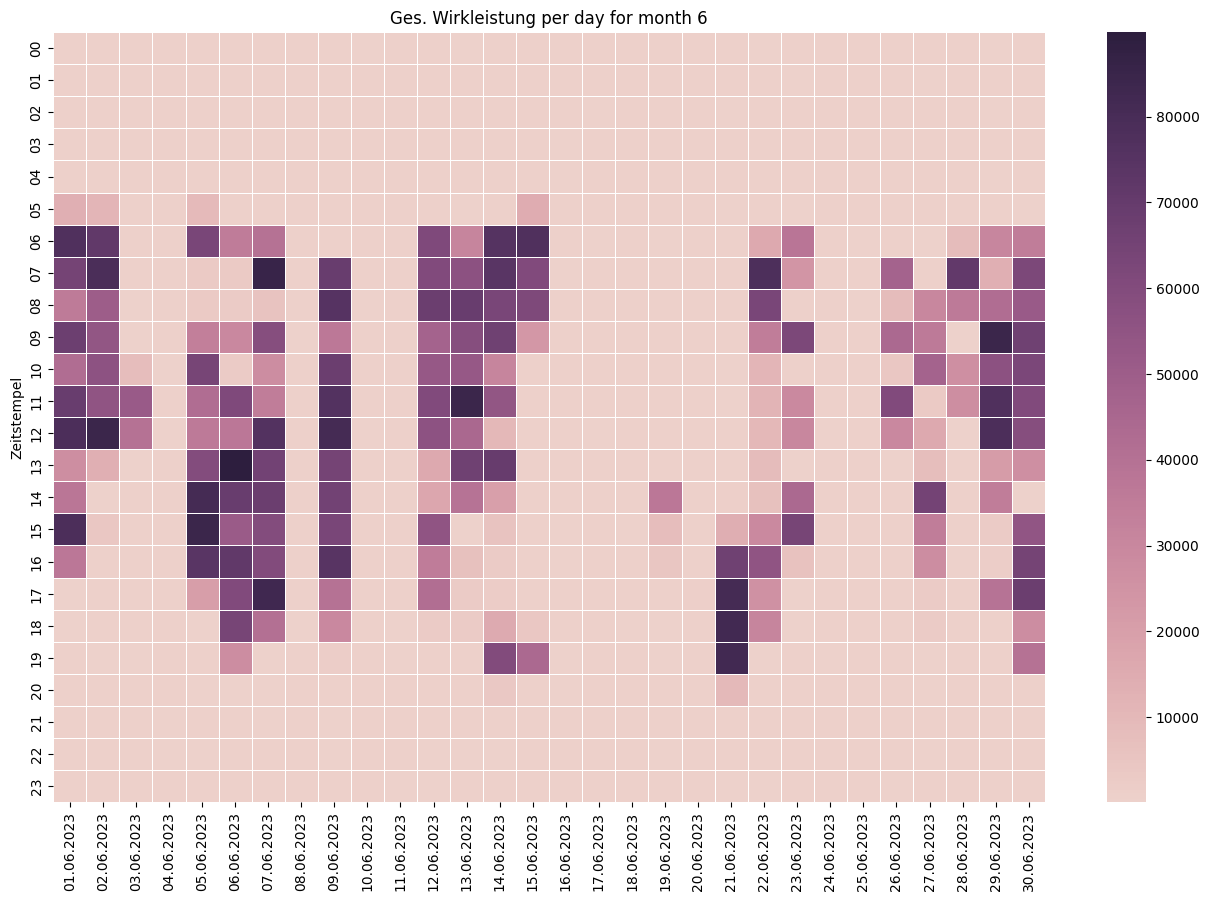

In [103]:
month = 6
df["date_str"] = df["Zeitstempel"].dt.strftime('%d.%m.%Y')

day_df = pd.DataFrame()
for idx, cur_date in enumerate(df["date_str"].unique()):
    if month == int(cur_date.split(".")[1]):
        cache_df = pd.DataFrame()
        cache_df[cur_date] = df.loc[df["date_str"] == cur_date, TARGET]
        cache_df["Zeitstempel"] = df.loc[df["date_str"] == cur_date, "Zeitstempel"]
        cache_df = cache_df.resample('60min', on="Zeitstempel").mean()[cur_date]
        cache_df.index = cache_df.index.strftime('%H')
        # Add values with 0 values -> mybe with offset by resample
        # if idx == 0:
        #     for i in np.arange(0,11):
        #         i = str(i)
        #         if i not in cache_df.index:
        #             cache_df.append(pd.Series({i:0.0}))
        if idx != 0:
            day_df[cur_date] = cache_df

display(day_df, reset_index=False, amount=5)

plt.figure(figsize = (16, 10))
plt.title(f"{TARGET} per day for month {month}")
plt.ylabel("Hour")
plt.xlabel("Day")
sns.heatmap(day_df, linewidths=0.5, cmap=sns.cubehelix_palette(as_cmap=True), annot=False)

plt.savefig(f'./results/self/{MACHINE_NAME} {TARGET} per day heatmap for month {month}.png', transparent=PLOT_TRANSPARENT)

del df["date_str"]
del day_df

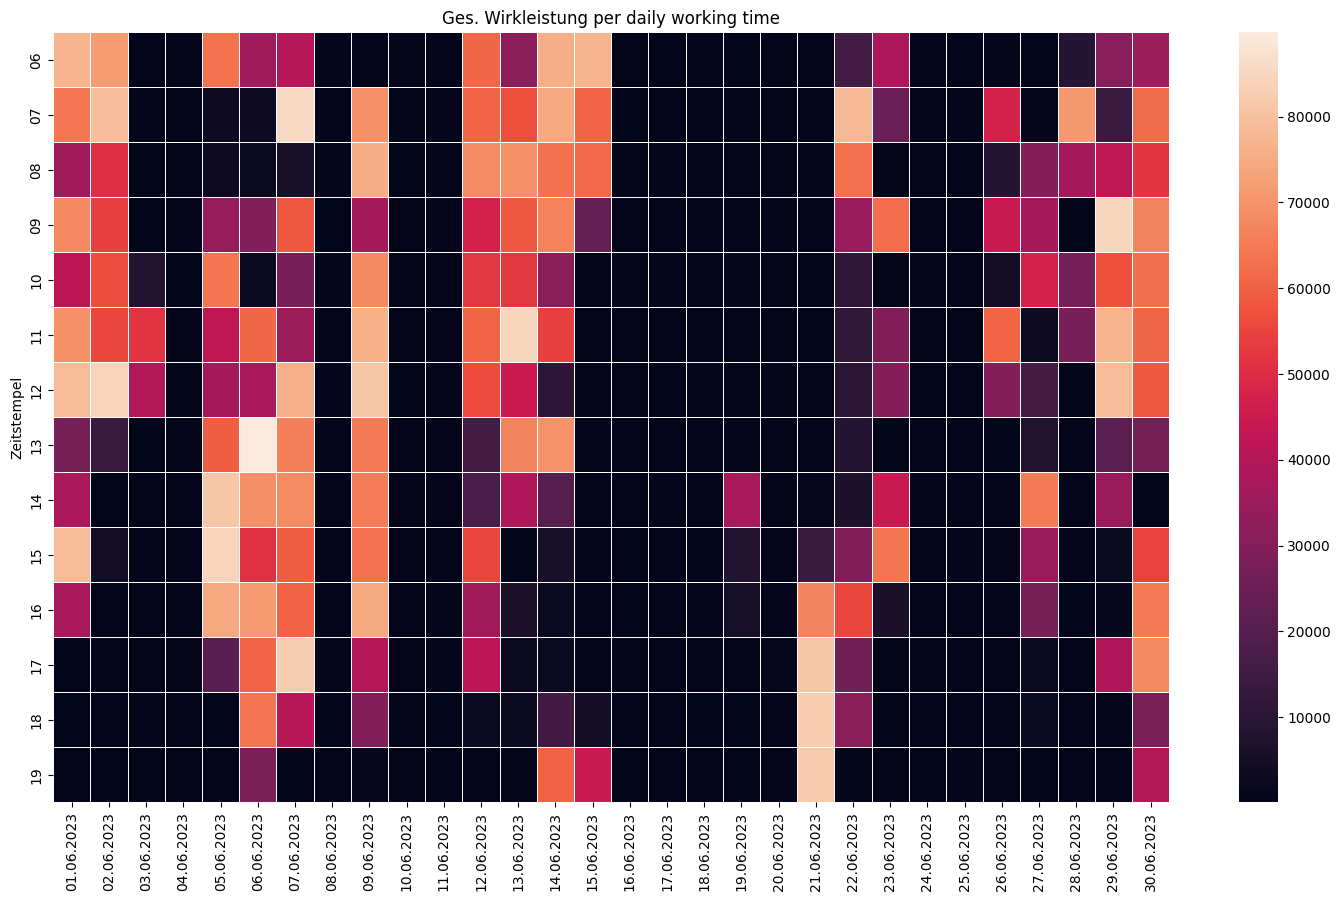

In [104]:
df["date_str"] = df["Zeitstempel"].dt.strftime('%d.%m.%Y')

day_df = pd.DataFrame()
for idx, cur_date in enumerate(df["date_str"].unique()):
    if month == int(cur_date.split(".")[1]):
        cache_df = pd.DataFrame()
        cache_df[cur_date] = df.loc[df["date_str"] == cur_date, TARGET]
        cache_df["Zeitstempel"] = df.loc[df["date_str"] == cur_date, "Zeitstempel"]
        cache_df = cache_df.resample('60min', on="Zeitstempel").mean()[cur_date]
        cache_df.index = cache_df.index.strftime('%H')
        if idx != 0:
            day_df[cur_date] = cache_df

day_df.index = pd.to_datetime(day_df.index, format="%H")
day_df = day_df.between_time('6:00', '19:00')
day_df.index = day_df.index.strftime('%H')
display(day_df, reset_index=False)

plt.figure(figsize = (18, 10))
plt.title(f"{TARGET} per daily working time")
plt.xlabel("Day")
sns.heatmap(day_df, linewidths=0.5, cmap=sns.color_palette("rocket", as_cmap=True), annot=False)

del df["date_str"]
del day_df

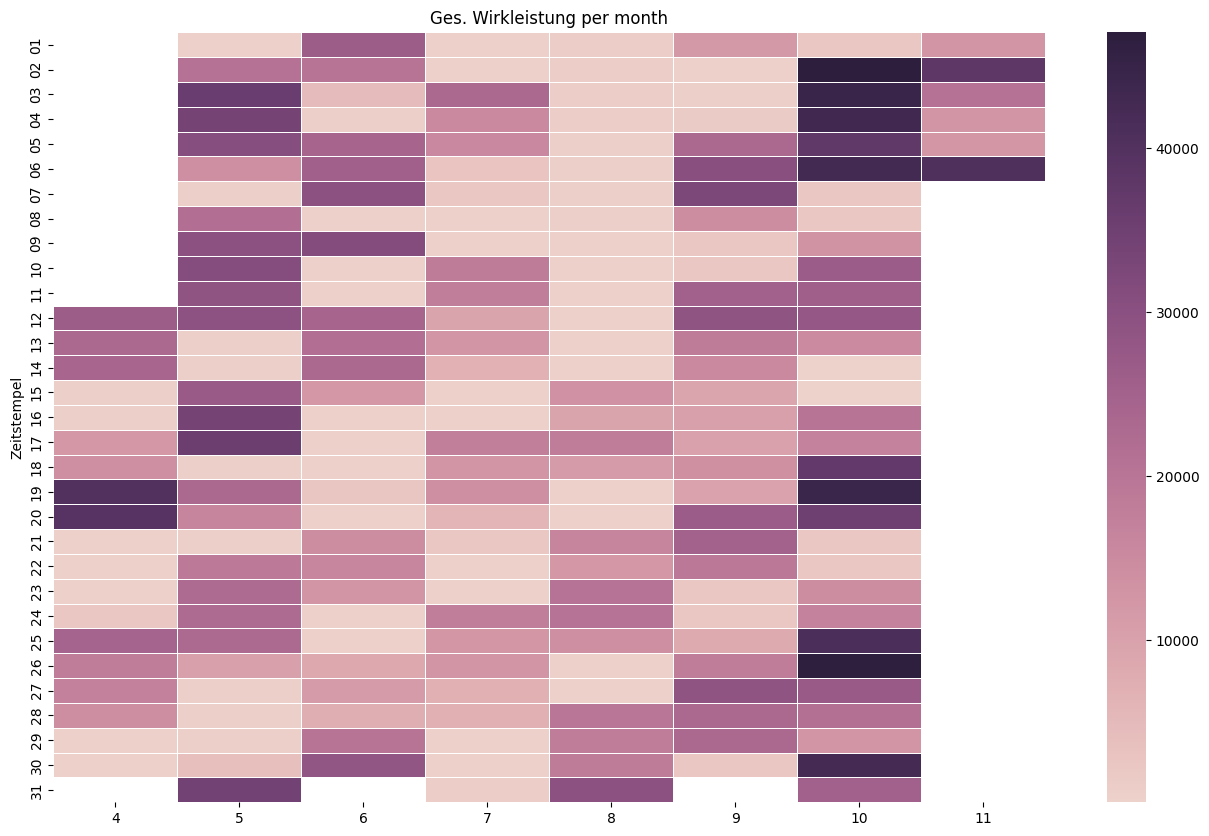

In [105]:
df["date_str"] = df["Zeitstempel"].dt.month

day_df = pd.DataFrame()
for idx, cur_date in enumerate(df["date_str"].unique()):
    cache_df = pd.DataFrame()
    cache_df[cur_date] = df.loc[df["date_str"] == cur_date, TARGET]
    cache_df["Zeitstempel"] = df.loc[df["date_str"] == cur_date, "Zeitstempel"]
    cache_df = cache_df.resample('24h', on="Zeitstempel").mean()[cur_date]
    cache_df.index = cache_df.index.strftime('%d')
    if idx != 0:
        day_df[cur_date] = cache_df

# add first date
cur_date = df["date_str"].unique()[0]
cache_df = pd.DataFrame()
cache_df[cur_date] = df.loc[df["date_str"] == cur_date, TARGET]
cache_df["Zeitstempel"] = df.loc[df["date_str"] == cur_date, "Zeitstempel"]
cache_df = cache_df.resample('24h', on="Zeitstempel").mean()[cur_date]
cache_df.index = cache_df.index.strftime('%d')
day_df.insert(0, f'{cur_date}', cache_df)

display(day_df, reset_index=False, amount=5)

plt.figure(figsize = (16, 10))
plt.title(f"{TARGET} per month")
plt.ylabel("Day")
plt.xlabel("Month")
sns.heatmap(day_df, linewidths=0.5, cmap=sns.cubehelix_palette(as_cmap=True), annot=False)

plt.savefig(f'./results/self/{MACHINE_NAME} {TARGET} per month heatmap.png', transparent=PLOT_TRANSPARENT)

del df["date_str"]
del day_df

Variance over the whole time

=> Variance is the mean squared difference from the mean

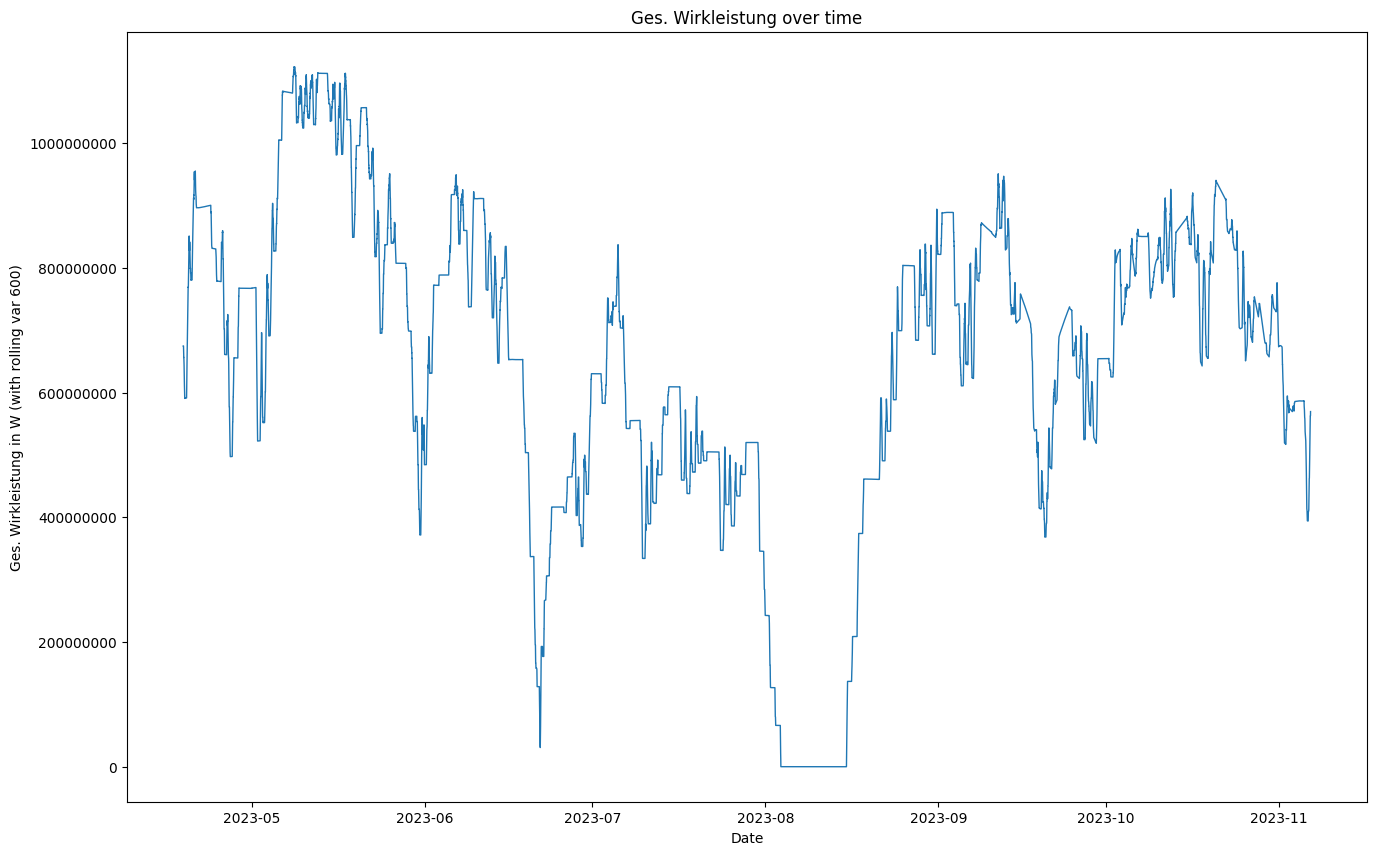

In [106]:
window_size = 600

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.plot(df[TARGET].rolling(window_size).var(), linewidth=1)
ax.set_title(f"{TARGET} over time")
ax.set_ylabel(f"{TARGET} in W (with rolling var {window_size})")
ax.set_xlabel(f"Date")
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)

plt.savefig(f'./results/self/{MACHINE_NAME} {TARGET} over time (lineplot).png', transparent=PLOT_TRANSPARENT)

Variance per day

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


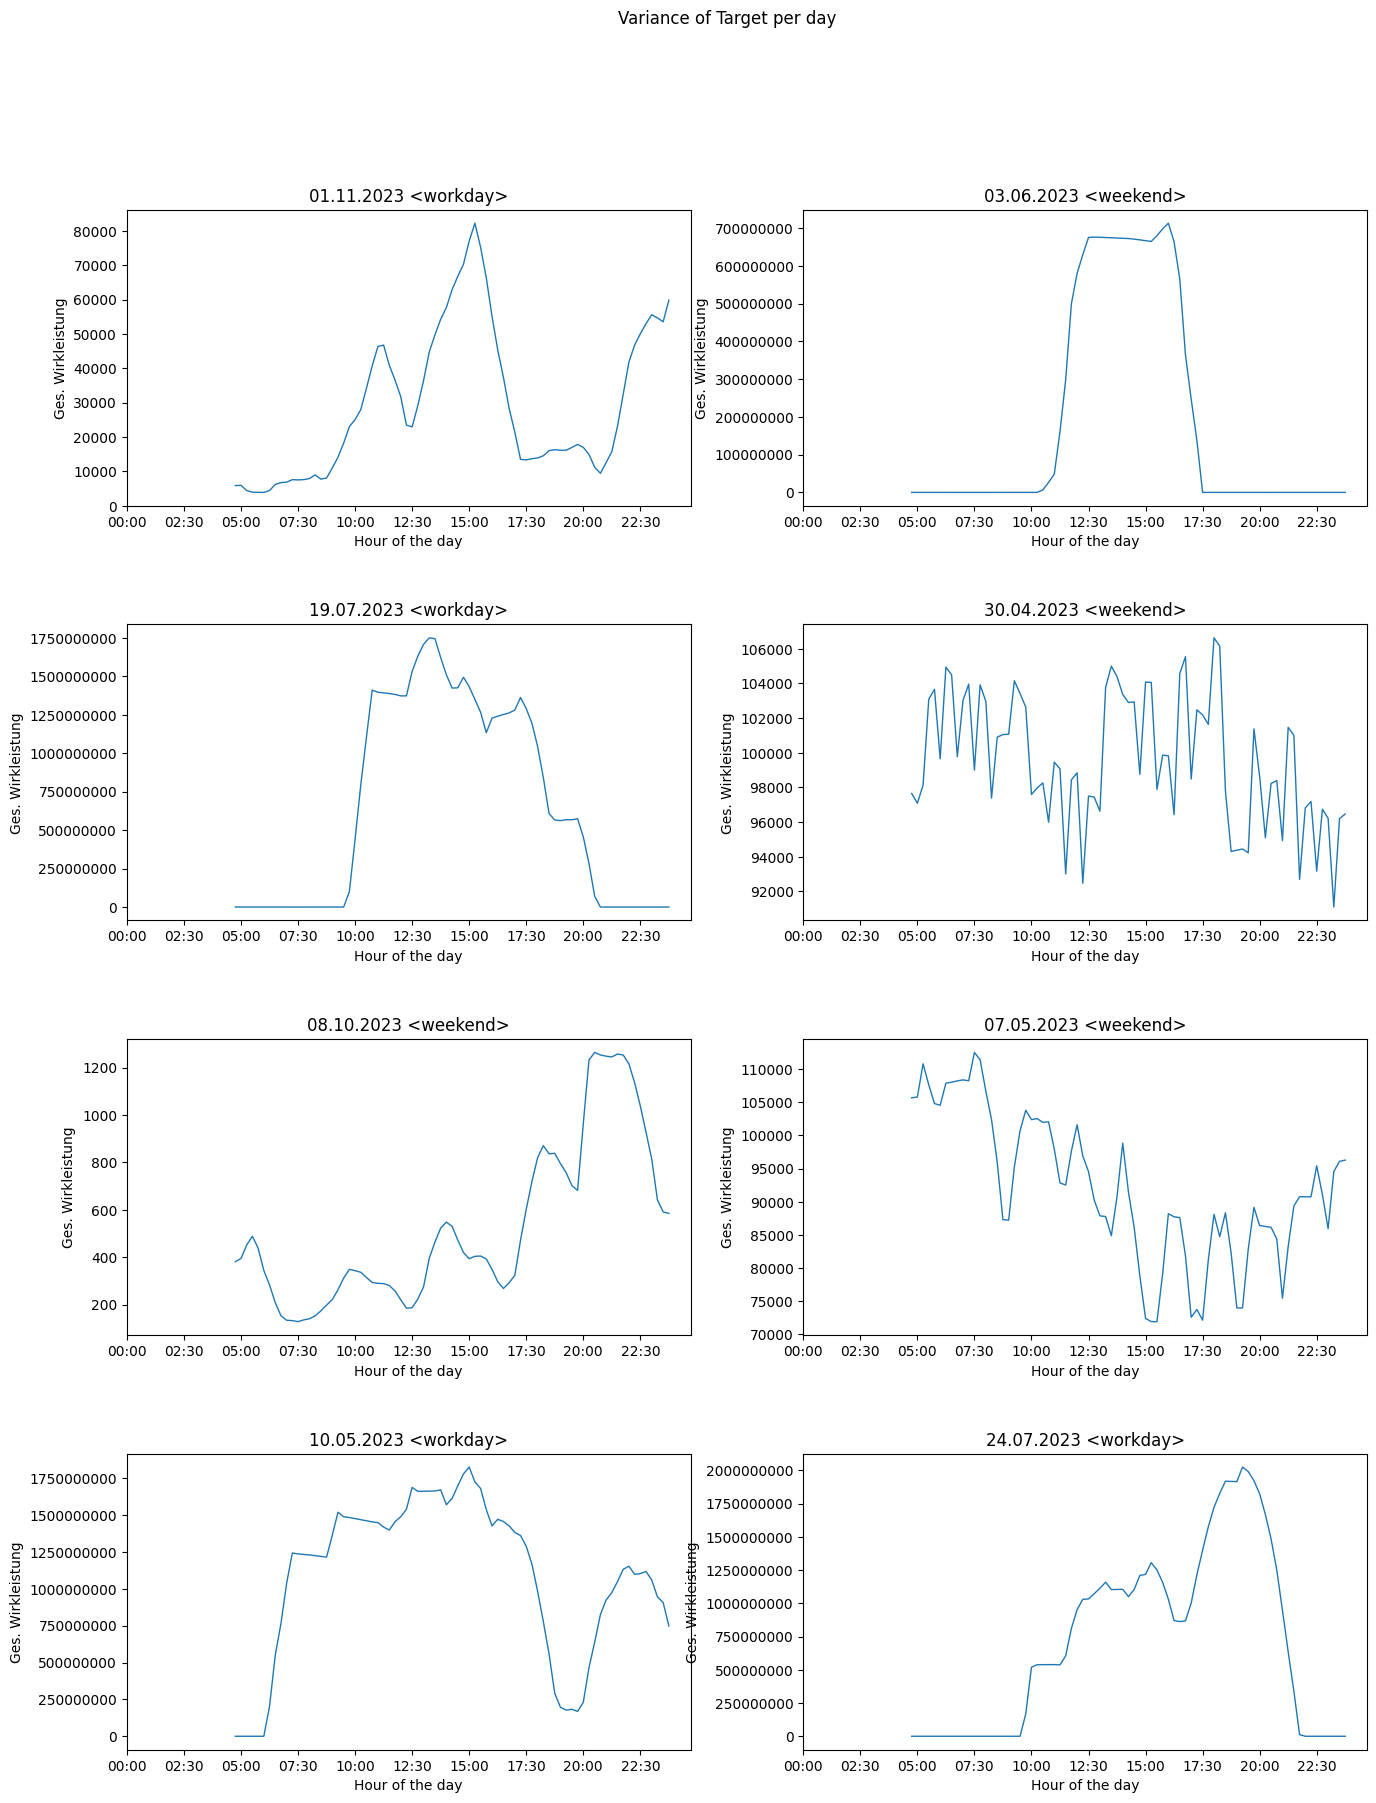

In [107]:
window_size = 20

df_without_august = df.loc[df["Zeitstempel"].dt.month != 8, :]
df_without_august["date_str"] = df_without_august["Zeitstempel"].dt.strftime('%d.%m.%Y')
cur_date = np.random.choice(df_without_august["date_str"].unique(), 8)

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(16, 20), gridspec_kw={'hspace': 0.4})
fig.suptitle("Variance of Target per day")
for idx, cur_date_ in enumerate(cur_date):
    col = (idx+1)%2
    row = (idx-1)//2

    cache_df = df_without_august.loc[df_without_august["date_str"] == cur_date_, [TARGET, "date_str"]]
    cache_df.index = cache_df.index.strftime('%H:%M')
    ax[row, col].plot(cache_df[TARGET].rolling(window_size).var(), linewidth=1)
    formatter = ticker.ScalarFormatter()
    formatter.set_scientific(False)
    ax[row, col].yaxis.set_major_formatter(formatter)
    ax[row, col].xaxis.set_major_formatter(formatter)
    ax[row, col].set_xticks(ax[row, col].get_xticks()[::10])
    ax[row, col].set_xticklabels(cache_df.index[::10])
    ax[row, col].set_ylabel(f"{TARGET}")
    ax[row, col].set_title(f"{cur_date_} <{check_day_type(cur_date_)}>")
    ax[row, col].set_xlabel(f"Hour of the day")

plt.savefig(f'./results/self/{MACHINE_NAME} Variance of Target per day.png', transparent=PLOT_TRANSPARENT)

del cache_df

Variance per month

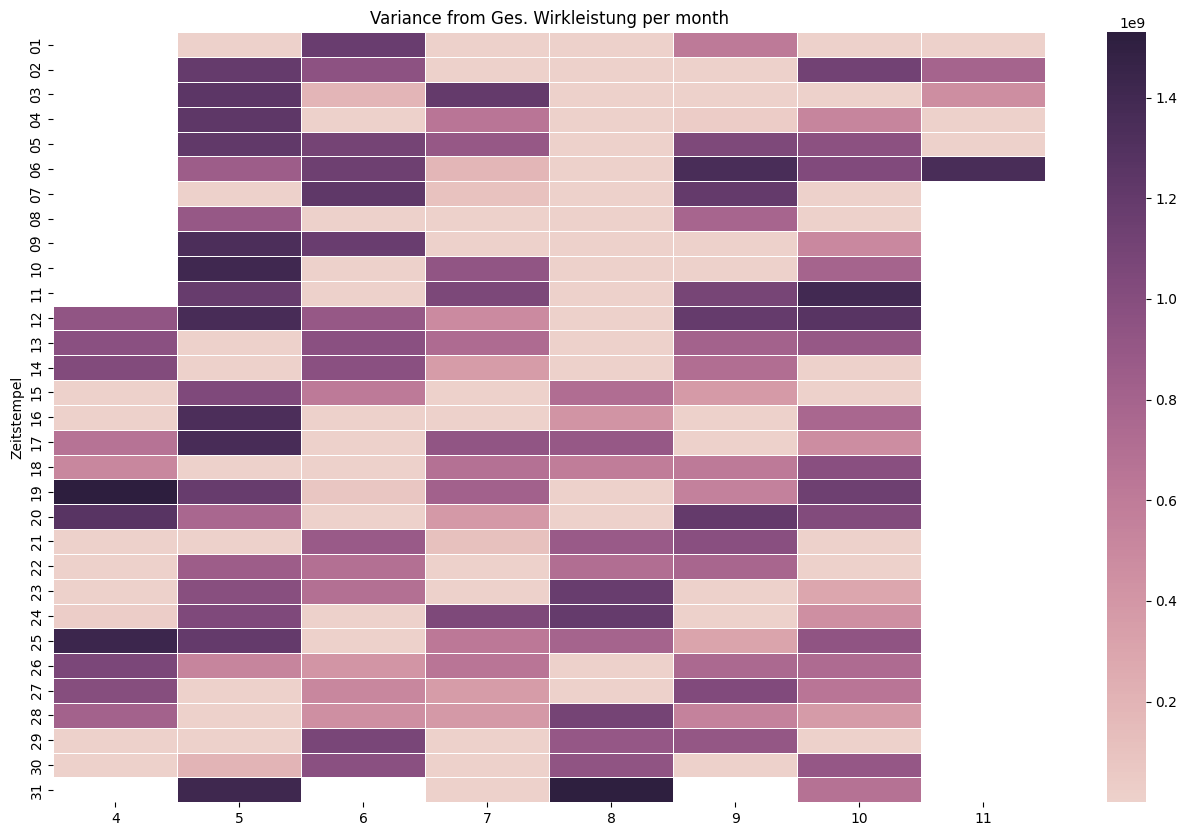

In [108]:
df["date_str"] = df["Zeitstempel"].dt.month

day_df = pd.DataFrame()
for idx, cur_date in enumerate(df["date_str"].unique()):
    cache_df = pd.DataFrame()
    cache_df[cur_date] = df.loc[df["date_str"] == cur_date, TARGET]
    cache_df["Zeitstempel"] = df.loc[df["date_str"] == cur_date, "Zeitstempel"]
    cache_df = cache_df.resample('24h', on="Zeitstempel").var()[cur_date]
    cache_df.index = cache_df.index.strftime('%d')
    if idx != 0:
        day_df[cur_date] = cache_df

# add first date
cur_date = df["date_str"].unique()[0]
cache_df = pd.DataFrame()
cache_df[cur_date] = df.loc[df["date_str"] == cur_date, TARGET]
cache_df["Zeitstempel"] = df.loc[df["date_str"] == cur_date, "Zeitstempel"]
cache_df = cache_df.resample('24h', on="Zeitstempel").var()[cur_date]
cache_df.index = cache_df.index.strftime('%d')
day_df.insert(0, f'{cur_date}', cache_df)

display(day_df, reset_index=False, amount=5)

plt.figure(figsize = (16, 10))
plt.title(f"Variance from {TARGET} per month")
plt.ylabel("Day")
plt.xlabel("Month")
sns.heatmap(day_df, linewidths=0.5, cmap=sns.cubehelix_palette(as_cmap=True), annot=False)

plt.savefig(f'./results/self/{MACHINE_NAME} Variance {TARGET} per month heatmap.png', transparent=PLOT_TRANSPARENT)

del df["date_str"]
del day_df

Visualize a week

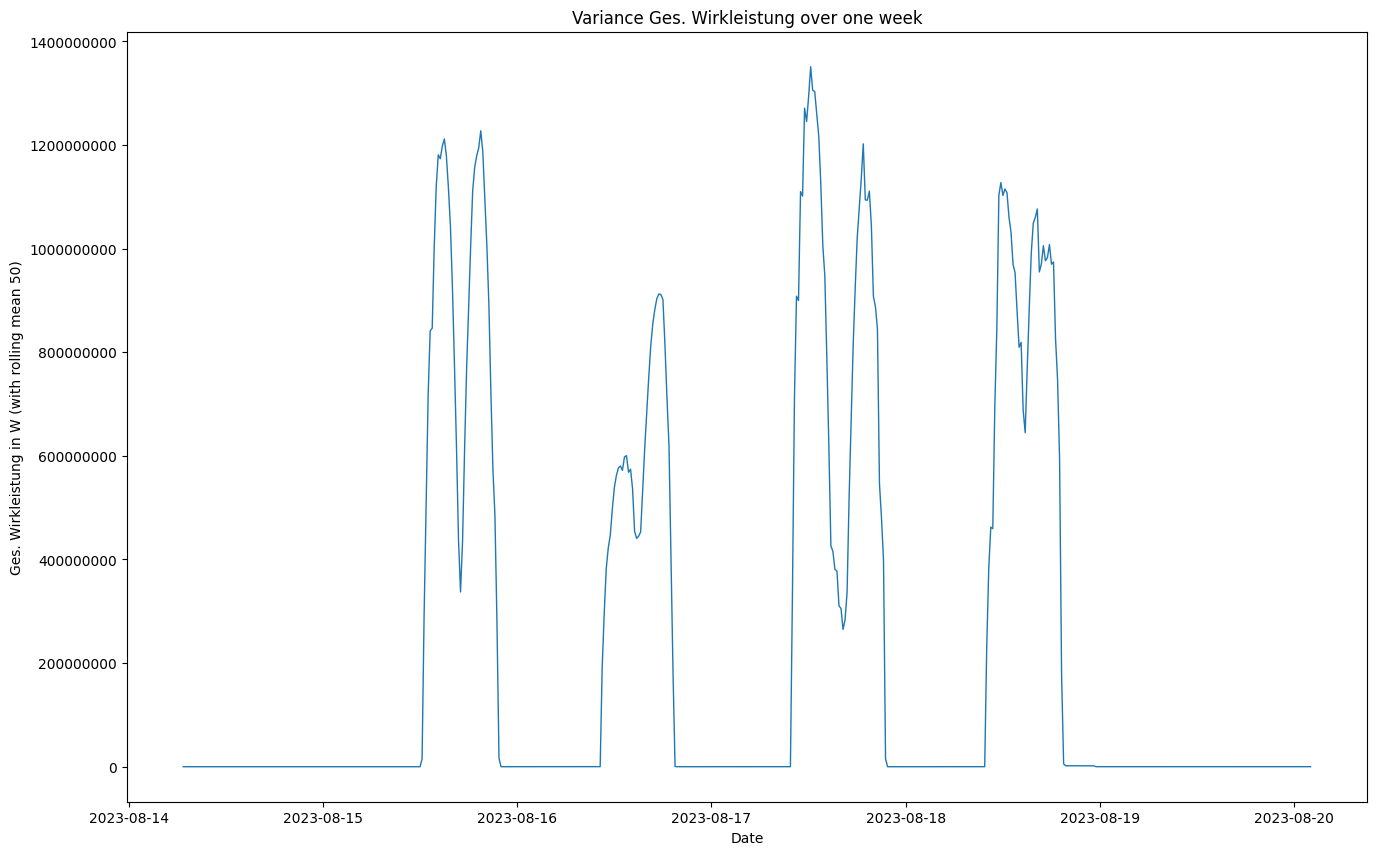

In [109]:
window_size = 20

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.plot(get_random_week(df)[TARGET].rolling(window_size).var(), linewidth=1)
ax.set_title(f"Variance {TARGET} over one week")
ax.set_ylabel(f"{TARGET} in W (with rolling mean 50)")
ax.set_xlabel(f"Date")
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)

plt.savefig(f'./results/self/{MACHINE_NAME} Variance from {TARGET} over one week.png', transparent=PLOT_TRANSPARENT)

Varince per week over time

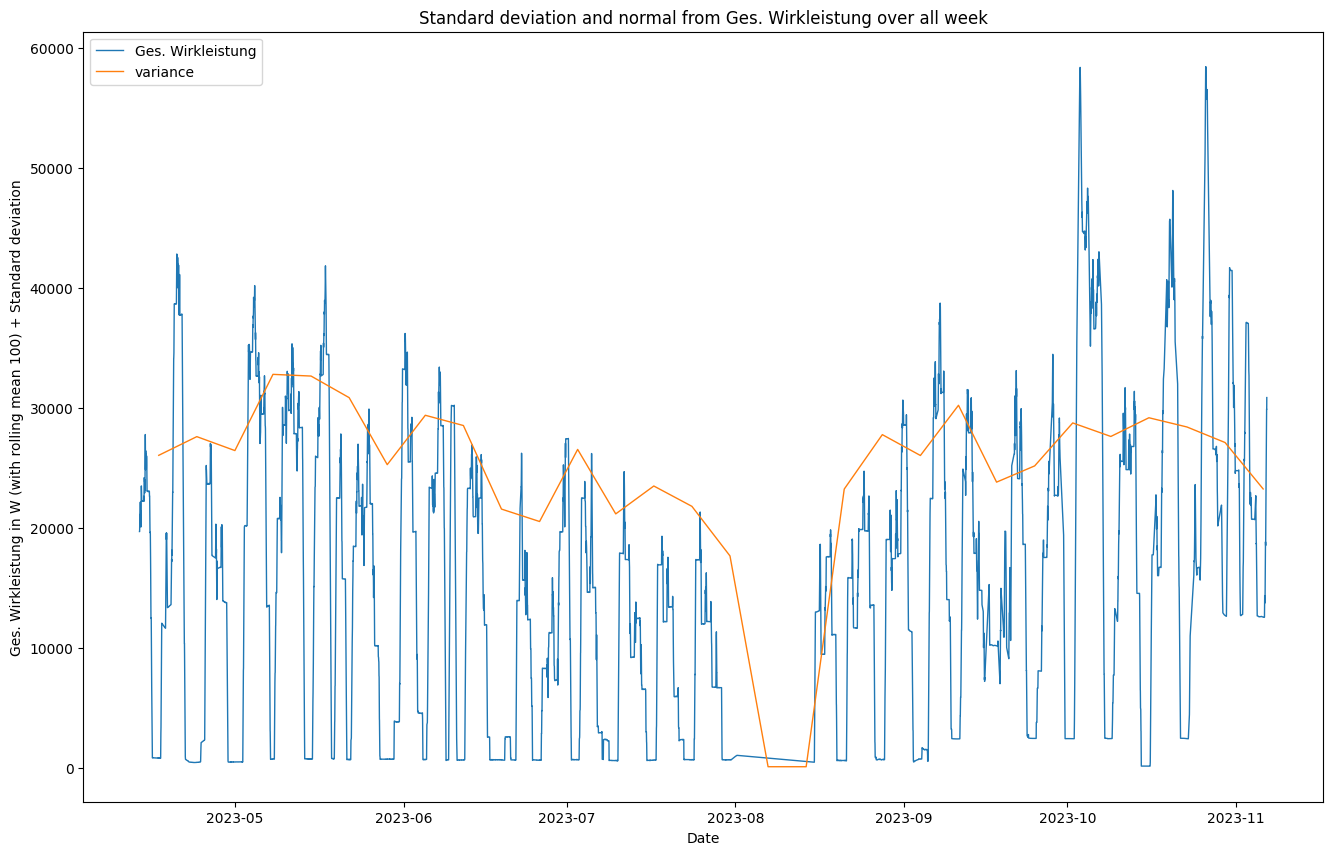

In [110]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.plot(df[TARGET].rolling(100).mean(), linewidth=1, label=TARGET)
ax.plot(df[TARGET].resample('W-MON').std(), linewidth=1, label="variance")
ax.set_title(f"Standard deviation and normal from {TARGET} over all week")
ax.set_ylabel(f"{TARGET} in W (with rolling mean 100) + Standard deviation")
ax.set_xlabel(f"Date")
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.legend()

plt.savefig(f'./results/self/{MACHINE_NAME} Standard deviation and normal from {TARGET} over all week.png', transparent=PLOT_TRANSPARENT)

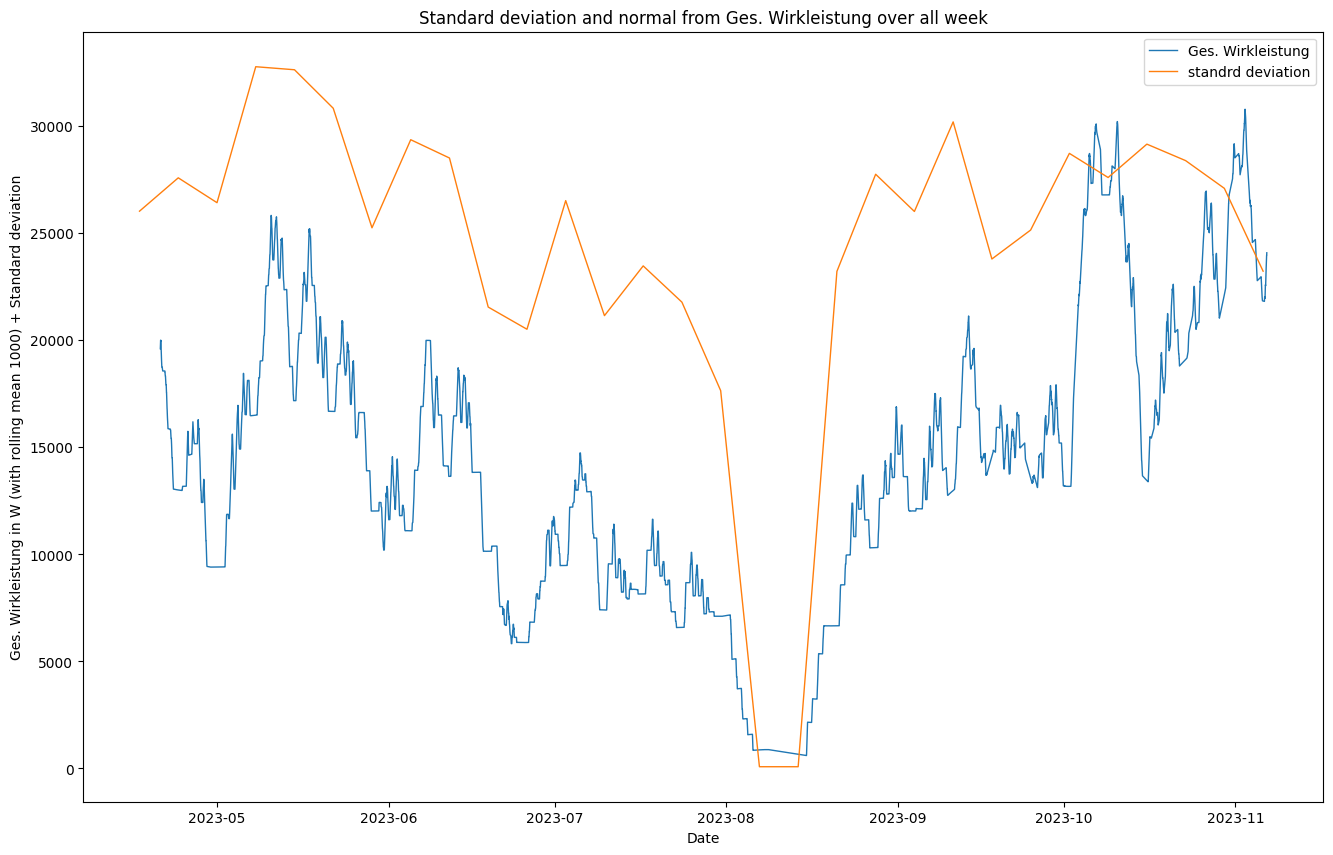

In [111]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.plot(df[TARGET].rolling(800).mean(), linewidth=1, label=TARGET)
ax.plot(df[TARGET].resample('W-MON').std(), linewidth=1, label="standrd deviation")
ax.set_title(f"Standard deviation and normal from {TARGET} over all week")
ax.set_ylabel(f"{TARGET} in W (with rolling mean 1000) + Standard deviation")
ax.set_xlabel(f"Date")
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.legend()

plt.savefig(f'./results/self/{MACHINE_NAME} Standard deviation and normal from {TARGET} over all week 2.png', transparent=PLOT_TRANSPARENT)

Per month

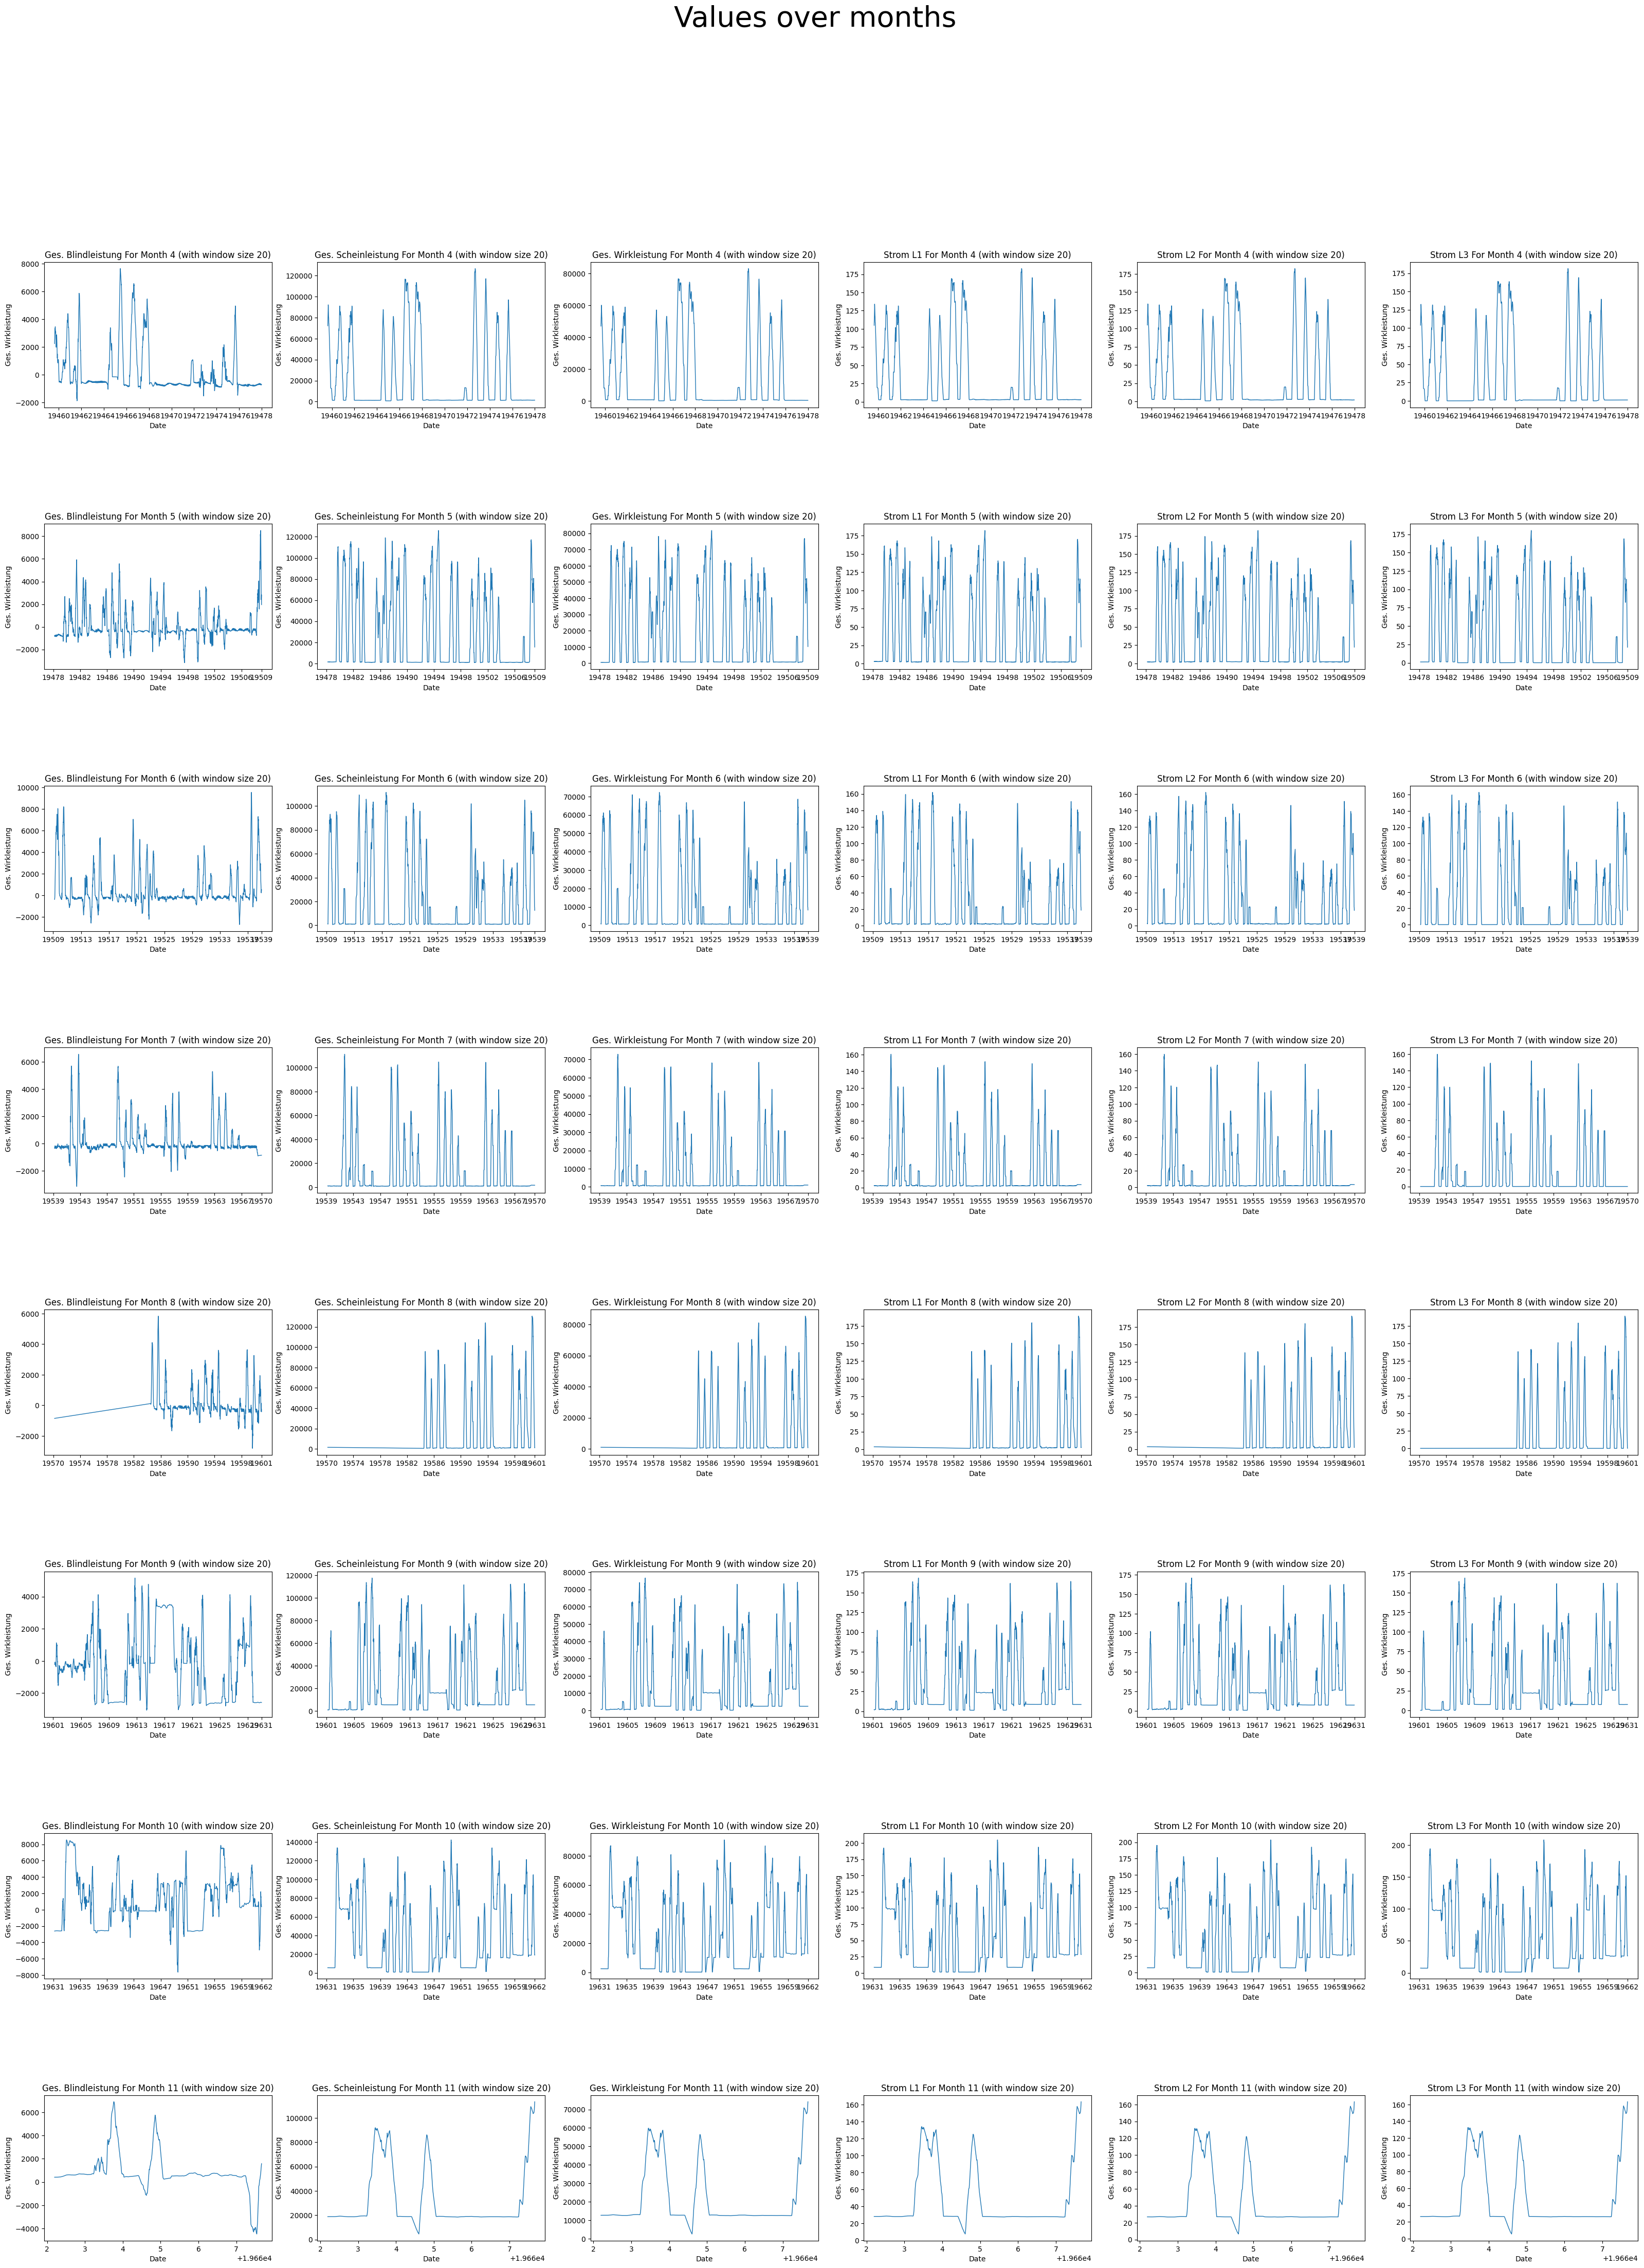

In [112]:
window_size = 20

months = list(df.index.month.unique())
cols = df.drop(columns=("Zeitstempel")).columns
row = 0

fig, ax = plt.subplots(ncols=len(cols), nrows=len(months), figsize=(40, 50), gridspec_kw={'hspace': 0.8})
fig.suptitle("Values over months", fontsize=40)
for idx, cur_month in enumerate(months):
    for col_idx in range(len(cols)):
        col = col_idx #(idx+1)%cols
        #row = (idx-1)//cols

        cache_df = df.loc[df.index.month == cur_month, :]

        ax[row, col].plot(cache_df[cols[col]].rolling(window_size).mean(), linewidth=1)
        #ax[row, col].plot(cache_df[TARGET].rolling(window_size).var(), linewidth=1)
        title = f"{cols[col]} For Month {cur_month} (with window size {window_size})"
            
        formatter = ticker.ScalarFormatter()
        formatter.set_scientific(False)
        ax[row, col].yaxis.set_major_formatter(formatter)
        ax[row, col].xaxis.set_major_formatter(formatter)
        #ax[row, col].set_xticks(ax[row, col].get_xticks()[::10])
        #ax[row, col].set_xticklabels(cache_df.index[::1000])
        ax[row, col].set_ylabel(f"{TARGET}")
        ax[row, col].set_title(f"{cur_date_} <{check_day_type(cur_date_)}>")
        ax[row, col].set_xlabel(f"Date")
        ax[row, col].set_title(title)
    row += 1

plt.savefig(f'./results/self/{MACHINE_NAME} Values over months.png', transparent=PLOT_TRANSPARENT)

del cache_df

Daily variance by hours

Calculate the mean of every hour and build the variance of every hour of every weekday

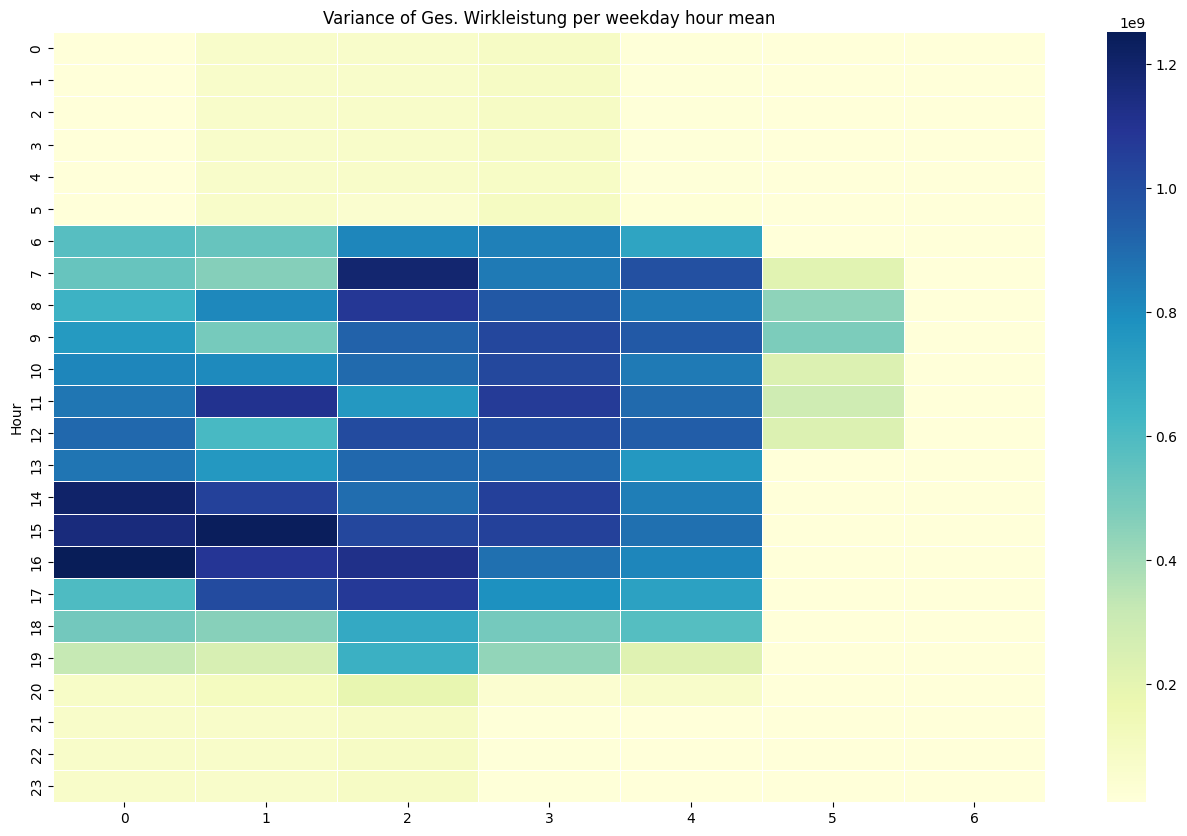

In [113]:
df["week_day"] = df["Zeitstempel"].dt.day_of_week

weekday_var_df = pd.DataFrame()
for idx, cur_weekday in enumerate(sorted(df["week_day"].unique())):
    cache_df = pd.DataFrame()
    cache_df[cur_weekday] = df.loc[df["week_day"] == cur_weekday, TARGET]
    cache_df["Zeitstempel"] = df.loc[df["week_day"] == cur_weekday, "Zeitstempel"]

    cache_df["Date"] = cache_df["Zeitstempel"].dt.date
    cache_df["Hour"] = cache_df["Zeitstempel"].dt.hour
    var_df = cache_df.groupby(["Date", "Hour"], as_index=False).mean()
    
    var_df = var_df.drop(columns=["Date", "Zeitstempel"]).groupby("Hour").var()
    
    weekday_var_df[cur_weekday] = var_df


display(weekday_var_df, reset_index=False, amount=5)

plt.figure(figsize = (16, 10))
plt.title(f"Variance of {TARGET} per weekday hour mean")
plt.ylabel("Day")
plt.xlabel("Weekday")
sns.heatmap(weekday_var_df, linewidths=0.5, cmap="YlGnBu", annot=False)

plt.savefig(f'./results/self/{MACHINE_NAME} Variance of {TARGET} per weekday hour mean.png', transparent=PLOT_TRANSPARENT)

del df["week_day"]
del weekday_var_df

Results:<br>
The visualisations can be explained by the reality and gave total sense. 

Important pattern can not be seen.

---
### Feature Selection

Methods:
- SelectKBest
- RandomForestRegressor (Gain/Splits)
- PCA
- Correlation

Ressources:
- class
- https://machinelearningmastery.com/feature-selection-for-regression-data/
- https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/
- https://towardsdatascience.com/feature-selection-and-dimensionality-reduction-f488d1a035de

[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

In [114]:
# create features
X = df.loc[:, ['Zeitstempel',
                'Ges. Blindleistung',
                'Ges. Scheinleistung',
                'Strom L1',
                'Strom L2',
                'Strom L3']]
X = X.reset_index(drop=True, inplace=False)
y = df.loc[:, 'Ges. Wirkleistung']
y = y.reset_index(drop=False, inplace=False)

# make train test split -> stratified (not random)
test_size_percentage = 0.3
test_size = int(len(df.index)*0.3)
train_size = len(df.index) - test_size

X_train = X.loc[0:train_size, :]
X_test = X.loc[train_size:, :]
print(f"Len x_train = {len(X_train.index)}\nLen x_test = {len(X_test.index)}\n")

y_train = y.loc[0:train_size, :]
y_test = y.loc[train_size:, :]
print(f"Len y_train = {len(y_train.index)}\nLen y_test = {len(y_test.index)}")

# reset index nd delete date
X.index = X["Zeitstempel"]
X_train.index = X_train["Zeitstempel"]
X_test.index = X_test["Zeitstempel"]
del X["Zeitstempel"]
del X_train["Zeitstempel"]
del X_test["Zeitstempel"]

y.index = y["Zeitstempel"]
y_train.index = y_train["Zeitstempel"]
y_test.index = y_test["Zeitstempel"]
del y["Zeitstempel"]
del y_train["Zeitstempel"]
del y_test["Zeitstempel"]

Len x_train = 13995
Len x_test = 5997

Len y_train = 13995
Len y_test = 5997


In [115]:
selector = SelectKBest(score_func=f_regression, k='all')

# learn relationship from training data
selector.fit(X_train, y_train)
# transform train and test input data
X_train_fs = selector.transform(X_train)
X_test_fs = selector.transform(X_test)

selector.get_feature_names_out()

res = list()
for name, score in zip(selector.get_feature_names_out(), selector.scores_):
    res += [(name, score)]

res = sorted(res, key=lambda x:x[1], reverse=True)
names = list()
scores = list()
for name, score in res:
    names += [name]
    scores += [score]
    print(f'Feature "{name}": {score}')

Feature "Ges. Scheinleistung": 48491449.07533625
Feature "Strom L2": 42388754.63968537
Feature "Strom L1": 34357507.65773426
Feature "Strom L3": 20304584.421050675
Feature "Ges. Blindleistung": 2728.3580368294365


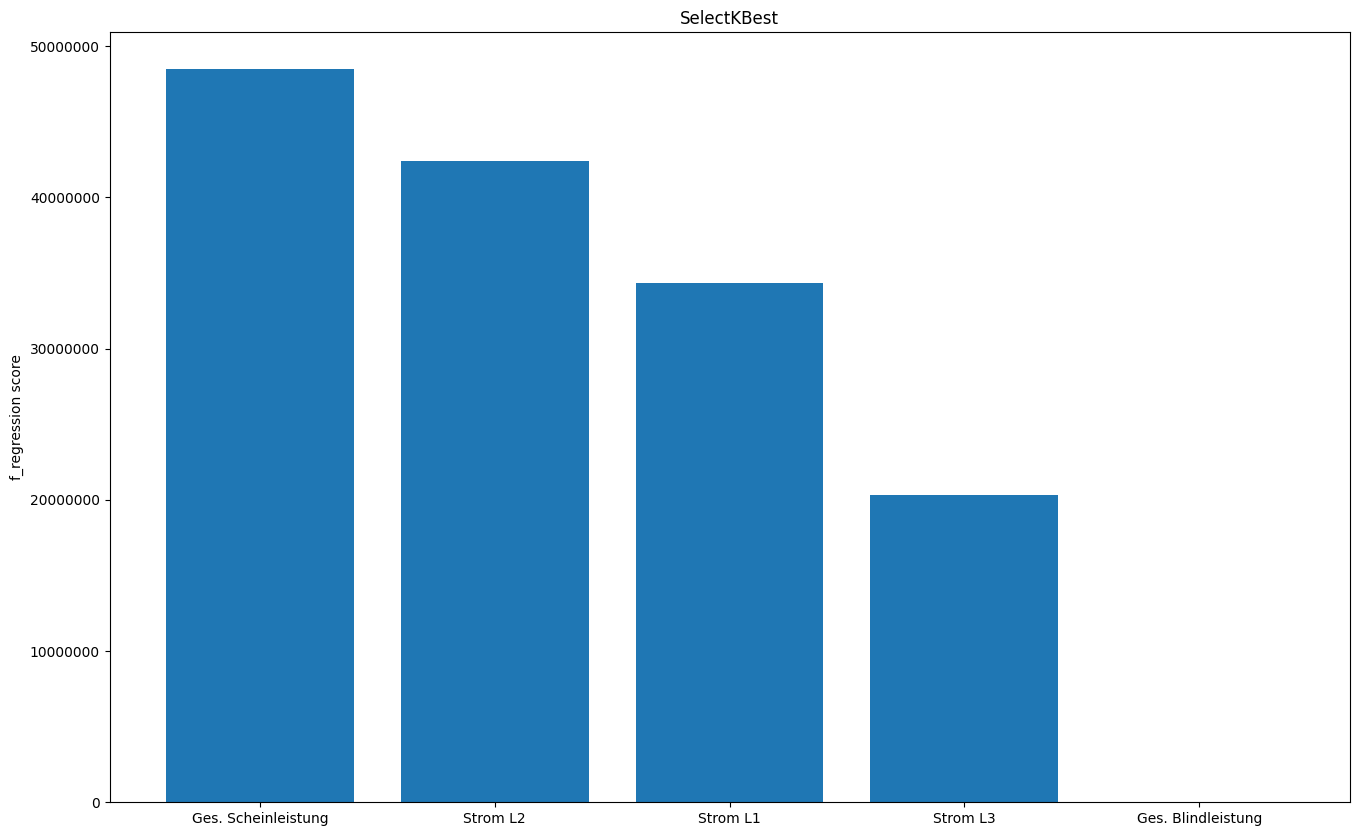

In [116]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

ax.bar(names, scores)
ax.set_title(f"SelectKBest")
ax.set_ylabel(f"f_regression score")
#ax.set_xlabel(f"Feature")
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)

plt.savefig(f'./results/self/{MACHINE_NAME} SelectKBest Feature Selection.png', transparent=PLOT_TRANSPARENT)

In [117]:
selector.get_feature_names_out()

array(['Ges. Blindleistung', 'Ges. Scheinleistung', 'Strom L1',
       'Strom L2', 'Strom L3'], dtype=object)

Results:<br>
The results are identical to the results of the correlation. The Strom features and the "Ges. Scheinleistung".

"Ges. Blindleistung" seem to not provide useful informations for the Target value.

---
### Dimension Reduction

Ressources:
- class
- https://www.statology.org/principal-components-regression-in-python/


[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

In [118]:
scaler = StandardScaler()
normalised_df = df.copy()
for cur_col in COLUMNS:
    if cur_col not in ["Zeitstempel"]:
        normalised_df[cur_col] = scaler.fit_transform(df[cur_col].to_numpy().reshape(-1, 1))

X = normalised_df.loc[:, [#'Zeitstempel',
                            'Ges. Blindleistung',
                            'Ges. Scheinleistung',
                            'Strom L1',
                            'Strom L2',
                            'Strom L3']]
#X = X.reset_index(drop=True, inplace=False)
y = normalised_df.loc[:, 'Ges. Wirkleistung']
#y = y.reset_index(drop=False, inplace=False)

In [119]:
pca = PCA()
X_reduced = pca.fit_transform(X)

Text(0.5, 1.0, 'PCA')

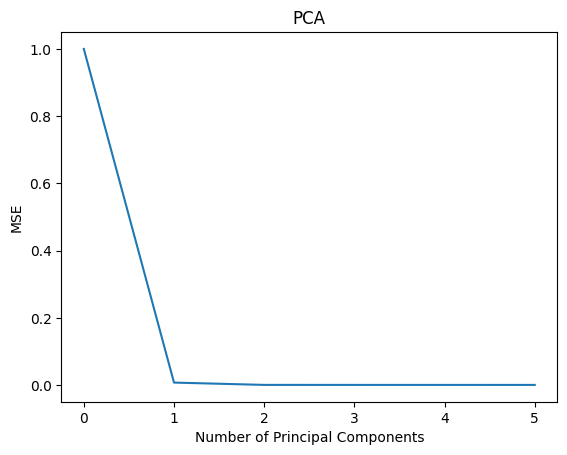

In [120]:
# evaluate PCA results with an model (here LinearRegression)
# use cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(model, np.ones((len(X_reduced),1)), y, cv=cv, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1*model_selection.cross_val_score(model,
               X_reduced[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('PCA')

<Axes: >

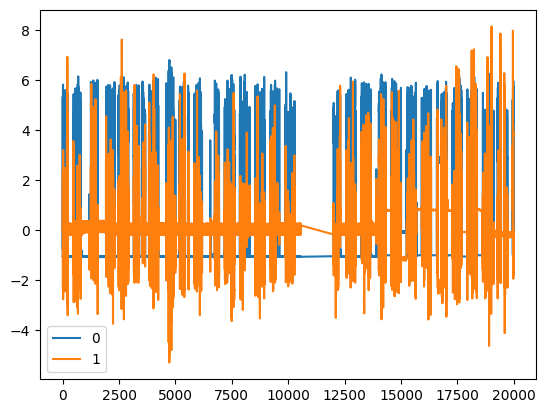

In [121]:
pd.DataFrame(X_reduced[:,:2]).plot()

In [122]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 82.72,  99.99, 100.  , 100.  , 100.  ])

With 2 principal components we explain 99,9% of the variance!

In [123]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalised_df.drop(columns=["Zeitstempel"]))

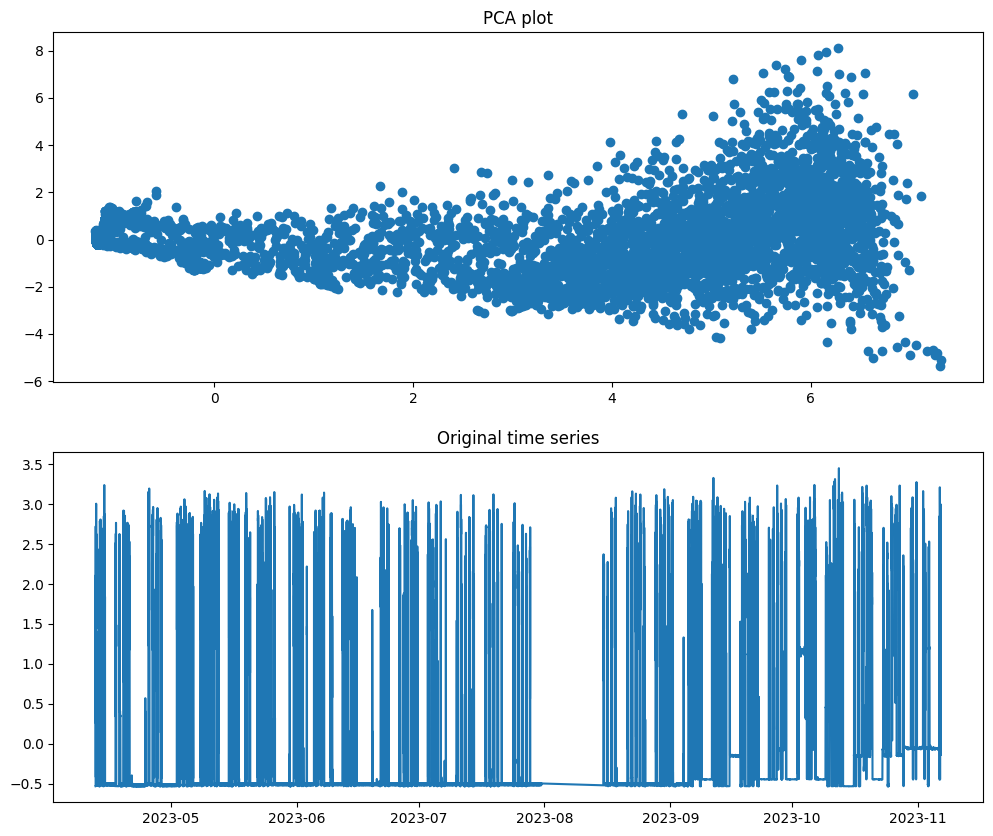

In [124]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].scatter(principal_components[:, 0], principal_components[:, 1])
ax[0].set_title('PCA plot')

ax[1].plot(normalised_df[TARGET])
ax[1].set_title('Original time series')

plt.savefig(f'./results/self/{MACHINE_NAME} PCA Results.png', transparent=PLOT_TRANSPARENT)

T-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19991 samples in 0.016s...
[t-SNE] Computed neighbors for 19991 samples in 0.329s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19991
[t-SNE] Computed conditional probabilities for sample 2000 / 19991
[t-SNE] Computed conditional probabilities for sample 3000 / 19991
[t-SNE] Computed conditional probabilities for sample 4000 / 19991
[t-SNE] Computed conditional probabilities for sample 5000 / 19991
[t-SNE] Computed conditional probabilities for sample 6000 / 19991
[t-SNE] Computed conditional probabilities for sample 7000 / 19991
[t-SNE] Computed conditional probabilities for sample 8000 / 19991
[t-SNE] Computed conditional probabilities for sample 9000 / 19991
[t-SNE] Computed conditional probabilities for sample 10000 / 19991
[t-SNE] Computed conditional probabilities for sample 11000 / 19991
[t-SNE] Computed conditional probabilities for sample 12000 / 19991
[t-SNE] Computed conditional probabilities for sam

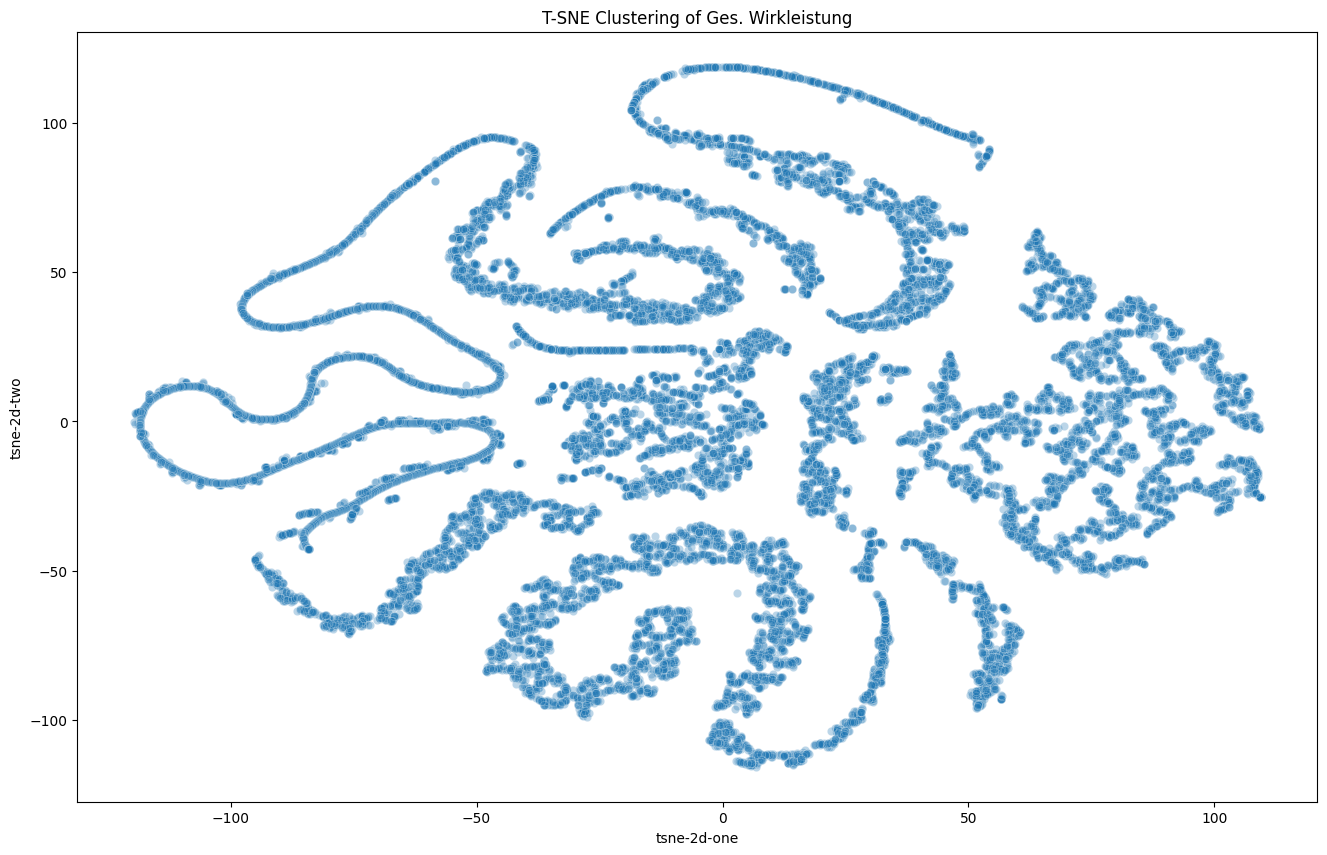

<Figure size 640x480 with 0 Axes>

In [125]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(normalised_df.drop(columns=["Zeitstempel"]))

# Erstellen Sie einen DataFrame für Seaborn
df_ = pd.DataFrame(X_tsne, columns=['tsne-2d-one', 'tsne-2d-two'])

# Visualisieren Sie die Daten
plt.figure(figsize=(16,10))
plt.title(f"T-SNE Clustering of {TARGET}")
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df_,
    legend="full",
    alpha=0.3
)
plt.show()
plt.savefig(f'./results/self/{MACHINE_NAME} T-SNE Clustering of {TARGET}.png', transparent=PLOT_TRANSPARENT)

Results:<br>
...

---
### Clustering

Idea: Split the timeseries in sub-timeseries and find so similiar pattern in the timeseries. 

[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

In [126]:
# window_size = 100

# normalised_df = normalize(df)
# cluster_df = normalised_df[TARGET]

# rolled_df = normalised_df[TARGET].rolling(window=window_size)

# # Erstellen Sie einen neuen DataFrame, um die Chunks zu speichern
# chunk_df = pd.DataFrame()

# # Fügen Sie jeden Chunk als eine neue Spalte in chunk_df ein
# for i in rolled_df:
#     chunk_df[f'chunk_{i}'] = i

# chunk_df.dropna(inplace=True)

In [127]:
# chunks to 1 hour or 2 hours
# or every dy 1 chunk?

In [128]:
normalised_df = normalize(df)
cluster_df = normalised_df[TARGET]

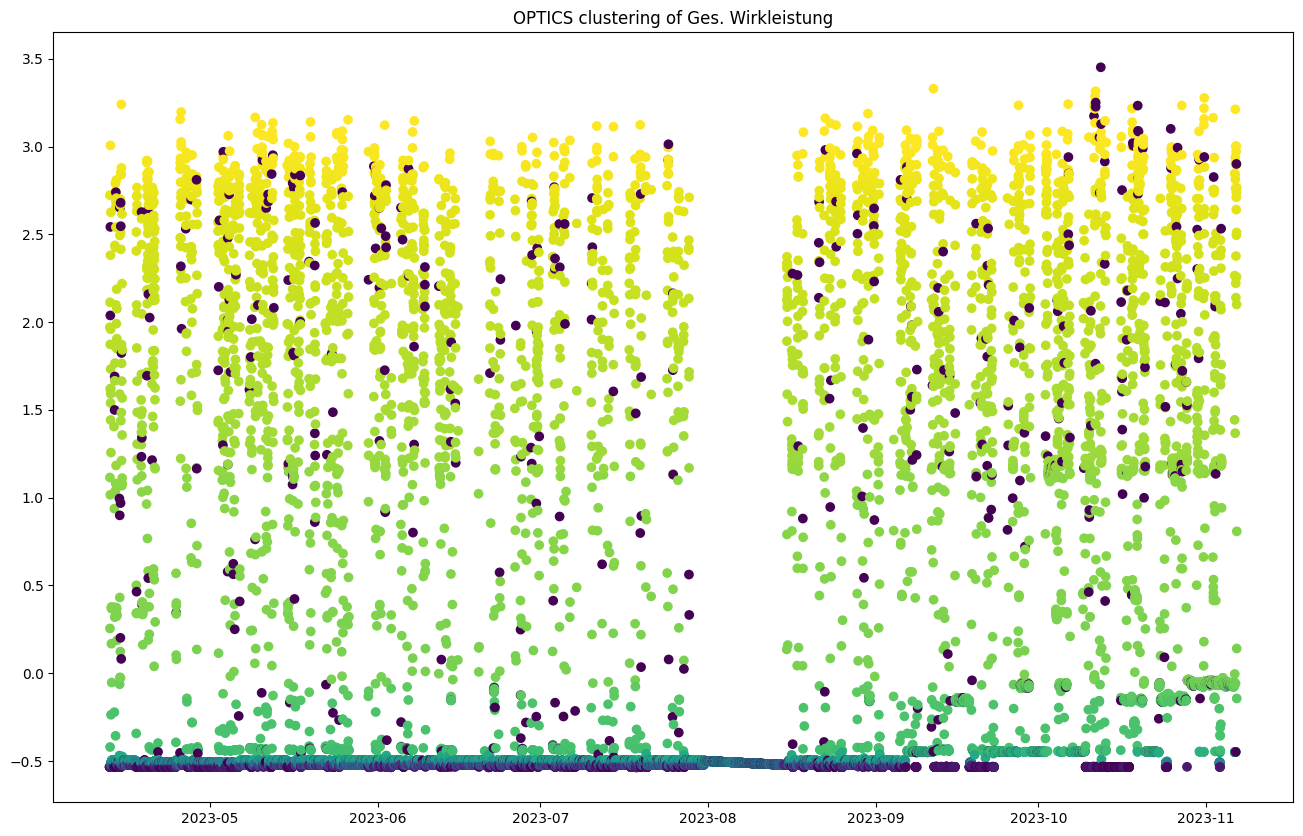

In [129]:
optics = OPTICS(min_samples=2)
normalised_df['cluster'] = optics.fit_predict(normalised_df[[TARGET]])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

ax.scatter(normalised_df.index, normalised_df[TARGET], c=normalised_df['cluster'], linewidth=1)
ax.set_title(f'OPTICS clustering of {TARGET}')
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)

plt.savefig(f'./results/self/{MACHINE_NAME} OPTICS clustering of {TARGET}.png', transparent=PLOT_TRANSPARENT)

Next steps -> reduce data amount -> PCA, only 1 month, downsampling (per day? per hour?)

In [130]:
# # Wenden Sie hierarchisches Clustering an
# Z = linkage(normalised_df[[TARGET]], 'ward')

# # Erstellen Sie ein Dendrogramm
# plt.figure(figsize=(25, 10))
# dendrogram(Z)
# plt.show()

In [131]:
# n_clusters = 3

# kmeans = KMeans(n_clusters=chunk_df)
# kmeans.fit(chunk_df)

# # Fügen Sie die Cluster-Labels zu Ihren ursprünglichen Daten hinzu
# chunk_df['cluster'] = kmeans.labels_

In [132]:
# fig, axs = plt.subplots(n_clusters, 1, figsize=(10,6))

# # Erstellen Sie eine Farbpalette mit der Anzahl der Cluster
# colors = plt.cm.Spectral(np.linspace(0, 1, chunk_df))

# for i, color in enumerate(colors):
#     axs[i].plot(cluster_df[chunk_df['cluster'] == i].drop(columns=("Zeitstempel")).T, color=color)
#     axs[i].set_title(f'Cluster {i+1}')

Results:<br>
...

---
### Frequency Analysis

=> Maybe more for stationary data and signal data

-> Spectral Analysis

Time series frequency analysis is a method used to analyze a sequence of data points collected over an interval of time. In this analysis, data points are recorded at consistent intervals over a set period of time1. The frequency of a time series refers to how much time elapses between two data points2. For example, if data points are collected every 15 minutes, the frequency of the time series is 15 minutes.

The purpose of time series frequency analysis is to understand the underlying causes of trends or systemic patterns over time1. It can show likely changes in the data, like seasonality or cyclic behavior, which provides a better understanding of data variables and helps forecast better1. This type of analysis is particularly useful in fields like finance, retail, and economics, where data points (such as currency values or sales figures) are constantly changing.

One common method used in time series frequency analysis is the Fast Fourier Transform (FFT). This approach is based on harmonic analysis and filtering of signals in the frequency domain using the Fourier transform3. It helps to understand the frequency components in your data.

In summary, time series frequency analysis is a powerful tool for understanding trends and patterns in time-dependent data, and for making predictions based on these patterns. It’s important to note that this type of analysis typically requires a large number of data points to ensure consistency and reliability.

[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

Only qualitative statements possible -> because non stationary


Qualitative statements about spectral components in Fourier spectral analysis can include aspects such as:

1. **Presence of certain frequencies**: The Fourier analysis can reveal whether certain frequencies are present in a signal. This can be particularly useful for identifying periodic patterns in the data.

2. **Strength or amplitude of frequencies**: The Fourier analysis can also determine the strength or amplitude of each frequency component. This can provide insight into which frequencies are most prominent in a signal.

3. **Changes in the frequency spectrum over time**: Although the classic Fourier transform does not provide information about the temporal occurrence of frequencies, extended methods such as the short-time Fourier transform or the wavelet transform can be used to analyze changes in the frequency spectrum over time.

4. **Detection of anomalies**: If the frequency spectrum of a "normal" signal is known, any significant deviation from this spectrum can be considered an anomaly or potential indicator of a problem.

However, it's important to note that these statements primarily rely on the interpretation of the analysis results and therefore depend on the specific application and underlying data.

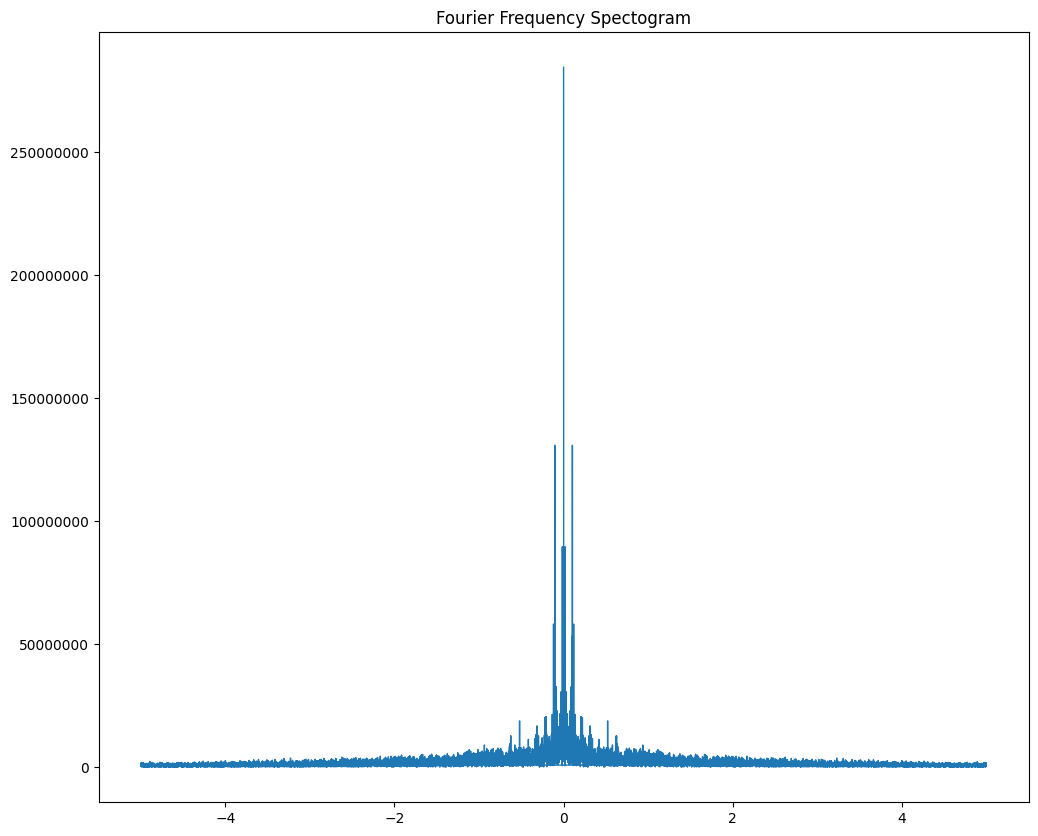

In [133]:
fft = np.fft.fft(df[TARGET])
freqs = np.fft.fftfreq(len(df), 0.1)  # 0.1 ist das Intervall. Ändern Sie dies entsprechend Ihren Daten.


# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
# ax[0].plot(df.index, df[TARGET], linewidth=1)
# ax[0].set_title('Ursprüngliche Zeitreihe')
# ax[1].plot(freqs, np.abs(fft))
# ax[1].set_title('Frequenzspektrum')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.plot(freqs, np.abs(fft), linewidth=1)
ax.set_title('Fourier Frequency Spectogram')
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)

plt.savefig(f'./results/self/{MACHINE_NAME} Spectogram of {TARGET}.png', transparent=PLOT_TRANSPARENT)

=> Meaning?

Ein Spektrogramm ist eine visuelle Darstellung von Frequenzen in einem Signal, wie z.B. einer Zeitreihe. Hier sind die Schritte, um ein Spektrogramm zu lesen:

1. **Achsen verstehen**: Die x-Achse repräsentiert die Zeit und die y-Achse repräsentiert die Frequenz. Die Farbe des Plots repräsentiert die Leistung des Signals bei dieser Frequenz und Amplitude. Je dunkler die Farbe, desto höher die Leistung.

2. **Muster erkennen**: Sie können dieses Diagramm verwenden, um Muster und Trends in Ihren Daten zu identifizieren. Zum Beispiel, wenn es eine dunkle Linie gibt, die sich mit der Zeit ändert, könnte das eine sich ändernde Frequenz in Ihren Daten repräsentieren.

3. **Amplitudeninterpretation**: Die Amplitude bei einer bestimmten Frequenz zu einem bestimmten Zeitpunkt ist proportional zur Intensität der Farbe. Eine höhere Amplitude führt zu einer intensiveren Farbe.

4. **Frequenzinterpretation**: Die Frequenz, die zu einem bestimmten Zeitpunkt dominiert, kann durch die Position der intensivsten Farbe zu diesem Zeitpunkt bestimmt werden.

Bitte beachten Sie, dass die genaue Interpretation von einem Spektrogramm von der Art der Daten und dem spezifischen Kontext abhängt.



Die Werte in der Mitte des Spektrogramms repräsentieren die Leistung (oder Intensität) des Signals bei einer bestimmten Frequenz und zu einem bestimmten Zeitpunkt. Die Farbe dieser Werte zeigt die Leistung an: je dunkler die Farbe, desto höher die Leistung. 

Wenn Sie also einen dunklen Fleck in der Mitte Ihres Spektrogramms sehen, bedeutet das, dass das Signal zu diesem Zeitpunkt eine hohe Leistung bei der Frequenz hat, die der y-Achsenposition dieses Flecks entspricht. 

Bitte beachten Sie, dass die genaue Interpretation von den spezifischen Daten und dem Kontext abhängt. Es könnte hilfreich sein, die Dokumentation oder zusätzliche Ressourcen zu konsultieren, die spezifisch für die Art der Daten sind, die Sie analysieren.

---
### Weather analysis

[🚀 up](#Data-Exploratory-Analysis-+-Data-Quality)

In [134]:
use_ema200 = True

# weather feature

# set weather station + date -> make this part smarter, for predictions
start = datetime(df.index.min().year, df.index.min().month, df.index.min().day)  #datetime(2023, 4, 4)
end =  datetime(df.index.max().year, df.index.max().month, df.index.max().day+1)     
loc = Point(lat=48.02, lon=7.83, alt=238)  # Freiburg

# get historical data
weather_daily = Daily(loc, start, end)
weather_daily = weather_daily.fetch()

date = weather_daily.index
temperature = weather_daily['tavg'].fillna(weather_daily['tavg'].mean())  #weather_daily['tavg'].fillna(0)
precipitation = weather_daily['prcp'].fillna(weather_daily['prcp'].mean()) #weather_daily['prcp'].fillna(0)

weather_data = pd.DataFrame({"DATE":date, "TEMPERATURE":temperature, "PRECIPITATION":precipitation})

if use_ema200:
    # calculate EMA200
    weather_data['TEMPERATURE_EMA200'] = weather_data['TEMPERATURE'].ewm(span=200, adjust=False).mean()
    weather_data['TEMPERATURE_EMA200'].fillna(weather_data['TEMPERATURE_EMA200'].mean(), inplace=True)
    weather_data['PRECIPITATION_EMA200'] = weather_data['PRECIPITATION'].ewm(span=200, adjust=False).mean().fillna(weather_daily['tavg'].mean())
    weather_data['PRECIPITATION_EMA200'].fillna(weather_data['PRECIPITATION_EMA200'].mean(), inplace=True)
    weather_data.drop(columns=["TEMPERATURE", "PRECIPITATION"], inplace=True)
    weather_data.rename(columns={"TEMPERATURE_EMA200": "TEMPERATURE", "PRECIPITATION_EMA200": "PRECIPITATION"}, inplace=True)

weather_data = weather_data.resample("1min").mean().interpolate()

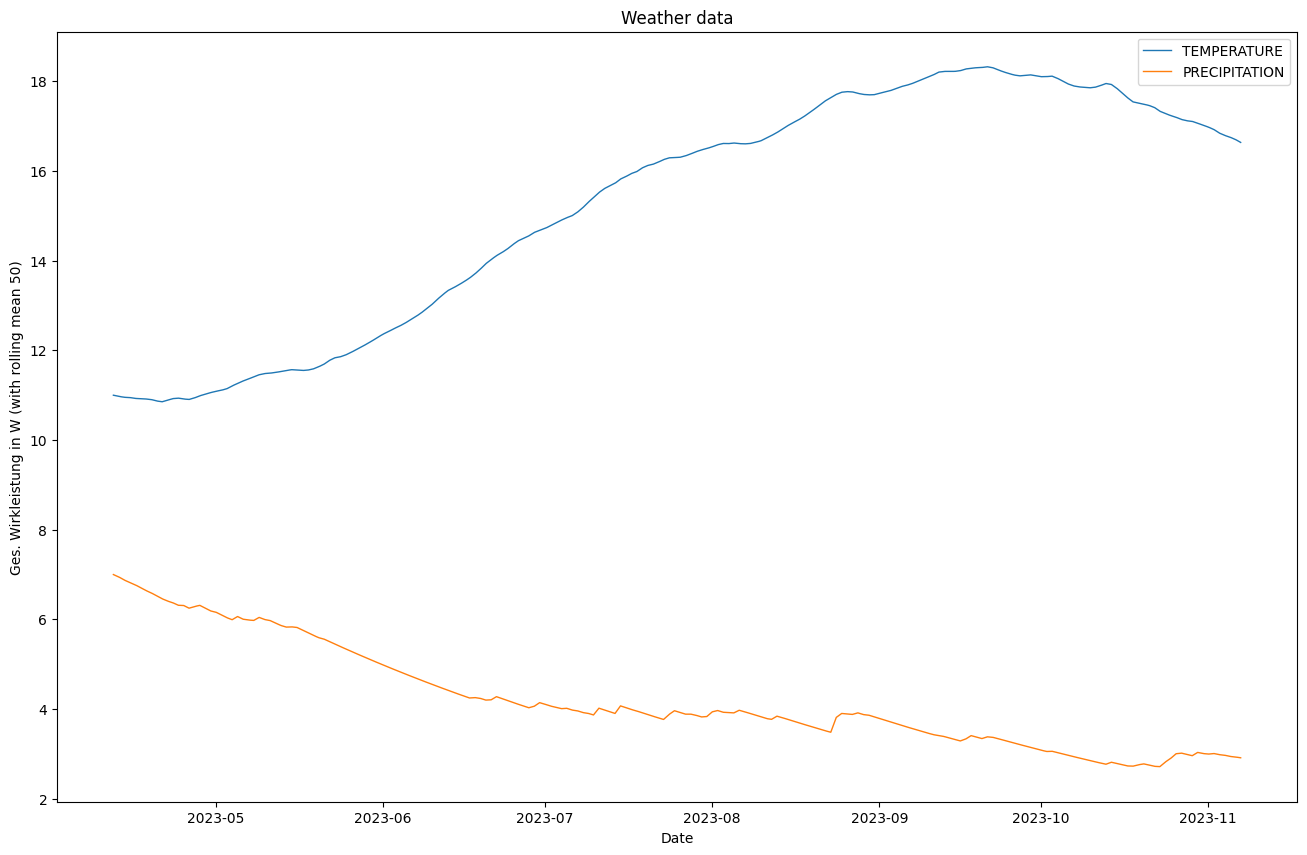

In [135]:
window_size = 20

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

# .rolling(window_size)
ax.plot(weather_data["TEMPERATURE"], linewidth=1, label="TEMPERATURE")
ax.plot(weather_data["PRECIPITATION"], linewidth=1, label="PRECIPITATION")
ax.set_title(f"Weather data")
ax.set_ylabel(f"{TARGET} in W (with rolling mean 50)")
ax.set_xlabel(f"Date")
ax.legend()

plt.savefig(f'./results/self/{MACHINE_NAME} Wether data.png', transparent=PLOT_TRANSPARENT)

In [136]:
weather_df = df.join(weather_data, how='left', lsuffix='_df', rsuffix='_weather_data')
print(len(weather_df.index) == len(df.index))
display(weather_df)

True


In [137]:
scaled_weather_df = normalize(weather_df)

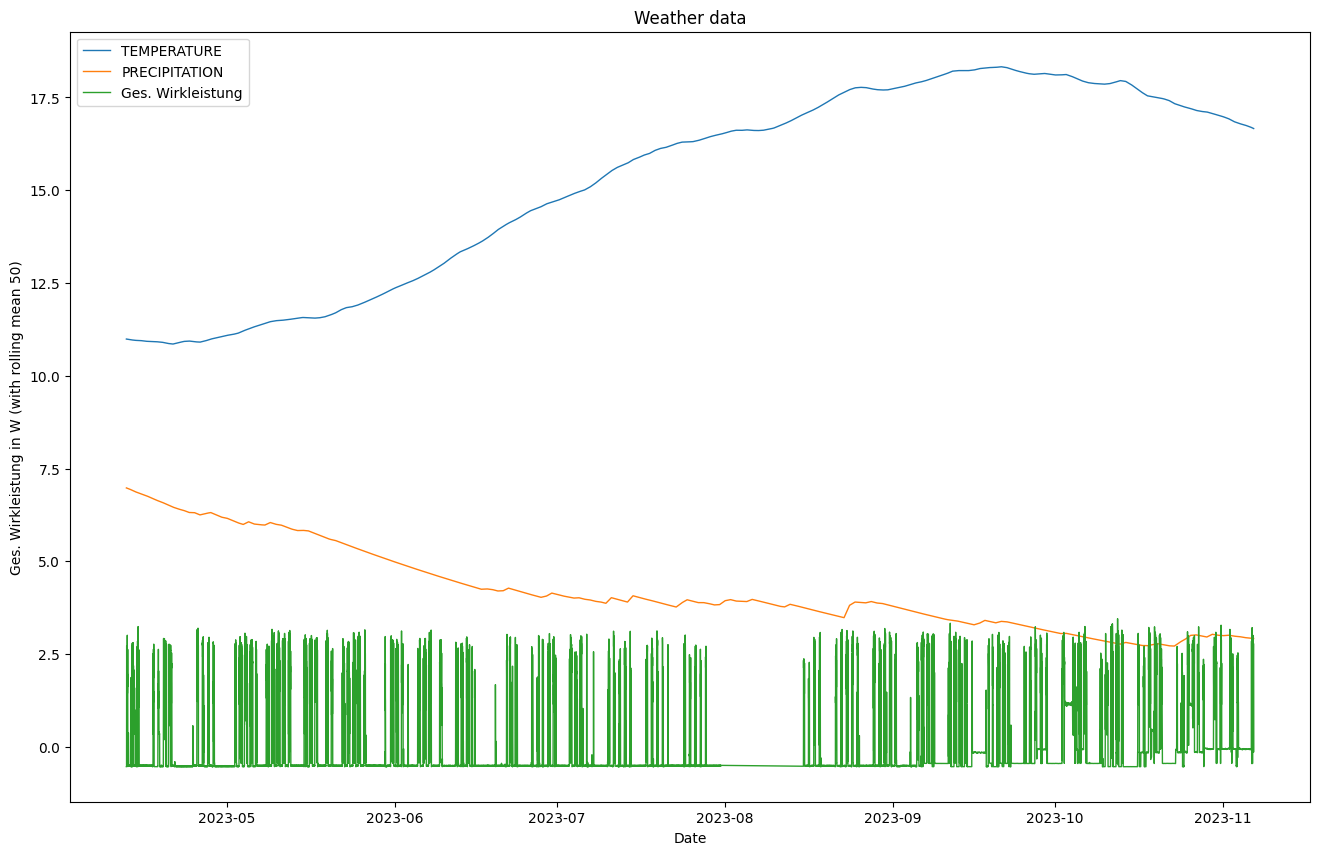

In [138]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 10))

# .rolling(window_size)
ax.plot(scaled_weather_df["TEMPERATURE"], linewidth=1, label="TEMPERATURE")
ax.plot(scaled_weather_df["PRECIPITATION"], linewidth=1, label="PRECIPITATION")
ax.plot(scaled_weather_df[TARGET], linewidth=1, label=f"{TARGET}")
ax.set_title(f"Weather data")
ax.set_ylabel(f"{TARGET} in W (with rolling mean 50)")
ax.set_xlabel(f"Date")
ax.legend()

plt.savefig(f'./results/self/{MACHINE_NAME} Wether data with {TARGET}.png', transparent=PLOT_TRANSPARENT)

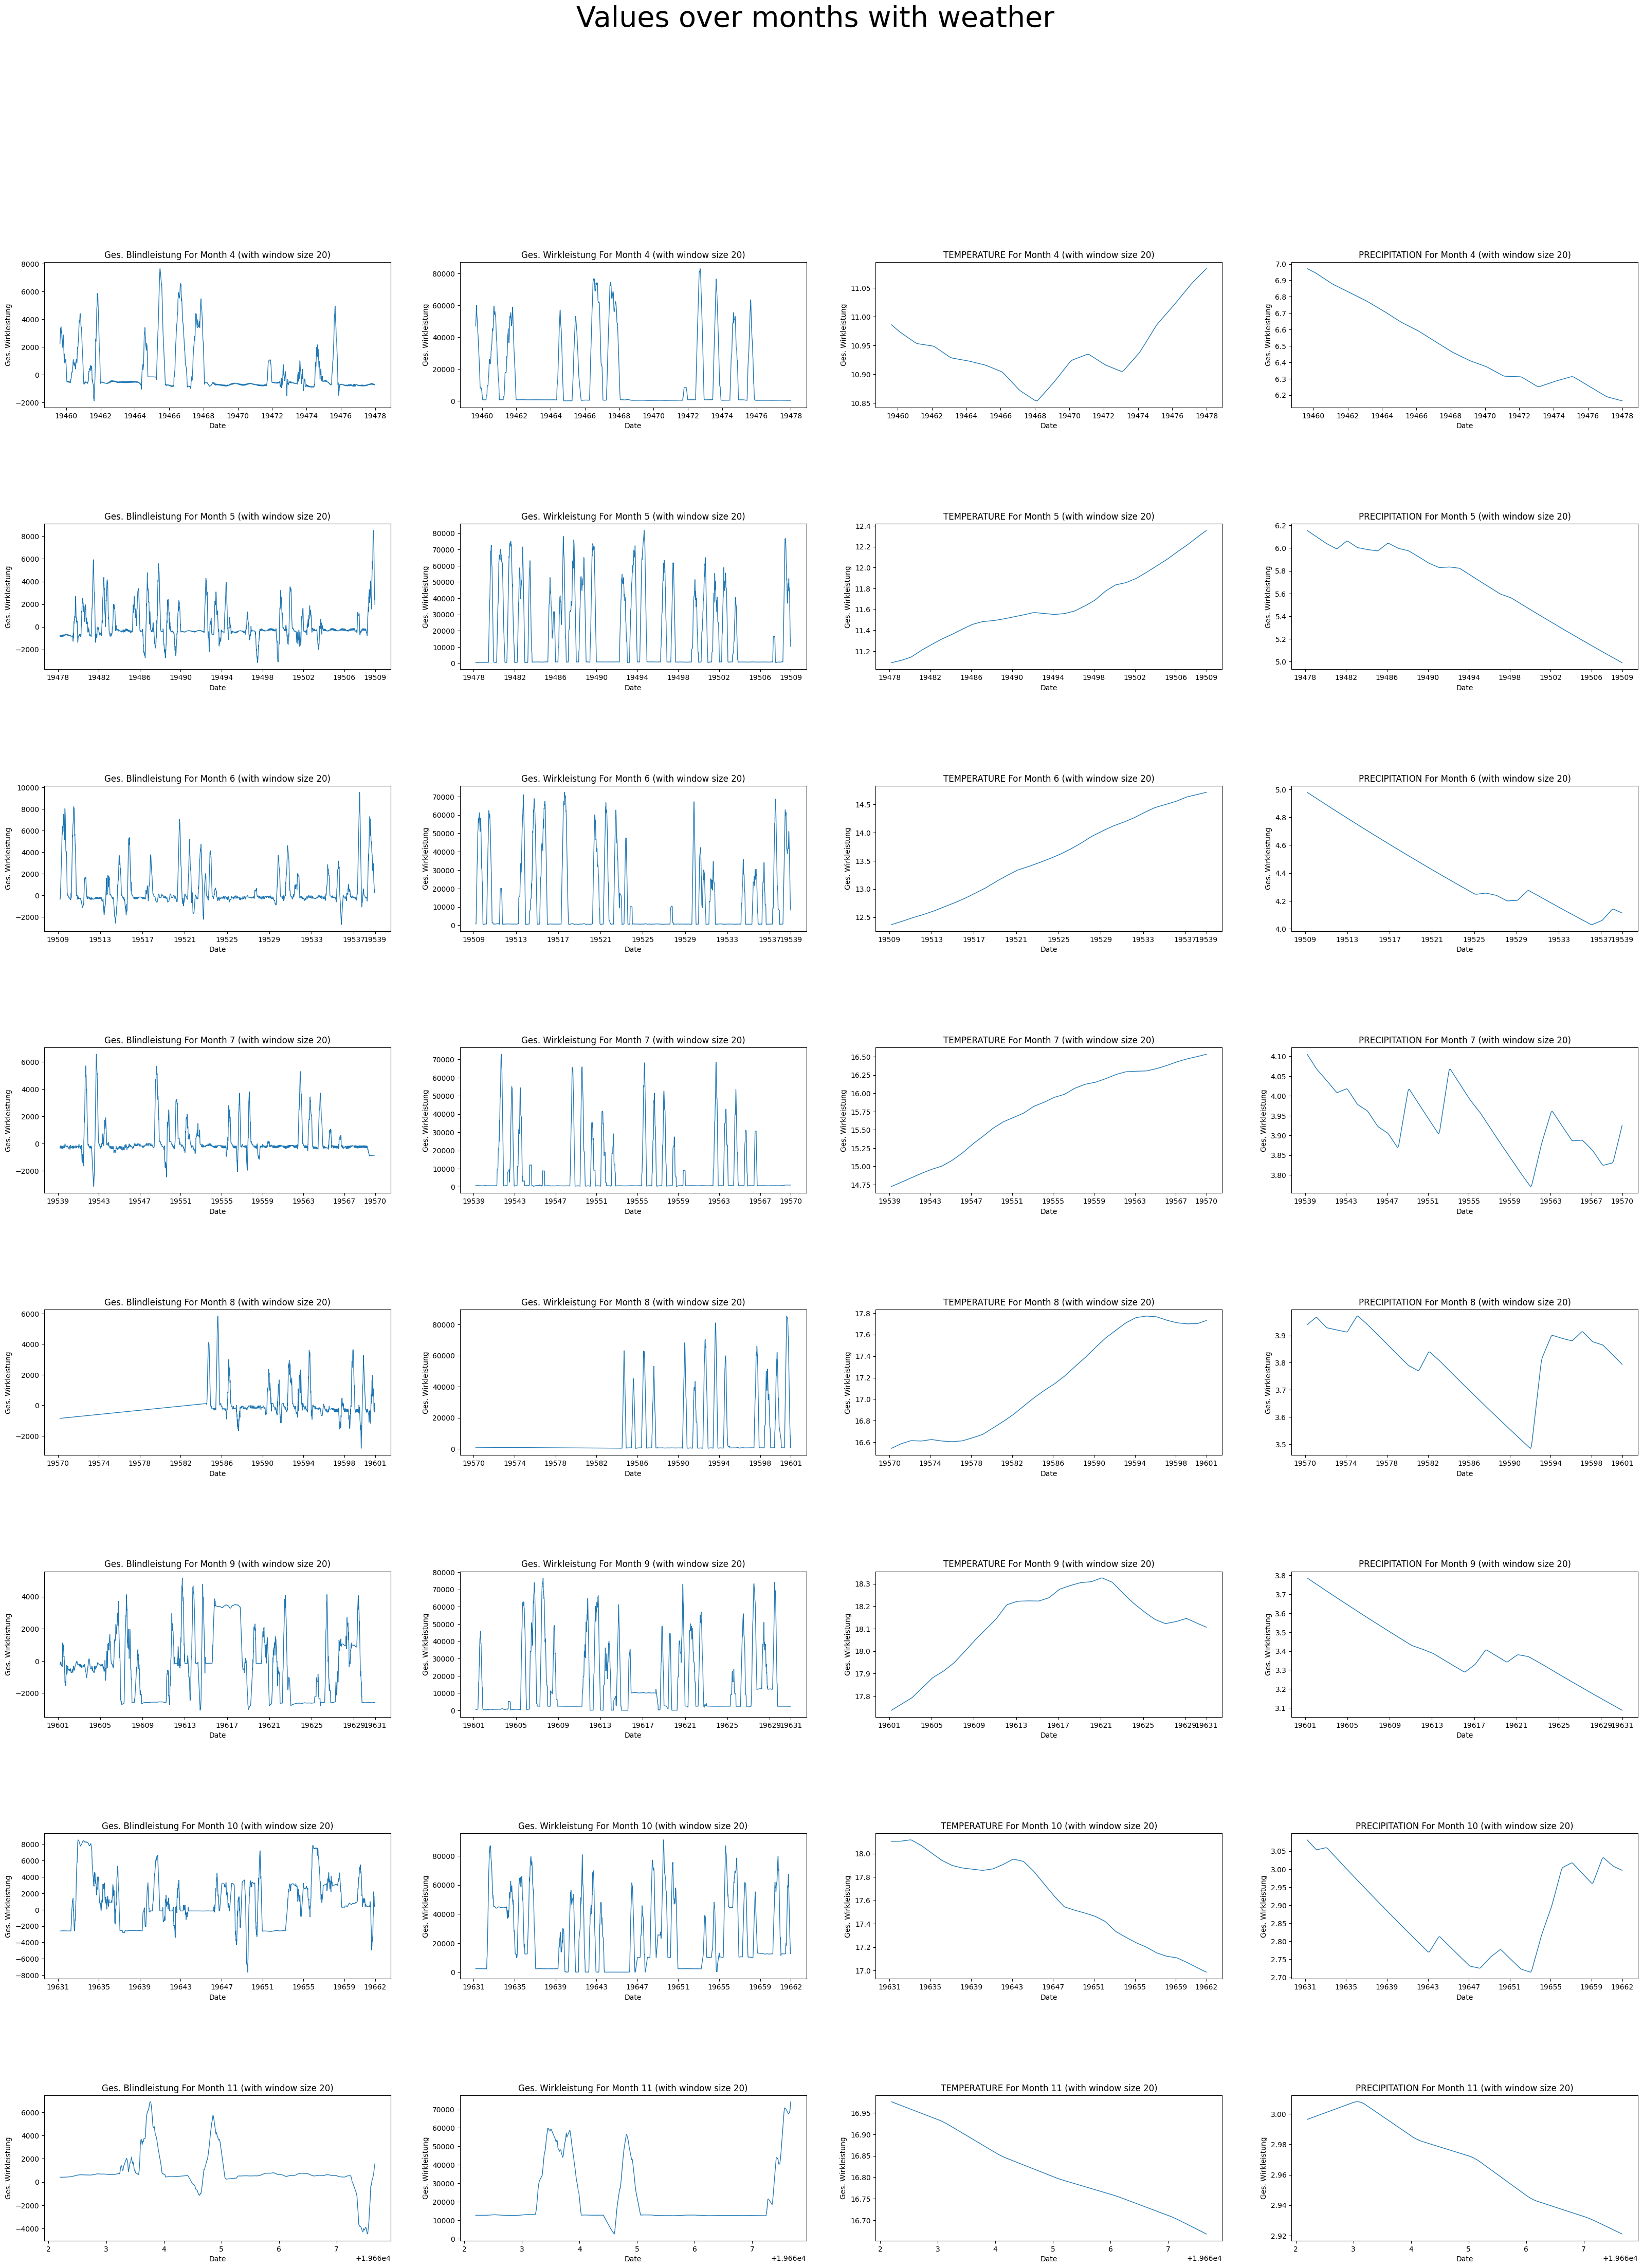

In [139]:
window_size = 20

months = list(df.index.month.unique())
cols = ['Ges. Blindleistung', 'Ges. Wirkleistung', "TEMPERATURE", "PRECIPITATION"]
row = 0

fig, ax = plt.subplots(ncols=len(cols), nrows=len(months), figsize=(40, 50), gridspec_kw={'hspace': 0.8})
fig.suptitle("Values over months with weather", fontsize=40)
for idx, cur_month in enumerate(months):
    for col_idx in range(len(cols)):
        col = col_idx #(idx+1)%cols
        #row = (idx-1)//cols

        cache_df = weather_df.loc[weather_df.index.month == cur_month, :]

        ax[row, col].plot(cache_df[cols[col]].rolling(window_size).mean(), linewidth=1)
        #ax[row, col].plot(cache_df[TARGET].rolling(window_size).var(), linewidth=1)
        title = f"{cols[col]} For Month {cur_month} (with window size {window_size})"
            
        formatter = ticker.ScalarFormatter()
        formatter.set_scientific(False)
        ax[row, col].yaxis.set_major_formatter(formatter)
        ax[row, col].xaxis.set_major_formatter(formatter)
        #ax[row, col].set_xticks(ax[row, col].get_xticks()[::10])
        #ax[row, col].set_xticklabels(cache_df.index[::1000])
        ax[row, col].set_ylabel(f"{TARGET}")
        ax[row, col].set_title(f"{cur_date_} <{check_day_type(cur_date_)}>")
        ax[row, col].set_xlabel(f"Date")
        ax[row, col].set_title(title)
    row += 1

plt.savefig(f'./results/self/{MACHINE_NAME} Values over months with weather.png', transparent=PLOT_TRANSPARENT)

del cache_df

In [140]:
# import pandas as pd
# import time
# from datetime import datetime

# import sys
# import subprocess

# # import weather lib -> install if not existing
# try:
#     from meteostat import Stations, Monthly, Point, Daily
# except:
#     subprocess.check_call([sys.executable, "-m", "pip", "install", "meteostat"])
# from meteostat import Stations, Monthly, Point, Daily

# # import ml-model for forecasting -> install if not existing
# try:
#     from sklearn.svm import SVR
# except:
#     subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
# from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression

# # get workflow variable
# use_ema200 = "@use_ema200@"
# if use_ema200.lower() == "false":
#     use_ema200 = False
# else:
#     use_ema200 = True

# # load input
# train = od_input['input1'].get_as_pandas()
# application = od_input['input2'].get_as_pandas()

# # weather feature

# # set weather station + date
#                                     # 10 Years more than PREP Start Date
# start = datetime(train['MIN_DATE'][0].year-10, train['MIN_DATE'][0].month, train['MIN_DATE'][0].day) 
# end =  datetime(train['MAX_DATE'][0].year, train['MAX_DATE'][0].month, train['MAX_DATE'][0].day)
# loc = Point(lat=50.1003, lon=14.2555, alt=364)  #https://www.chmi.cz/aktualni-situace/aktualni-stav-pocasi/ceska-republika/stanice/profesionalni-stanice/tabulky/zemepisne-souradnice?l=en

# # get historical data
# weather_daily = Daily(loc, start, end)
# weather_daily = weather_daily.fetch()

# date = weather_daily.index
# temperature = weather_daily['tavg'].fillna(weather_daily['tavg'].mean())
# precipitation = weather_daily['prcp'].fillna(weather_daily['prcp'].mean())

# # check start and end date -> deactivated
# #if pd.to_datetime(weather_daily.index.to_series()).min() != start or pd.to_datetime(weather_daily.index.to_series()).max() != end:
# #    error_reason_msg = ""
# #    if pd.to_datetime(weather_daily.index.to_series()).min() != start and pd.to_datetime(weather_daily.index.to_series()).max() != end:
# #        error_reason_msg += "The start date and the end date are the problem!"
# #    elif pd.to_datetime(weather_daily.index.to_series()).min() != start:
# #        error_reason_msg += "The start date is the problem!"
# #    elif pd.to_datetime(weather_daily.index.to_series()).max() != end:
# #        error_reason_msg += "The end date is the problem!"
# #    raise Exception(f"The Weather Data for the given timespace (see below) can't be fetch.\n        start: {start}\n        end: {end}\n-> {error_reason_msg}")


# # train SVR-Model for prediction
# weather_model_1 = SVR(kernel="rbf")
# #weather_model_2 = SVR(kernel="rbf")
# weather_model_2 = RandomForestRegressor(n_estimators=500)#SVR(kernel="rbf")
# # get Target
# weather_y_1 = weather_daily['tavg'].fillna(weather_daily['tavg'].mean())
# weather_y_2 = weather_daily['prcp'].fillna(weather_daily['prcp'].mean())
# # create features -> week_of_the_year
# #week = pd.to_datetime(weather_daily.index.to_series()).dt.isocalendar().week
# #year = pd.to_datetime(weather_daily.index.to_series()).dt.year
# #weather_X = pd.concat([week, year], axis=1).rename(columns={"week": "WEEK", "DATE": "YEAR"})
# weather_X = pd.DataFrame(pd.to_datetime(weather_daily.index.to_series()).dt.isocalendar().week)
# weather_model_1 = weather_model_1.fit(weather_X, weather_y_1)
# weather_model_2 = weather_model_2.fit(weather_X, weather_y_2)

# # create features for application
# #application_x = pd.concat([pd.to_datetime(application['DATE']).dt.isocalendar().week, pd.to_datetime(application['DATE']).dt.year], axis=1).rename(columns={"week": "WEEK", "DATE": "YEAR"})
# application_x = pd.DataFrame(pd.to_datetime(application['DATE']).dt.isocalendar().week)
# date_prediction = application['DATE'].sort_values(ascending=True, inplace=False)
# # create weather forecast
# temperature_prediction = weather_model_1.predict(application_x)
# precipitation_prediction = weather_model_2.predict(application_x)

# result = pd.concat([date_prediction, application_x.astype({'week': 'int64'}), pd.Series(temperature_prediction, name="TEMPERATURE"), pd.Series(precipitation_prediction, name="PRECIPITATION")], axis=1)

# if use_ema200:
#     # calculate EMA200
#     result['TEMPERATURE_EMA200'] = result['TEMPERATURE'].ewm(span=200, adjust=False).mean()
#     result['TEMPERATURE_EMA200'].fillna(result['TEMPERATURE_EMA200'].mean(), inplace=True)
#     result['PRECIPITATION_EMA200'] = result['PRECIPITATION'].ewm(span=200, adjust=False).mean()
#     result['PRECIPITATION_EMA200'].fillna(result['PRECIPITATION_EMA200'].mean(), inplace=True)
#     result.drop(columns=["TEMPERATURE", "PRECIPITATION"], inplace=True)
#     result.rename(columns={"TEMPERATURE_EMA200": "TEMPERATURE", "PRECIPITATION_EMA200": "PRECIPITATION"}, inplace=True)

Results:<br>
It seems like not having a connection to the temperture or the predicition.

---
<h3 style="text-align: center;">~ END ~</h3>
<h3 style="text-align: center;">通过托比亚</h3>

---